<h1 style="color:rgb(92, 11, 10)">Assignment 3: Continuous Evaluation with Kafka</h1>

## Part 2: Dynamic model 

### The purpose of this task is to simulate a real-life scenario of a constant data stream

--------------------------------------------------------------------------------------------------

## Libraries 

In [1]:
# 1.Data Analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(12,16))

# 2.Feature engineering and data cleaning
from sklearn.preprocessing import LabelEncoder

# 3.Feature Filtering/Selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import f1_score
import numpy as np

# 4.Model Training
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate ,cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#----------------------------
# real-time stream 
from kafka import KafkaConsumer
from json import dumps
import pickle

<Figure size 864x1152 with 0 Axes>

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

---------------------------------------

## Functions


<h3 style="color:rgb(92, 11, 10)">Create the necessary code to append 1,000 observations of data streaming
information and use them as a window. </h3>

In [3]:
def build_1000_row_window(iteration):
    batch_1000_row = []
    
    # intialize the counter 
    i = 0 
    for m in consumer: 
        if (i < 1000):
            batch_1000_row.append(m.value)
            
            i = i+1 
        else: 
            break 
            
    print(f"window : {iteration}")
    
    #return batch of 1000 rows 
    return batch_1000_row

In [4]:
def data_cleaning(dataset2):
    # drop null values 
    dataset2 = dataset2.dropna()
    
    # deal with the columns that has string values 
    new_column = dataset2['longest_word'].apply(lambda x: len(x))
    dataset2['longest_word'] = new_column
    
    new_column2 = dataset2['sld'].apply(lambda x: len(x))
    dataset2['sld'] = new_column2
    
    dataset2.drop('timestamp', inplace=True, axis=1)
    
    return dataset2.astype("float")

In [5]:
def preprocess_Dataset(dataset,selected_x_feture_names,target_name):
        
    dataset2 = dataset.copy()
        
    # create X  and y 
    X=dataset2[selected_x_feture_names]
    # get label 
    y=dataset2[target_name]
        
    # normalize X 
    scaler =pickle.load(open('Scaler.pkl', 'rb'))
    X_normalized = scaler.transform(X)
    
    # return normalized_X , and y 
    
    return X_normalized,y.astype('int')
    

In [6]:
column_names =['timestamp','FQDN_count','subdomain_length','upper','lower','numeric','entropy','special',"labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
def prepare_dataFrame( data):
    df=pd.DataFrame()
    list_of_row=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_row.append(row)
    df=pd.DataFrame(list_of_row)
    df.columns=column_names
    return df

In [7]:
def pred(model,X_test,y_test):
    y_pred = model.predict(X_test)
    f1_value    = f1_score(y_test.values.ravel(), y_pred)
    return f1_value
    

In [8]:
def retrain_model(new_dataset):
    
    # drop null values , deal with "longest_word" and "sld" columns , drop the "timestamp" 
    cleaned_dataset =  data_cleaning(new_dataset)
    
    # create x and y then normalize y and return the normalized_X and y
    preprocessed_x,processed_y = preprocess_Dataset(cleaned_dataset,selected_features_names,"Target Attack")    
    
    # Build the model with the best combination of the parameters 
    xgb_Classifier = xgb.XGBClassifier(objective="binary:logistic",learning_rate =0.1, n_estimators=500,max_depth=10, random_state=0)
    
    # fit the model on the training data 
    xgb_Classifier.fit(preprocessed_x,processed_y)
    
    return xgb_Classifier


<h3 style="color:rgb(92, 11, 10)"> Evaluate the performance of each model on each window.</h3>

In [9]:
def evaluate_2_model_performance(model_1,model_2,X_test,y_test):
    
    print("the performance evaluation of the static and Dynamic models")
    
    classifiers = {"static model ": model_1,"Dynamic model ": model_2}
    
    # get prediction of the first model 
    y_pred_1 = model_1.predict(X_test)
    
    # get prediction of the second model 
    y_pred_2 = model_2.predict(X_test)
    
    # classification report of the first model
    cr_1 = classification_report(y_test, y_pred_1)
    
    # classification report of the second model 
    cr_2 = classification_report(y_test, y_pred_2)
    print(" ")
    print(f"classification Report for the static  model")
    print(cr_1)
    print(" ")
    print(f"classification Report for the Dynamic model")
    print(cr_2)
    
    print(" ")
    
    f, axes = plt.subplots(1, 2, figsize=(20, 5), sharey='row')
    
    for i, (key, classifier) in enumerate(classifiers.items()):
        
        y_pred = classifier.predict(X_test)

        cf_matrix = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cf_matrix)
        
        disp.plot(ax=axes[i])
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.40, hspace=0.1)


    f.colorbar(disp.im_, ax=axes)
    plt.show()
    
    
    

In [20]:
def compare_two_models(static_lst,dynamic_lst):
    static_better = 0 
    two_same = 0 
    dynamic_better = 0
    for i in range(len(static_lst)):
        if static_lst[i] >dynamic_lst[i]:
            static_better = static_better+1
        if static_lst[i] <dynamic_lst[i]:
            dynamic_better = dynamic_better+1
            
        if static_lst[i] == dynamic_lst[i]:
            two_same = two_same+1 
            
    print("Summary of the performance of the static and Dynamic models over 249 loop:")
    print(f"The static  was performing better than the Dynamic model {static_better} times ")
    print(f"The Dynamic was performing better than the static  model {dynamic_better} times ")
    print(f"Both the static and the Dynamic models have the same performance {two_same} times")
    print("====================================================================================")  

In [30]:
def analyse_cases(static_lst,dynamic_lst):
    static_better_static_values   = []
    static_better_dynamic_values  = []
    
    dynamic_better_static_values = []
    dynamic_better_dynamic_values = []
    
    static_better = 0 
    dynamic_better = 0
    
    for i in range(len(static_lst)):
        if static_lst[i] >dynamic_lst[i]:
            static_better = static_better+1
            static_better_static_values.append(static_lst[i])
            static_better_dynamic_values.append(dynamic_lst[i])

            
        if static_lst[i] <dynamic_lst[i]:
            dynamic_better = dynamic_better+1
            dynamic_better_static_values.append(static_lst[i])
            dynamic_better_dynamic_values.append(dynamic_lst[i])
    
    plot(static_better,static_better_static_values,static_better_dynamic_values,"The static  was performing better than the Dynamic model")
    plot(dynamic_better,dynamic_better_static_values,dynamic_better_dynamic_values,"The Dynamic was performing better than the static  model")
    

In [35]:
def plot(better,better_static_values,better_dynamic_values,title):
    plt.plot(range(better),better_static_values, label = "static  model")
    plt.plot(range(better),better_dynamic_values, label = "Dynamic model",color="maroon")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.grid()
    plt.show()

---------------------------------


<h3 style="color:rgb(92, 11, 10)">1. install dockers, create the images, install Kafka and the dependencies.</h3>


<h3 style="color:rgb(92, 11, 10)">2. Use the file called “Kafka_dataset.csv” and use it according to the instructions
to deploy the producer’s task. </h3>

In [10]:
# read the static dataset 
static_dataset= pd.read_csv("Static_dataset.csv")

In [11]:
# static dataset before data preprocessing 
static_dataset

timestamp  FQDN_count  subdomain_length  upper  lower  numeric  \
0        56:19.8          27                10      0     10       11   
1        07:23.9          27                10      0     10       11   
2        23:15.1          26                 9      0     10       10   
3        04:51.9          27                10      0     10       11   
4        12:44.0          15                 9      0     11        0   
...          ...         ...               ...    ...    ...      ...   
268069   33:51.5          18                 3      0     16        0   
268070   36:02.5          27                10      0     10       11   
268071   37:21.5          27                10      0     10       11   
268072   24:25.1          16                 0      0     14        0   
268073   20:56.1          27                10      0     10       11   

         entropy  special  labels  labels_max  labels_average longest_word  \
0       2.570417        6       6           7        3.666667            2   
1       2.767195        6       6           7        3.666667            2   
2       2.742338        6       6           7        3.500000            2   
3       2.570417        6       6           7        3.666667            2   
4       2.929439        4       3           5        4.333333        local   
...          ...      ...     ...         ...             ...          ...   
268069  2.338623        2       3          10        5.333333         alma   
268070  2.767195        6       6           7        3.666667            2   
268071  2.767195        6       6           7        3.666667            2   
268072  3.249687        2       2          13        7.500000        radio   
268073  2.570417        6       6           7        3.666667            2   

                  sld  len  subdomain  Target Attack  
0                 192   14          1              1  
1                 192   14          1              1  
2                 192   13          1              0  
3                 192   14          1              1  
4               local   15          1              1  
...               ...  ...        ...            ...  
268069     almaalomah   14          1              0  
268070            192   14          1              0  
268071            192   14          1              1  
268072  radio-vintage   14          0              0  
268073            192   14          1              1  

[268074 rows x 16 columns]

In [12]:
selected_features_names=['FQDN_count','subdomain_length','lower','numeric','special','labels','longest_word','subdomain']


<h3 style="color:rgb(92, 11, 10)">3. Load your .h5 model to the notebook </h3>


<h3 style="color:rgb(92, 11, 10)"> 4. Make sure to create two models, one for the dynamic analysis and other for the
static analysis.</h3>

In [13]:
static_model = Dynamic_model= pickle.load(open('Staitic_model.pkl', 'rb'))


<h3 style="color:rgb(92, 11, 10)">5. Run the consumer’s code and validate you are receiving the data stream. </h3>

In [14]:
consumer = KafkaConsumer('ml-raw-dns',
                         bootstrap_servers="localhost:9092",
                         auto_offset_reset='earliest',
                         enable_auto_commit=False)
# ignore the first row 
for m in consumer: 
    m.value
    break


<h3 style="color:rgb(92, 11, 10)">7. Evaluate the dynamic model’s performance and create a decision boundary to
retrain the model or keep it as is. </h3>


<h3 style="color:rgb(92, 11, 10)">9. Use the necessary arrays to store the performance metrics you consider best to
evaluate the performance of both models and create a time-based plot comparing
both performances from both models. </h3>


<h3 style="color:rgb(92, 11, 10)">10. Decide when it is better to retrain the model and justify why. </h3>

window : 1
After getting the data from the window : the f1-score of the static  model= 0.8479 
After getting the data from the window : the f1-score of the Dynamic model= 0.8479 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       473
           1       0.74      1.00      0.85       527

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       473
           1       0.74      1.00      0.85       527

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 


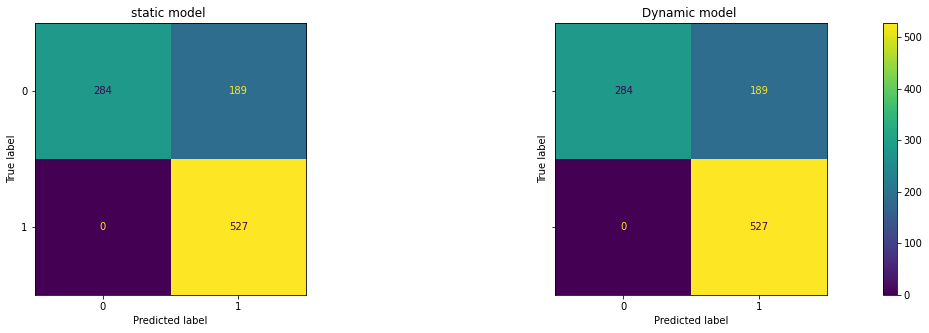

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8479
window : 2
After getting the data from the window : the f1-score of the static  model= 0.8549 
After getting the data from the window : the f1-score of the Dynamic model= 0.8549 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       457
           1       0.75      1.00      0.85       543

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       457
           1       0.75      1.00      0.85       543


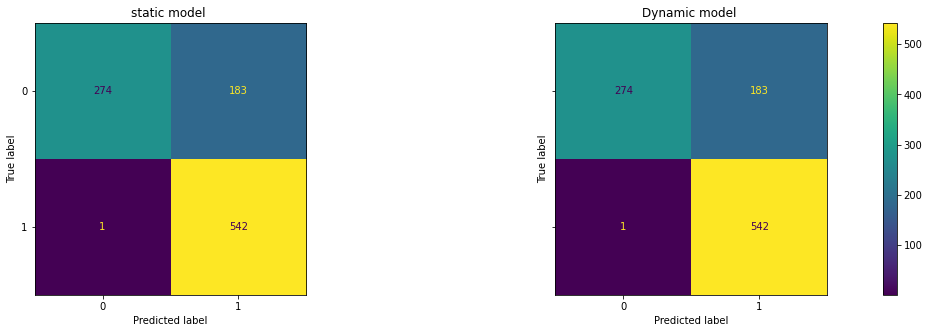

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 3
After getting the data from the window : the f1-score of the static  model= 0.8419 
After getting the data from the window : the f1-score of the Dynamic model= 0.8419 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       457
           1       0.73      1.00      0.84       543

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       457
           1       0.73      1.00      0.84       543

    accuracy                           0.80      1000
   macro avg       0.86      0

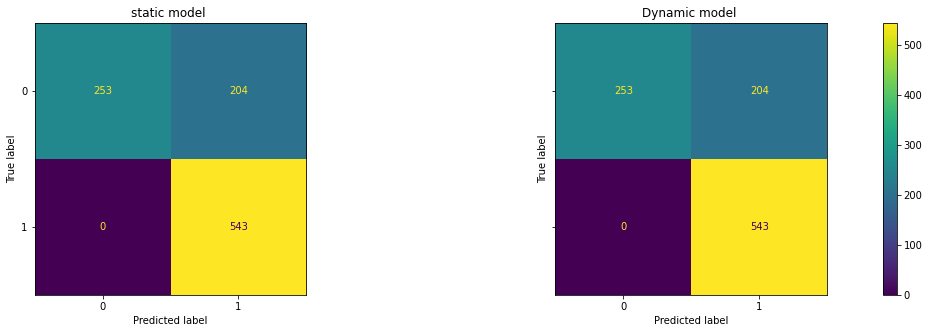

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8419
window : 4
After getting the data from the window : the f1-score of the static  model= 0.8598 
After getting the data from the window : the f1-score of the Dynamic model= 0.8598 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       438
           1       0.76      1.00      0.86       562

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       438
           1       0.76      1.00      0.86       562


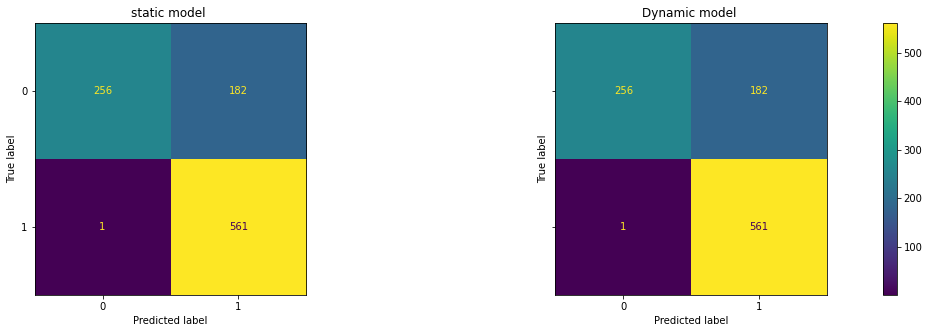

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 5
After getting the data from the window : the f1-score of the static  model= 0.8443 
After getting the data from the window : the f1-score of the Dynamic model= 0.8443 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.74       470
           1       0.73      0.99      0.84       530

    accuracy                           0.81      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.85      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.60      0.74       470
           1       0.73      0.99      0.84       530

    accuracy                           0.81      1000
   macro avg       0.86      0

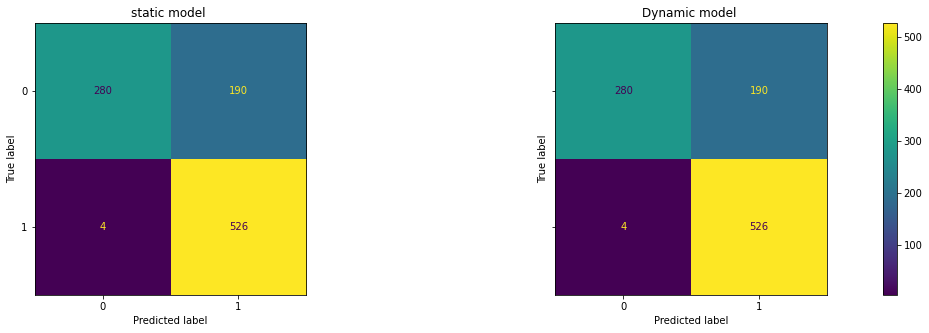

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8443
window : 6
After getting the data from the window : the f1-score of the static  model= 0.8565 
After getting the data from the window : the f1-score of the Dynamic model= 0.8574 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       435
           1       0.75      1.00      0.86       565

    accuracy                           0.81      1000
   macro avg       0.87      0.78      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       435
           1       0.75      1.00      0.86       565


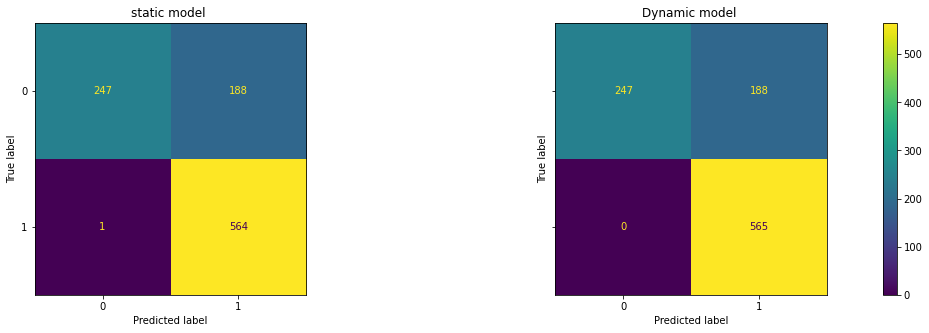

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 7
After getting the data from the window : the f1-score of the static  model= 0.8550 
After getting the data from the window : the f1-score of the Dynamic model= 0.8550 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       443
           1       0.75      1.00      0.85       557

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       443
           1       0.75      1.00      0.85       557

    accuracy                           0.81      1000
   macro avg       0.87      0

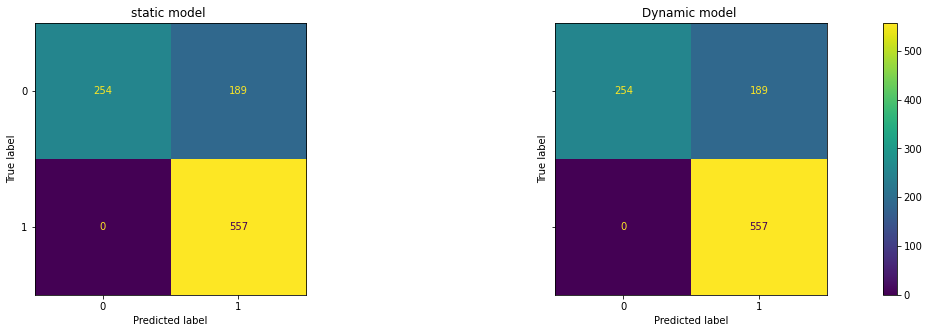

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 8
After getting the data from the window : the f1-score of the static  model= 0.8479 
After getting the data from the window : the f1-score of the Dynamic model= 0.8479 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.57      0.72       449
           1       0.74      1.00      0.85       551

    accuracy                           0.80      1000
   macro avg       0.87      0.78      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.57      0.72       449
           1       0.74      1.00      0.85       551

    accuracy                           0.80      1000
   macro avg       0.87      0

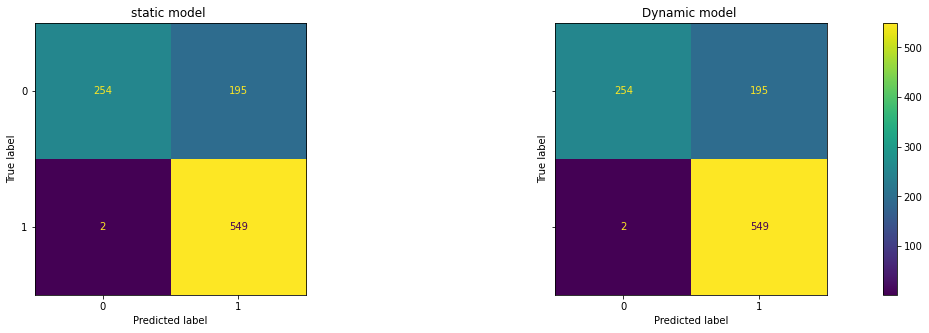

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8479
window : 9
After getting the data from the window : the f1-score of the static  model= 0.8667 
After getting the data from the window : the f1-score of the Dynamic model= 0.8667 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.57      0.72       413
           1       0.77      1.00      0.87       587

    accuracy                           0.82      1000
   macro avg       0.88      0.78      0.79      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.57      0.72       413
           1       0.77      1.00      0.87       587


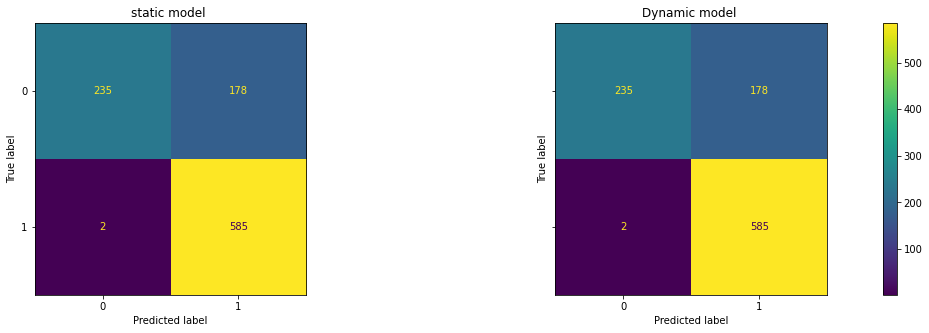

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 10
After getting the data from the window : the f1-score of the static  model= 0.8665 
After getting the data from the window : the f1-score of the Dynamic model= 0.8665 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       429
           1       0.76      1.00      0.87       571

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       429
           1       0.76      1.00      0.87       571

    accuracy                           0.82      1000
   macro avg       0.88      

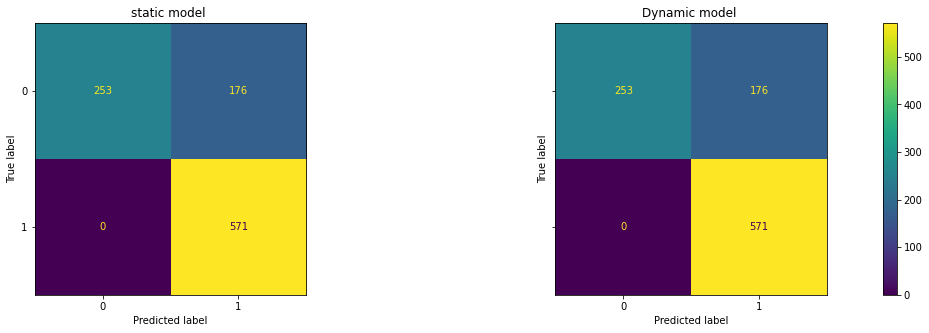

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 11
After getting the data from the window : the f1-score of the static  model= 0.8635 
After getting the data from the window : the f1-score of the Dynamic model= 0.8635 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       440
           1       0.76      1.00      0.86       560

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       440
           1       0.76      1.00      0.86       560

    accuracy                           0.82      1000
   macro avg       0.88      

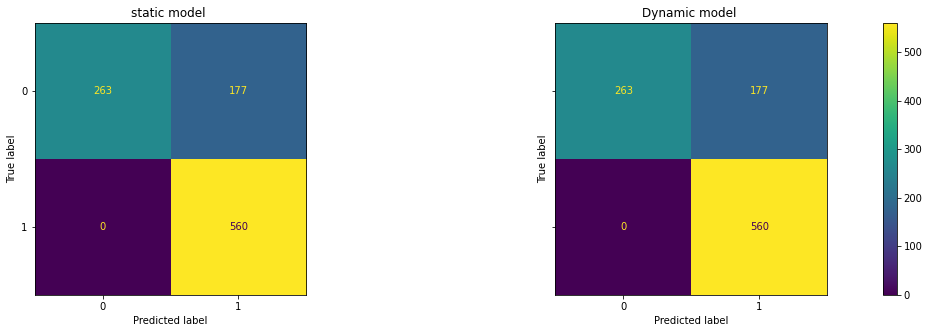

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 12
After getting the data from the window : the f1-score of the static  model= 0.8598 
After getting the data from the window : the f1-score of the Dynamic model= 0.8598 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.98      0.59      0.74       437
           1       0.76      0.99      0.86       563

    accuracy                           0.82      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.98      0.59      0.74       437
           1       0.76      0.99      0.86       563

    accuracy                           0.82      1000
   macro avg       0.87      

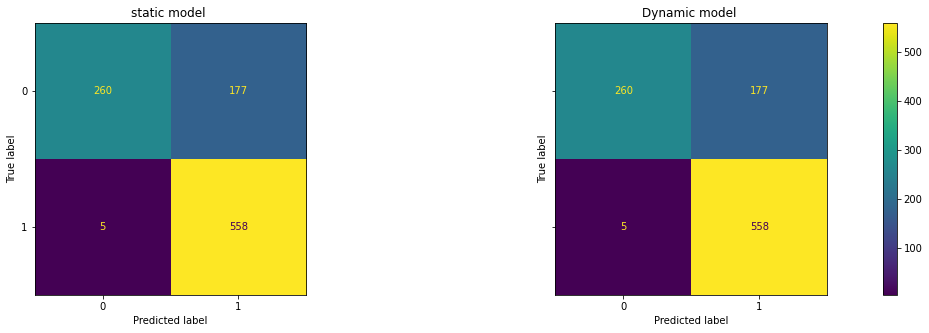

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 13
After getting the data from the window : the f1-score of the static  model= 0.8545 
After getting the data from the window : the f1-score of the Dynamic model= 0.8536 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       447
           1       0.75      1.00      0.85       553

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.58      0.73       447
           1       0.75      1.00      0.85       553

    accuracy                           0.81      1000
   macro avg       0.87      

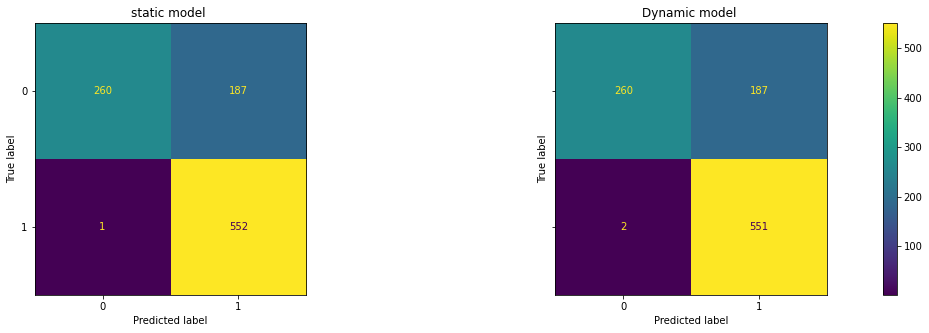

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 14
After getting the data from the window : the f1-score of the static  model= 0.8493 
After getting the data from the window : the f1-score of the Dynamic model= 0.8493 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       456
           1       0.74      1.00      0.85       544

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       456
           1       0.74      1.00      0.85       544

    accuracy                           0.81      1000
   macro avg       0.87      

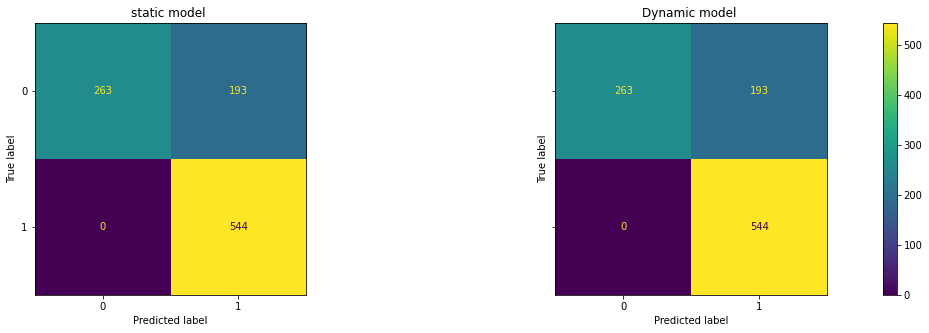

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8493
window : 15
After getting the data from the window : the f1-score of the static  model= 0.8604 
After getting the data from the window : the f1-score of the Dynamic model= 0.8604 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       442
           1       0.76      1.00      0.86       558

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       442
           1       0.76      1.00      0.86       558

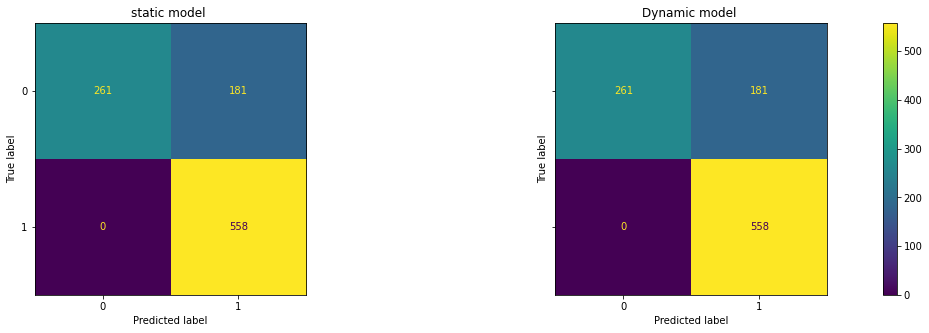

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 16
After getting the data from the window : the f1-score of the static  model= 0.8576 
After getting the data from the window : the f1-score of the Dynamic model= 0.8576 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       446
           1       0.75      1.00      0.86       554

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       446
           1       0.75      1.00      0.86       554

    accuracy                           0.82      1000
   macro avg       0.88      

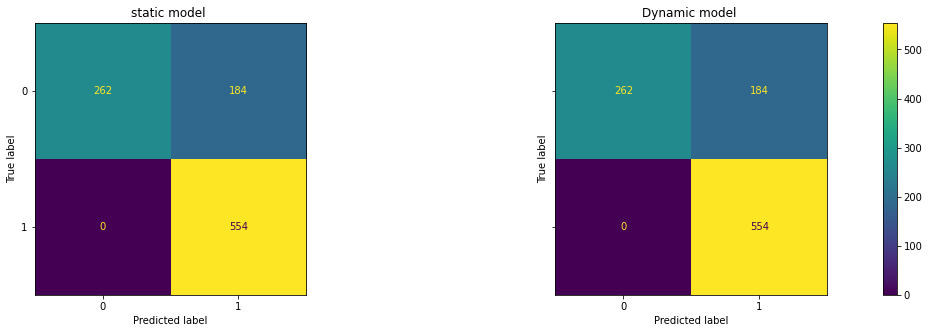

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 17
After getting the data from the window : the f1-score of the static  model= 0.8404 
After getting the data from the window : the f1-score of the Dynamic model= 0.8404 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       468
           1       0.72      1.00      0.84       532

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       468
           1       0.72      1.00      0.84       532

    accuracy                           0.80      1000
   macro avg       0.86      

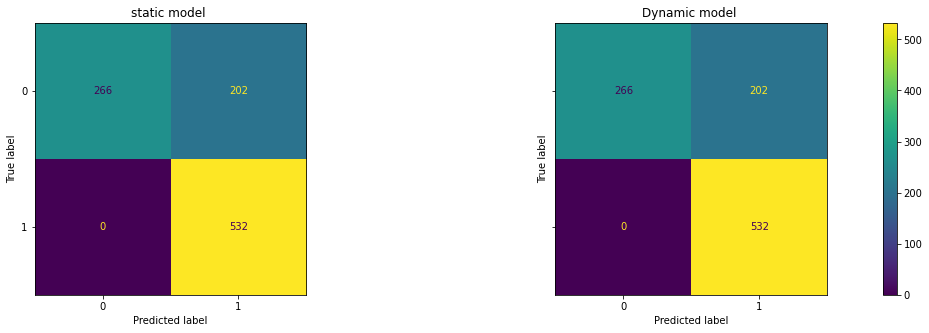

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8404
window : 18
After getting the data from the window : the f1-score of the static  model= 0.8398 
After getting the data from the window : the f1-score of the Dynamic model= 0.8407 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.55      0.71       458
           1       0.73      1.00      0.84       542

    accuracy                           0.79      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.79      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       458
           1       0.73      1.00      0.84       542

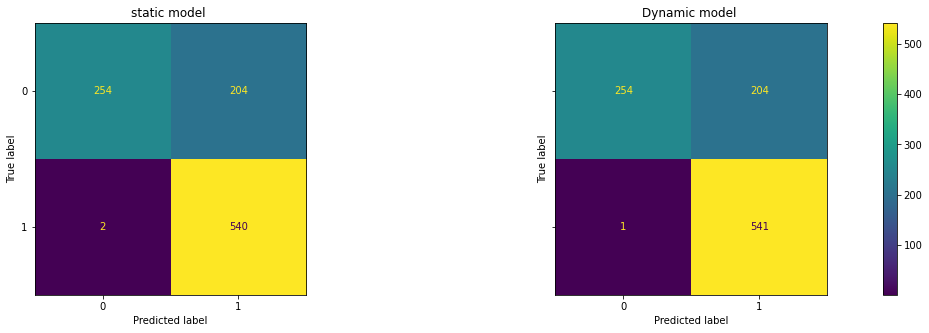

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8407
window : 19
After getting the data from the window : the f1-score of the static  model= 0.8718 
After getting the data from the window : the f1-score of the Dynamic model= 0.8711 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       429
           1       0.77      1.00      0.87       571

    accuracy                           0.83      1000
   macro avg       0.89      0.80      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       429
           1       0.77      1.00      0.87       571

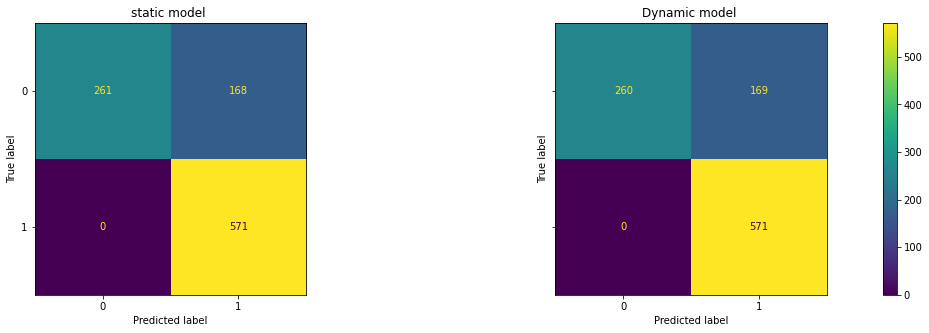

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 20
After getting the data from the window : the f1-score of the static  model= 0.8729 
After getting the data from the window : the f1-score of the Dynamic model= 0.8729 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       406
           1       0.77      1.00      0.87       594

    accuracy                           0.83      1000
   macro avg       0.89      0.79      0.80      1000
weighted avg       0.87      0.83      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       406
           1       0.77      1.00      0.87       594

    accuracy                           0.83      1000
   macro avg       0.89      

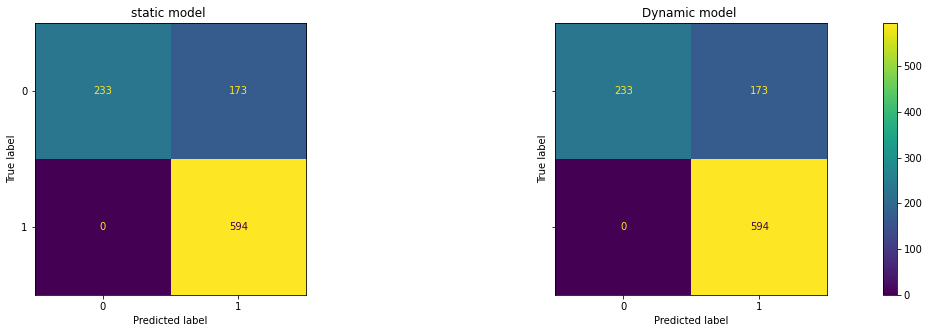

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 21
After getting the data from the window : the f1-score of the static  model= 0.8457 
After getting the data from the window : the f1-score of the Dynamic model= 0.8457 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       470
           1       0.73      1.00      0.85       530

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       470
           1       0.73      1.00      0.85       530

    accuracy                           0.81      1000
   macro avg       0.87      

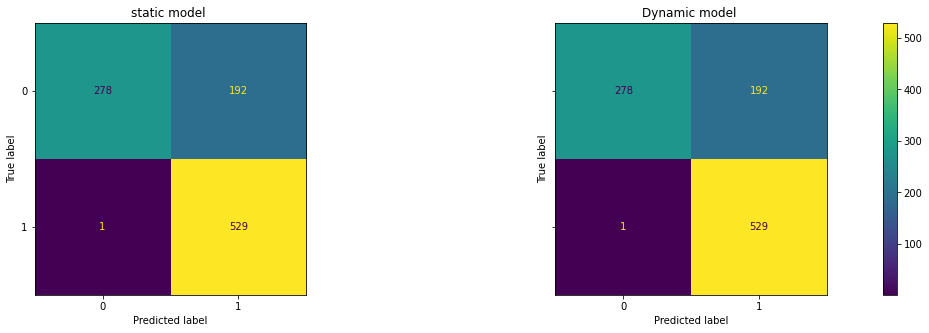

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8457
window : 22
After getting the data from the window : the f1-score of the static  model= 0.8589 
After getting the data from the window : the f1-score of the Dynamic model= 0.8598 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       453
           1       0.75      1.00      0.86       547

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.81      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       453
           1       0.76      1.00      0.86       547

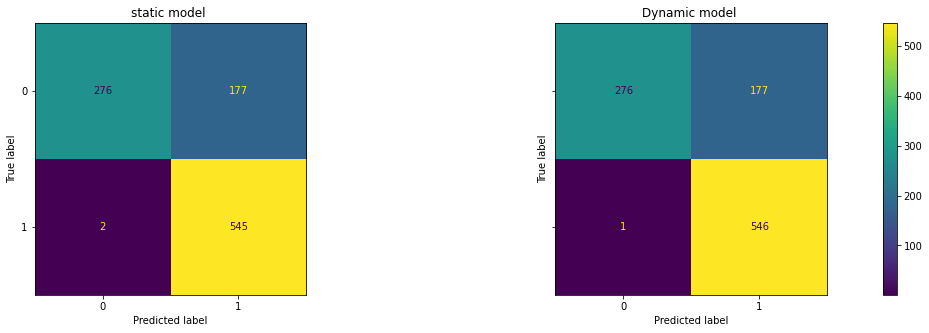

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 23
After getting the data from the window : the f1-score of the static  model= 0.8490 
After getting the data from the window : the f1-score of the Dynamic model= 0.8490 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       449
           1       0.74      1.00      0.85       551

    accuracy                           0.80      1000
   macro avg       0.87      0.78      0.78      1000
weighted avg       0.86      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       449
           1       0.74      1.00      0.85       551

    accuracy                           0.80      1000
   macro avg       0.87      

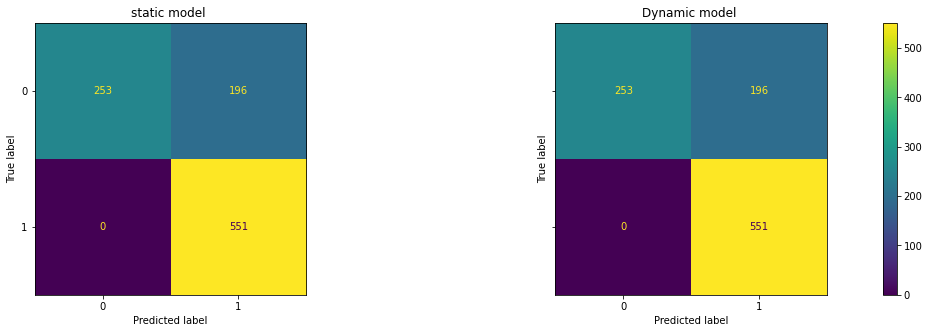

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8490
window : 24
After getting the data from the window : the f1-score of the static  model= 0.8567 
After getting the data from the window : the f1-score of the Dynamic model= 0.8567 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       451
           1       0.75      1.00      0.86       549

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       451
           1       0.75      1.00      0.86       549

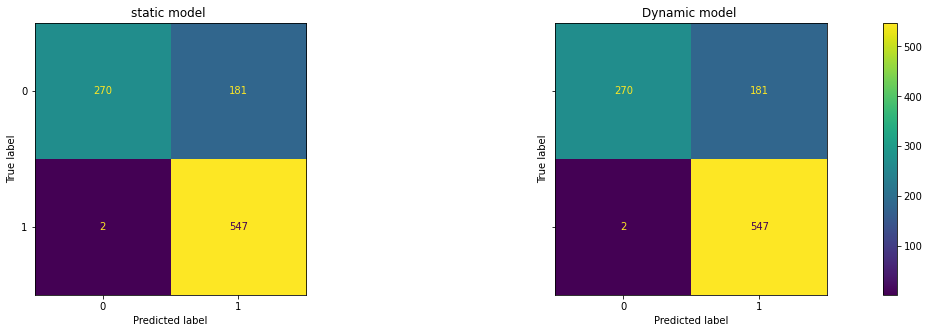

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 25
After getting the data from the window : the f1-score of the static  model= 0.8587 
After getting the data from the window : the f1-score of the Dynamic model= 0.8587 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       447
           1       0.75      1.00      0.86       553

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       447
           1       0.75      1.00      0.86       553

    accuracy                           0.82      1000
   macro avg       0.88      

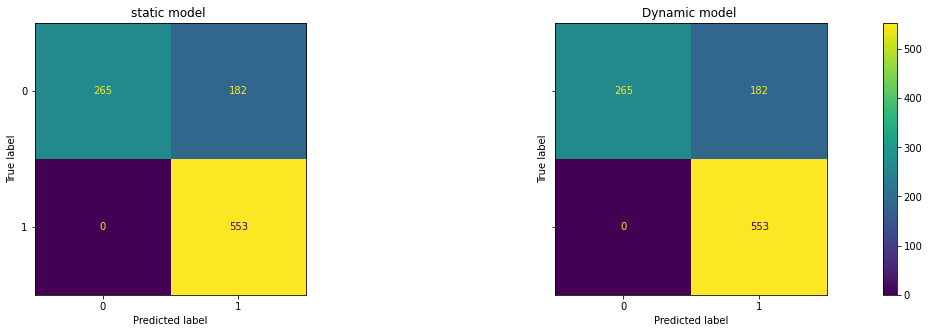

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 26
After getting the data from the window : the f1-score of the static  model= 0.8560 
After getting the data from the window : the f1-score of the Dynamic model= 0.8560 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       454
           1       0.75      1.00      0.86       546

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       454
           1       0.75      1.00      0.86       546

    accuracy                           0.82      1000
   macro avg       0.87      

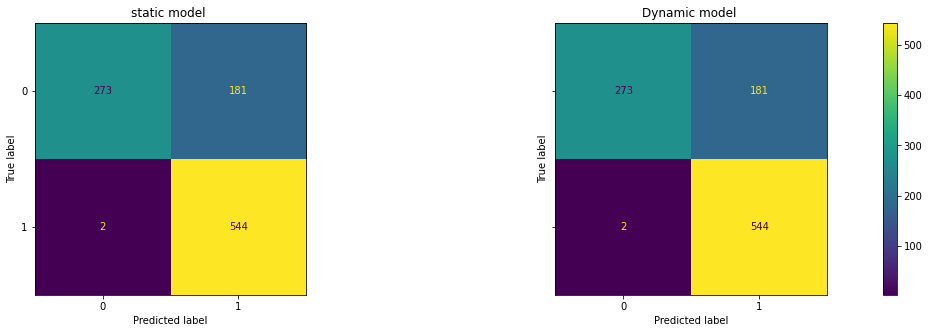

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 27
After getting the data from the window : the f1-score of the static  model= 0.8529 
After getting the data from the window : the f1-score of the Dynamic model= 0.8529 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       451
           1       0.74      1.00      0.85       549

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       451
           1       0.74      1.00      0.85       549

    accuracy                           0.81      1000
   macro avg       0.87      

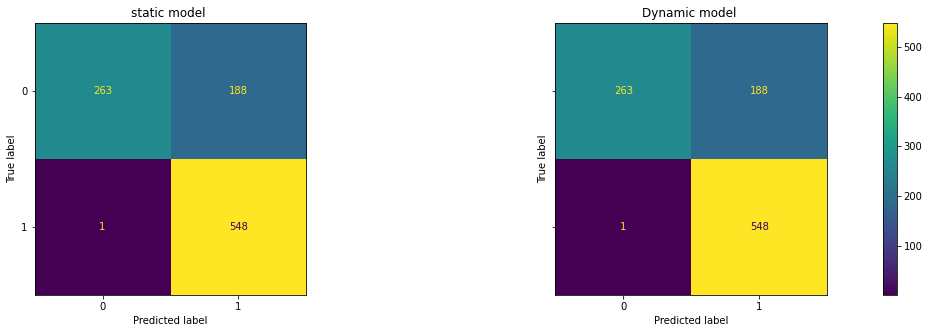

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 28
After getting the data from the window : the f1-score of the static  model= 0.8506 
After getting the data from the window : the f1-score of the Dynamic model= 0.8506 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       478
           1       0.74      1.00      0.85       522

    accuracy                           0.82      1000
   macro avg       0.87      0.81      0.81      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       478
           1       0.74      1.00      0.85       522

    accuracy                           0.82      1000
   macro avg       0.87      

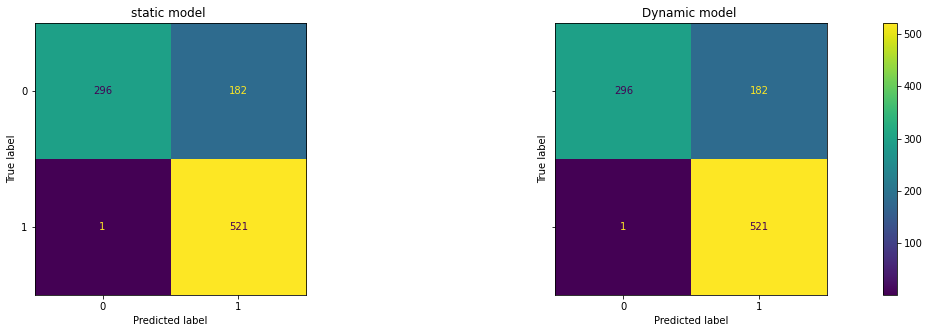

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 29
After getting the data from the window : the f1-score of the static  model= 0.8660 
After getting the data from the window : the f1-score of the Dynamic model= 0.8660 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       425
           1       0.76      1.00      0.87       575

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       425
           1       0.76      1.00      0.87       575

    accuracy                           0.82      1000
   macro avg       0.88      

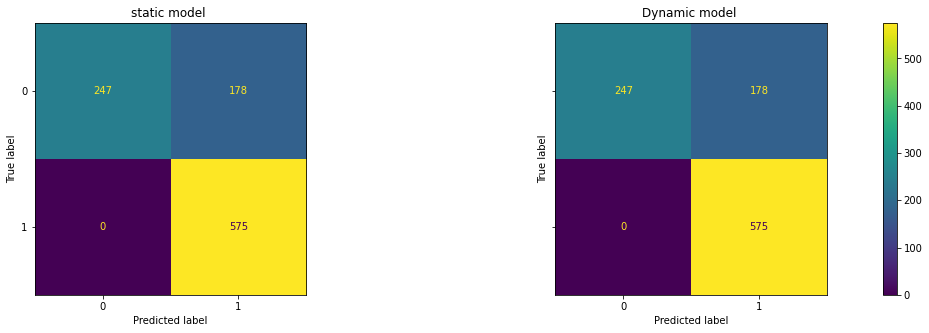

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 30
After getting the data from the window : the f1-score of the static  model= 0.8554 
After getting the data from the window : the f1-score of the Dynamic model= 0.8554 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.56      0.72       433
           1       0.75      1.00      0.86       567

    accuracy                           0.81      1000
   macro avg       0.87      0.78      0.79      1000
weighted avg       0.85      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.56      0.72       433
           1       0.75      1.00      0.86       567

    accuracy                           0.81      1000
   macro avg       0.87      

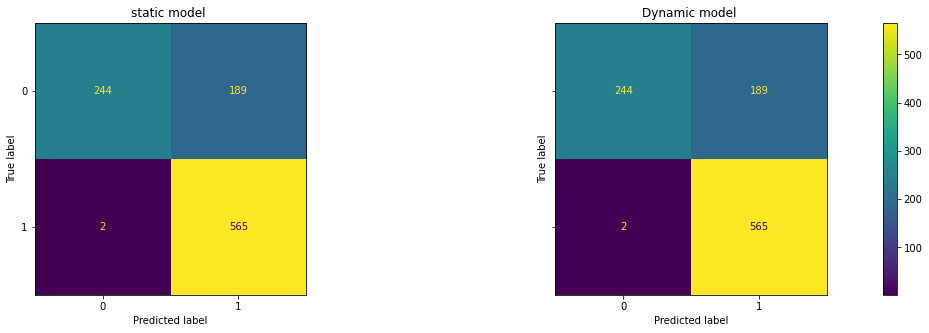

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 31
After getting the data from the window : the f1-score of the static  model= 0.8410 
After getting the data from the window : the f1-score of the Dynamic model= 0.8419 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       470
           1       0.73      1.00      0.84       530

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       470
           1       0.73      1.00      0.84       530

    accuracy                           0.80      1000
   macro avg       0.86      

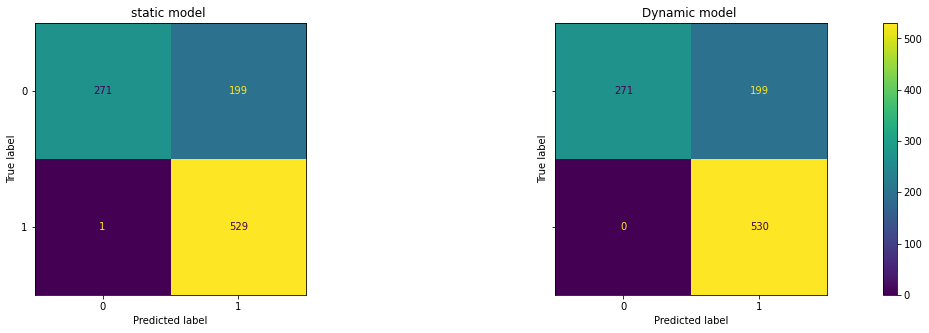

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8419
window : 32
After getting the data from the window : the f1-score of the static  model= 0.8245 
After getting the data from the window : the f1-score of the Dynamic model= 0.8245 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.56      0.71       486
           1       0.70      1.00      0.82       514

    accuracy                           0.78      1000
   macro avg       0.85      0.78      0.77      1000
weighted avg       0.84      0.78      0.77      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.56      0.71       486
           1       0.70      1.00      0.82       514

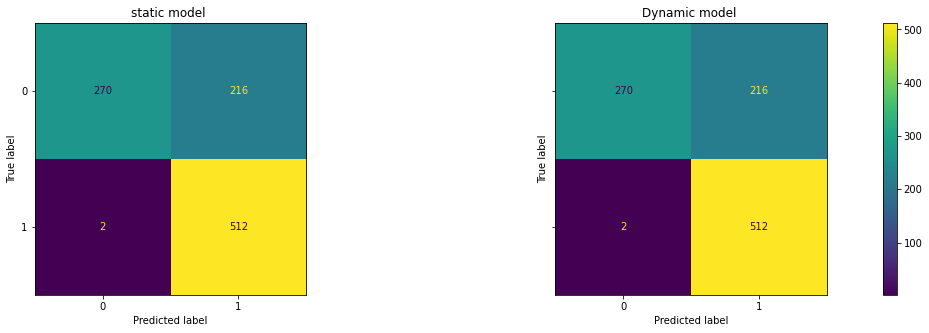

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8245
window : 33
After getting the data from the window : the f1-score of the static  model= 0.8667 
After getting the data from the window : the f1-score of the Dynamic model= 0.8667 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       457
           1       0.76      1.00      0.87       543

    accuracy                           0.83      1000
   macro avg       0.88      0.82      0.82      1000
weighted avg       0.87      0.83      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       457
           1       0.76      1.00      0.87       543

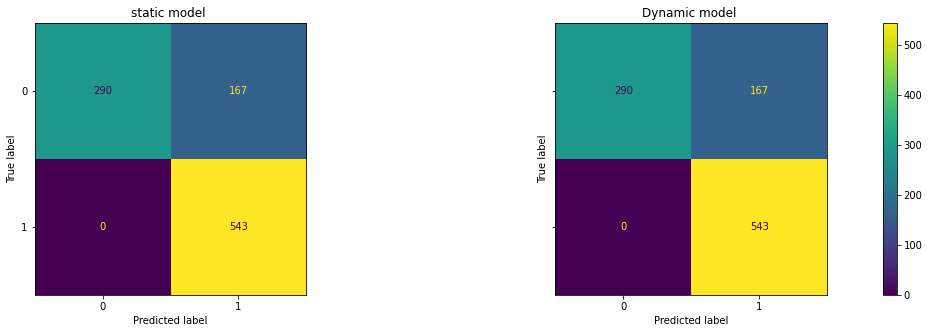

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 34
After getting the data from the window : the f1-score of the static  model= 0.8532 
After getting the data from the window : the f1-score of the Dynamic model= 0.8532 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       467
           1       0.75      1.00      0.85       533

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.81      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       467
           1       0.75      1.00      0.85       533

    accuracy                           0.82      1000
   macro avg       0.87      

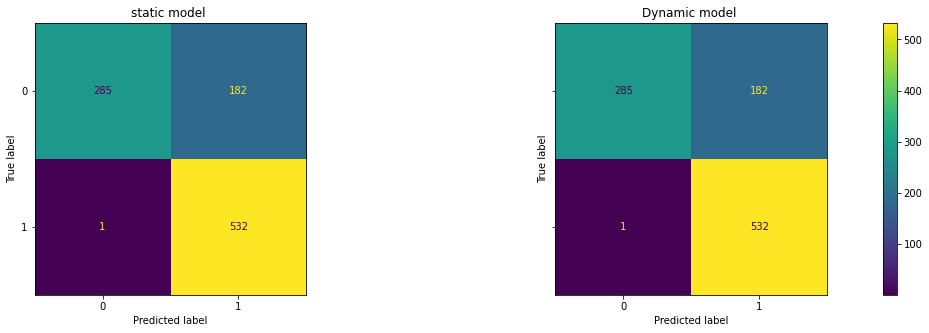

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 35
After getting the data from the window : the f1-score of the static  model= 0.8544 
After getting the data from the window : the f1-score of the Dynamic model= 0.8544 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       463
           1       0.75      1.00      0.85       537

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       463
           1       0.75      1.00      0.85       537

    accuracy                           0.82      1000
   macro avg       0.87      

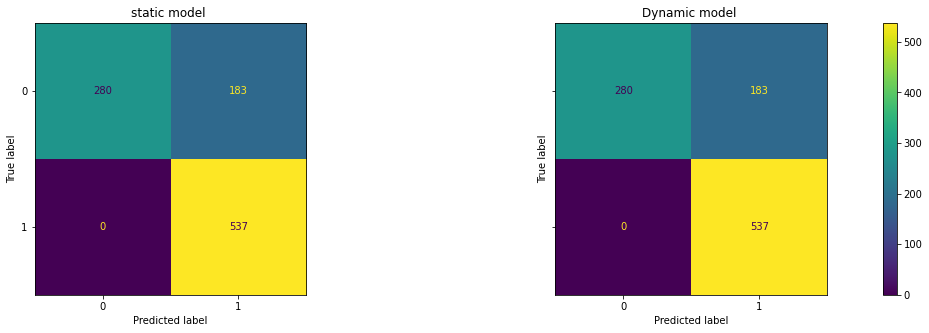

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 36
After getting the data from the window : the f1-score of the static  model= 0.8462 
After getting the data from the window : the f1-score of the Dynamic model= 0.8462 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       458
           1       0.73      1.00      0.85       542

    accuracy                           0.80      1000
   macro avg       0.87      0.78      0.79      1000
weighted avg       0.86      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       458
           1       0.73      1.00      0.85       542

    accuracy                           0.80      1000
   macro avg       0.87      

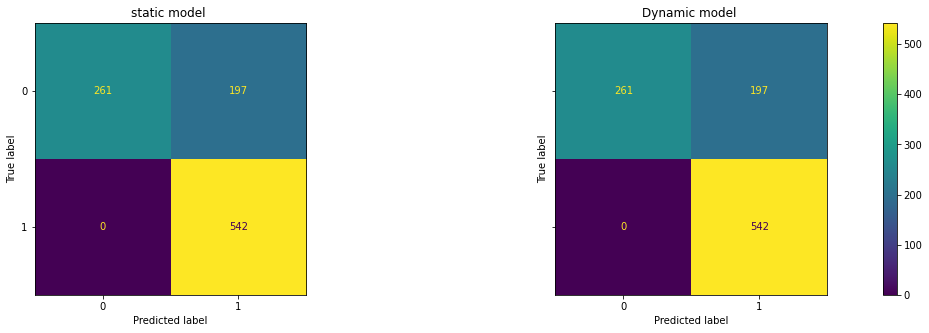

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8462
window : 37
After getting the data from the window : the f1-score of the static  model= 0.8785 
After getting the data from the window : the f1-score of the Dynamic model= 0.8779 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       424
           1       0.78      1.00      0.88       576

    accuracy                           0.84      1000
   macro avg       0.89      0.81      0.82      1000
weighted avg       0.87      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       424
           1       0.78      1.00      0.88       576

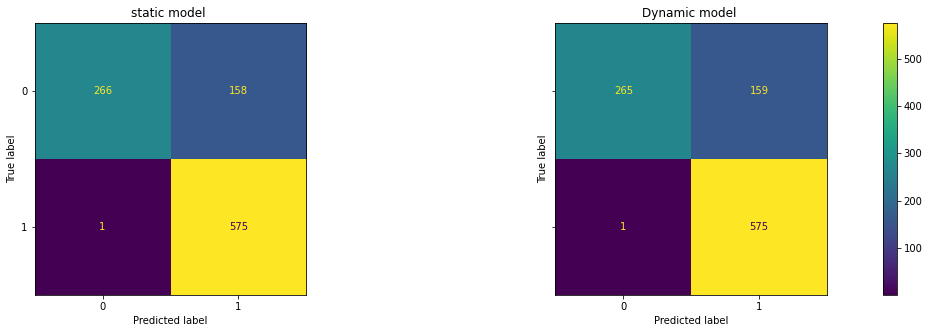

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 38
After getting the data from the window : the f1-score of the static  model= 0.8510 
After getting the data from the window : the f1-score of the Dynamic model= 0.8510 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       469
           1       0.74      1.00      0.85       531

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       469
           1       0.74      1.00      0.85       531

    accuracy                           0.81      1000
   macro avg       0.87      

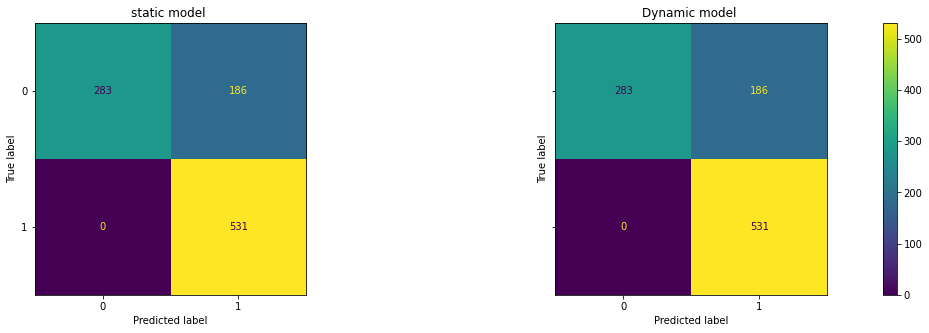

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 39
After getting the data from the window : the f1-score of the static  model= 0.8514 
After getting the data from the window : the f1-score of the Dynamic model= 0.8514 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       450
           1       0.74      1.00      0.85       550

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       450
           1       0.74      1.00      0.85       550

    accuracy                           0.81      1000
   macro avg       0.87      

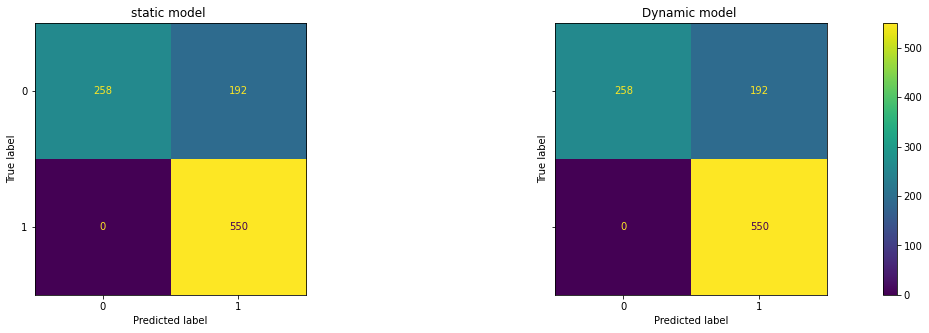

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 40
After getting the data from the window : the f1-score of the static  model= 0.8549 
After getting the data from the window : the f1-score of the Dynamic model= 0.8549 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       455
           1       0.75      0.99      0.85       545

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       455
           1       0.75      0.99      0.85       545

    accuracy                           0.82      1000
   macro avg       0.87      

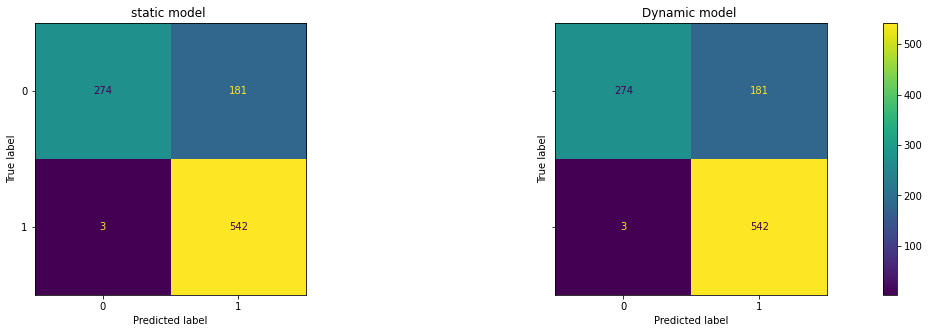

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 41
After getting the data from the window : the f1-score of the static  model= 0.8493 
After getting the data from the window : the f1-score of the Dynamic model= 0.8493 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       444
           1       0.74      1.00      0.85       556

    accuracy                           0.80      1000
   macro avg       0.87      0.78      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       444
           1       0.74      1.00      0.85       556

    accuracy                           0.80      1000
   macro avg       0.87      

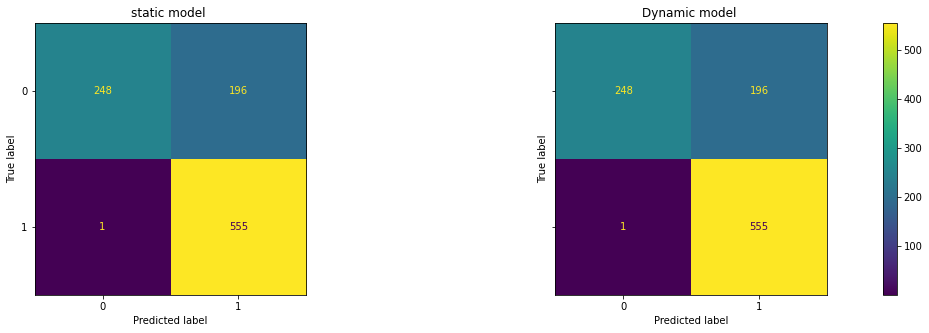

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8493
window : 42
After getting the data from the window : the f1-score of the static  model= 0.8613 
After getting the data from the window : the f1-score of the Dynamic model= 0.8613 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       432
           1       0.76      1.00      0.86       568

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       432
           1       0.76      1.00      0.86       568

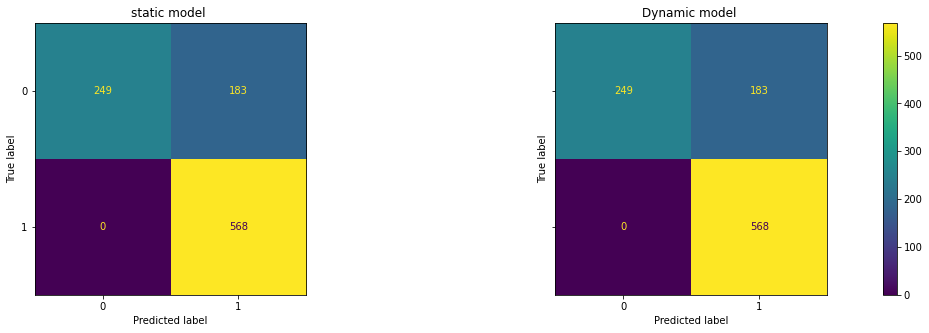

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 43
After getting the data from the window : the f1-score of the static  model= 0.8528 
After getting the data from the window : the f1-score of the Dynamic model= 0.8535 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       467
           1       0.74      1.00      0.85       533

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       467
           1       0.74      1.00      0.85       533

    accuracy                           0.82      1000
   macro avg       0.87      

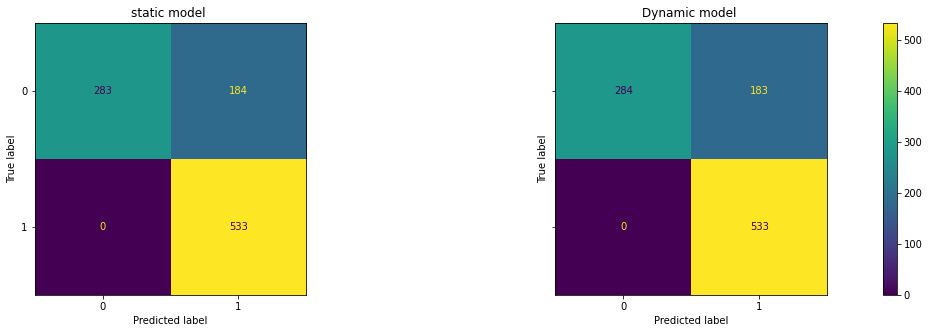

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 44
After getting the data from the window : the f1-score of the static  model= 0.8482 
After getting the data from the window : the f1-score of the Dynamic model= 0.8482 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       461
           1       0.74      1.00      0.85       539

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       461
           1       0.74      1.00      0.85       539

    accuracy                           0.81      1000
   macro avg       0.87      

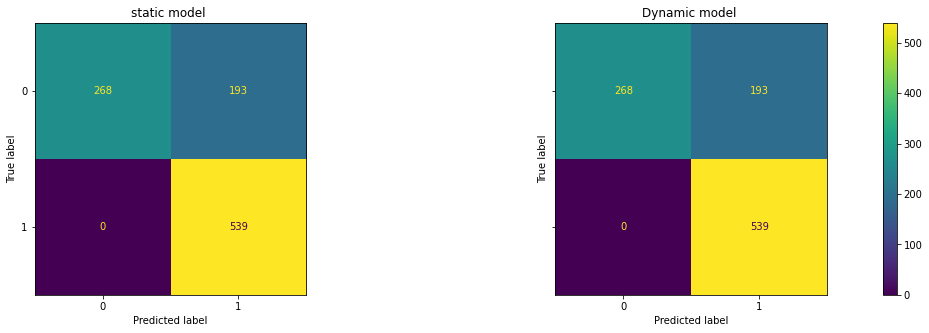

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8482
window : 45
After getting the data from the window : the f1-score of the static  model= 0.8558 
After getting the data from the window : the f1-score of the Dynamic model= 0.8567 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       447
           1       0.75      1.00      0.86       553

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       447
           1       0.75      1.00      0.86       553

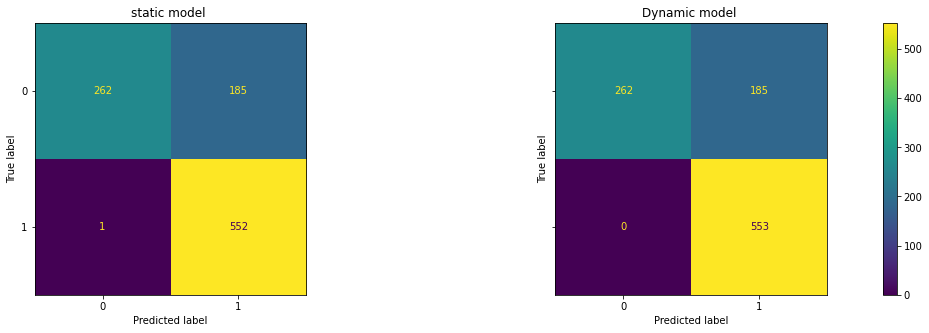

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 46
After getting the data from the window : the f1-score of the static  model= 0.8497 
After getting the data from the window : the f1-score of the Dynamic model= 0.8497 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       460
           1       0.74      1.00      0.85       540

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       460
           1       0.74      1.00      0.85       540

    accuracy                           0.81      1000
   macro avg       0.87      

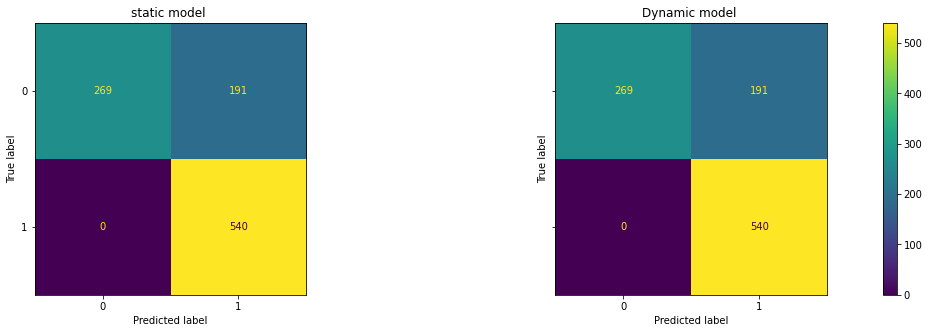

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8497
window : 47
After getting the data from the window : the f1-score of the static  model= 0.8571 
After getting the data from the window : the f1-score of the Dynamic model= 0.8571 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       430
           1       0.75      1.00      0.86       570

    accuracy                           0.81      1000
   macro avg       0.88      0.78      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       430
           1       0.75      1.00      0.86       570

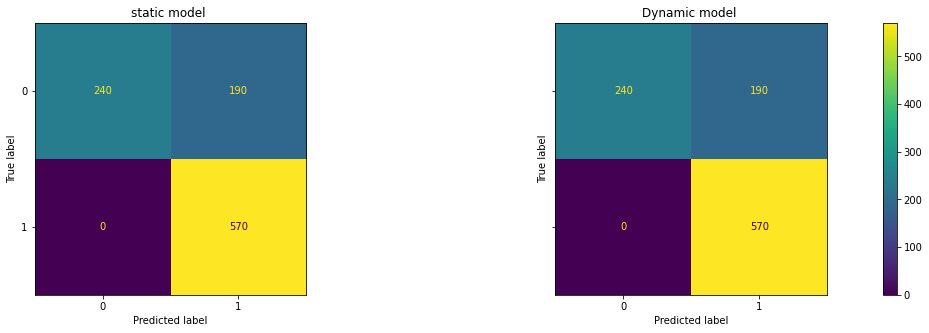

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 48
After getting the data from the window : the f1-score of the static  model= 0.8664 
After getting the data from the window : the f1-score of the Dynamic model= 0.8671 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       451
           1       0.77      1.00      0.87       549

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.82      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       451
           1       0.77      1.00      0.87       549

    accuracy                           0.83      1000
   macro avg       0.88      

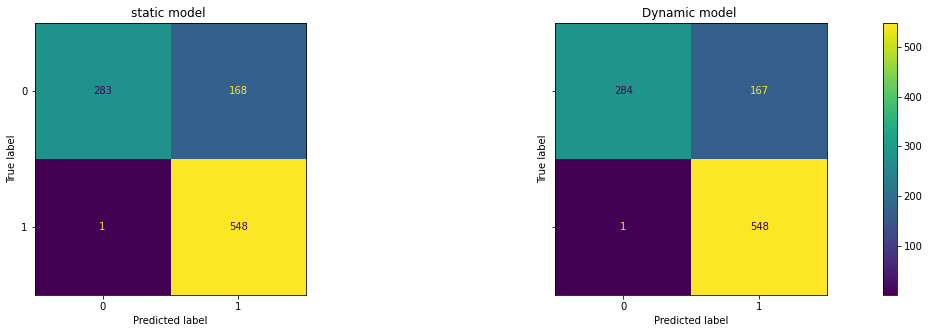

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 49
After getting the data from the window : the f1-score of the static  model= 0.8533 
After getting the data from the window : the f1-score of the Dynamic model= 0.8533 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       458
           1       0.75      1.00      0.85       542

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       458
           1       0.75      1.00      0.85       542

    accuracy                           0.81      1000
   macro avg       0.87      

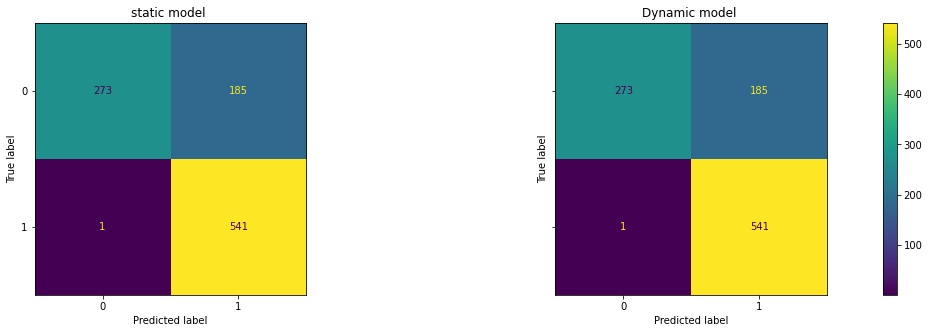

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 50
After getting the data from the window : the f1-score of the static  model= 0.8611 
After getting the data from the window : the f1-score of the Dynamic model= 0.8611 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       439
           1       0.76      1.00      0.86       561

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       439
           1       0.76      1.00      0.86       561

    accuracy                           0.82      1000
   macro avg       0.88      

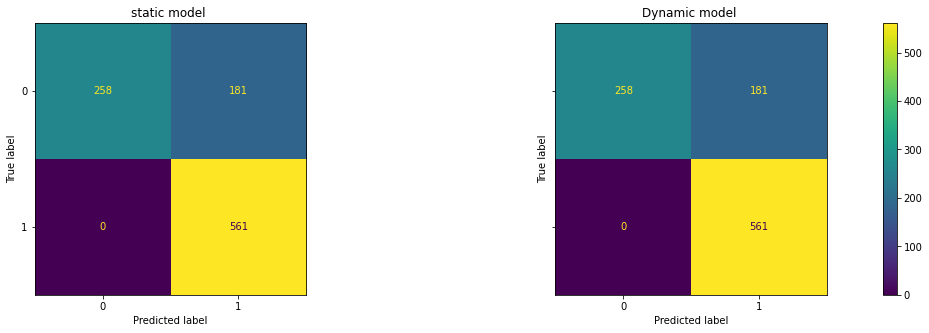

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 51
After getting the data from the window : the f1-score of the static  model= 0.8373 
After getting the data from the window : the f1-score of the Dynamic model= 0.8367 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       474
           1       0.72      1.00      0.84       526

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       474
           1       0.72      1.00      0.84       526

    accuracy                           0.80      1000
   macro avg       0.86      

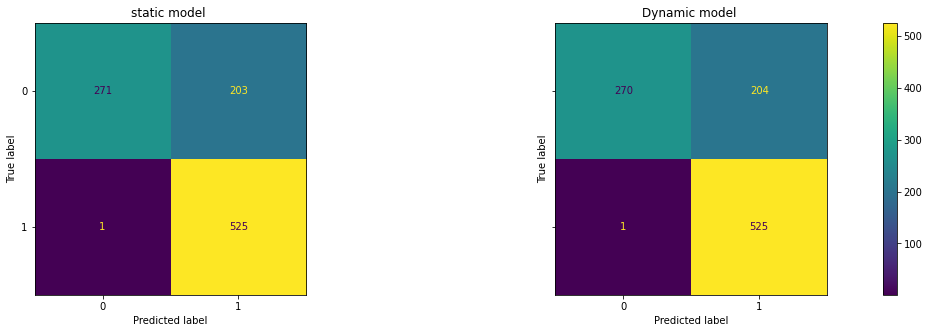

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8367
window : 52
After getting the data from the window : the f1-score of the static  model= 0.8574 
After getting the data from the window : the f1-score of the Dynamic model= 0.8574 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       450
           1       0.75      1.00      0.86       550

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       450
           1       0.75      1.00      0.86       550

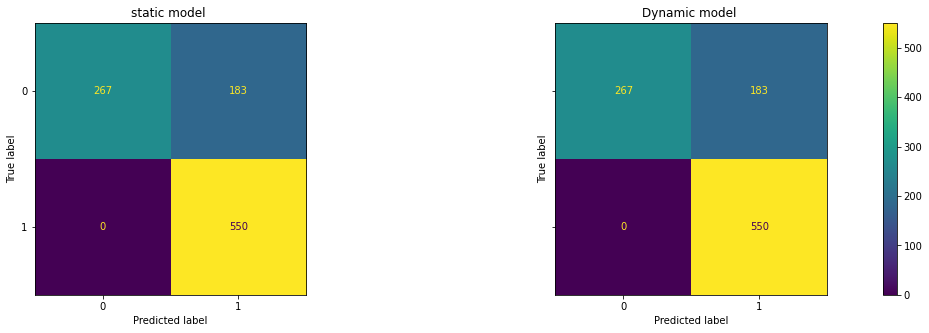

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 53
After getting the data from the window : the f1-score of the static  model= 0.8523 
After getting the data from the window : the f1-score of the Dynamic model= 0.8523 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       452
           1       0.74      1.00      0.85       548

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       452
           1       0.74      1.00      0.85       548

    accuracy                           0.81      1000
   macro avg       0.87      

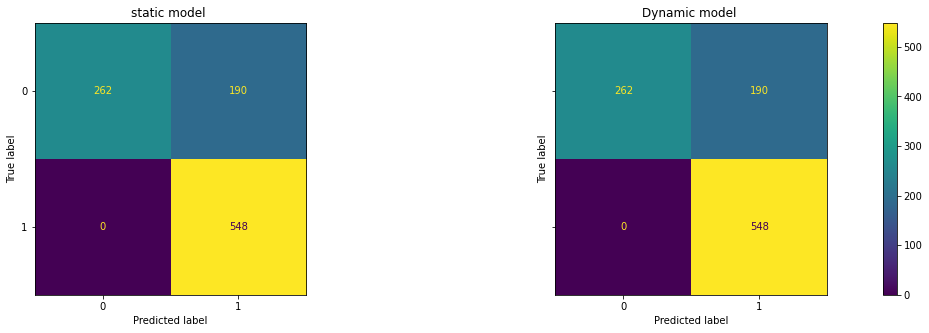

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 54
After getting the data from the window : the f1-score of the static  model= 0.8394 
After getting the data from the window : the f1-score of the Dynamic model= 0.8394 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       483
           1       0.73      1.00      0.84       517

    accuracy                           0.80      1000
   macro avg       0.86      0.80      0.79      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       483
           1       0.73      1.00      0.84       517

    accuracy                           0.80      1000
   macro avg       0.86      

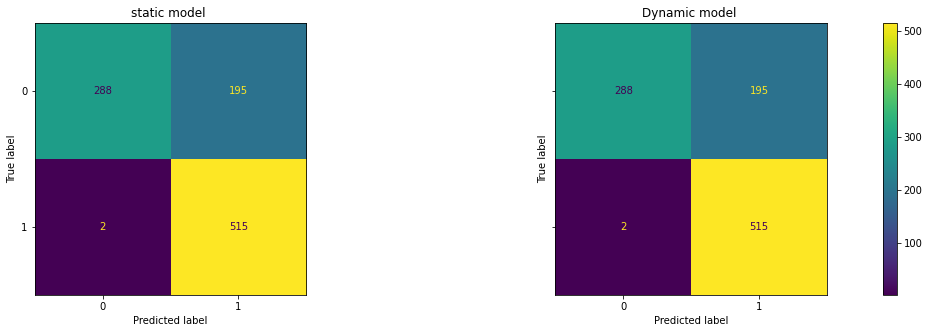

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8394
window : 55
After getting the data from the window : the f1-score of the static  model= 0.8459 
After getting the data from the window : the f1-score of the Dynamic model= 0.8459 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.56      0.72       452
           1       0.73      1.00      0.85       548

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.56      0.72       452
           1       0.73      1.00      0.85       548

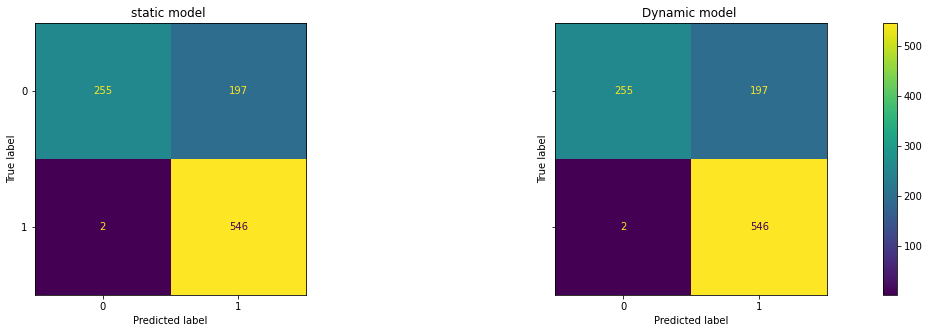

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8459
window : 56
After getting the data from the window : the f1-score of the static  model= 0.8418 
After getting the data from the window : the f1-score of the Dynamic model= 0.8418 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.75       481
           1       0.73      1.00      0.84       519

    accuracy                           0.81      1000
   macro avg       0.86      0.80      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.75       481
           1       0.73      1.00      0.84       519

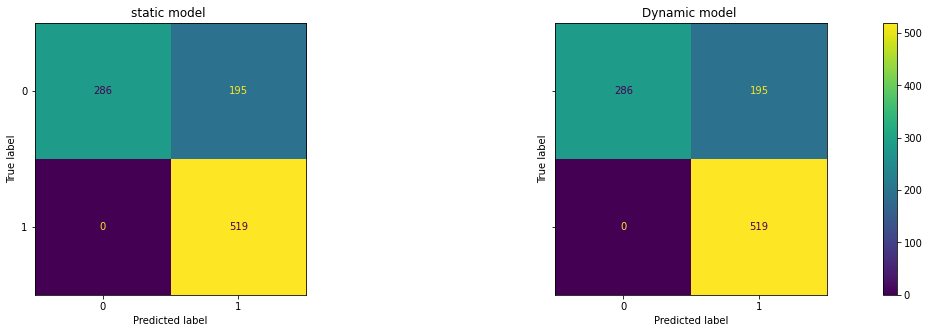

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8418
window : 57
After getting the data from the window : the f1-score of the static  model= 0.8571 
After getting the data from the window : the f1-score of the Dynamic model= 0.8571 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       436
           1       0.75      1.00      0.86       564

    accuracy                           0.81      1000
   macro avg       0.88      0.78      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       436
           1       0.75      1.00      0.86       564

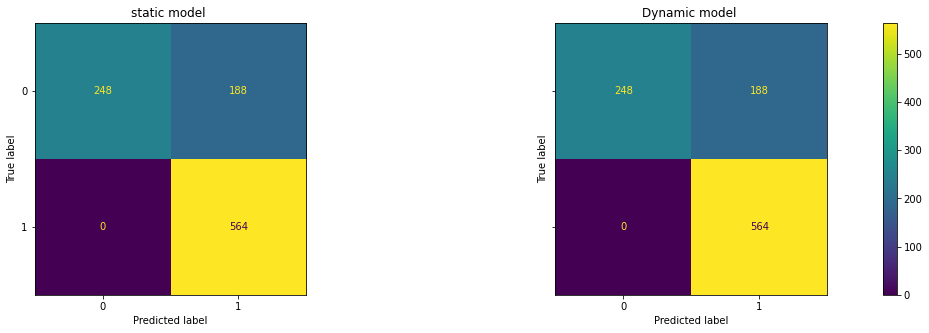

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 58
After getting the data from the window : the f1-score of the static  model= 0.8790 
After getting the data from the window : the f1-score of the Dynamic model= 0.8790 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       430
           1       0.78      1.00      0.88       570

    accuracy                           0.84      1000
   macro avg       0.89      0.82      0.83      1000
weighted avg       0.88      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       430
           1       0.78      1.00      0.88       570

    accuracy                           0.84      1000
   macro avg       0.89      

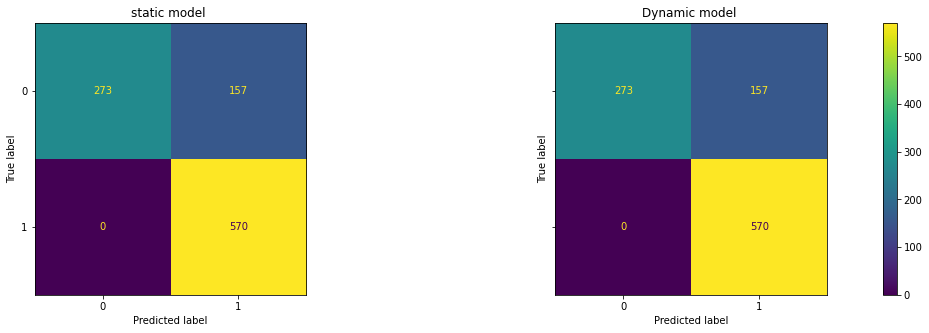

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 59
After getting the data from the window : the f1-score of the static  model= 0.8720 
After getting the data from the window : the f1-score of the Dynamic model= 0.8720 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       430
           1       0.77      1.00      0.87       570

    accuracy                           0.83      1000
   macro avg       0.89      0.81      0.82      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       430
           1       0.77      1.00      0.87       570

    accuracy                           0.83      1000
   macro avg       0.89      

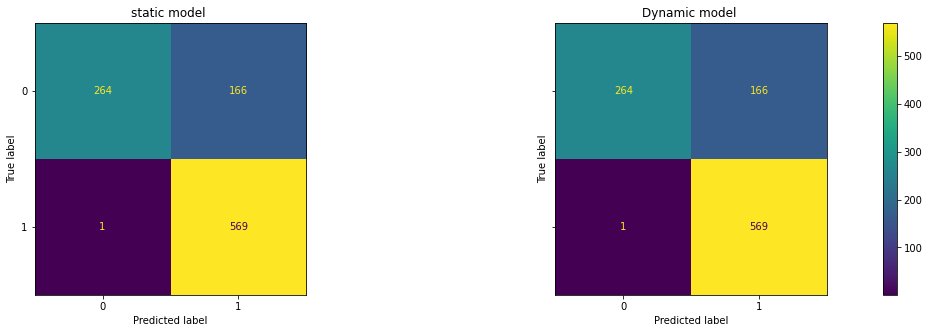

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 60
After getting the data from the window : the f1-score of the static  model= 0.8602 
After getting the data from the window : the f1-score of the Dynamic model= 0.8602 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       442
           1       0.76      1.00      0.86       558

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       442
           1       0.76      1.00      0.86       558

    accuracy                           0.82      1000
   macro avg       0.88      

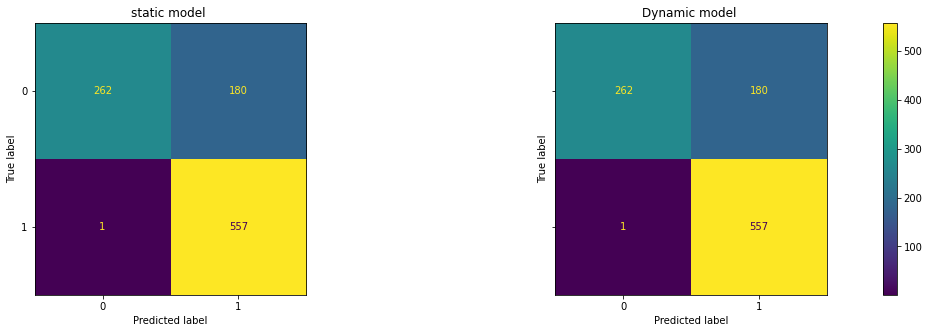

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 61
After getting the data from the window : the f1-score of the static  model= 0.8433 
After getting the data from the window : the f1-score of the Dynamic model= 0.8440 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       475
           1       0.73      0.99      0.84       525

    accuracy                           0.81      1000
   macro avg       0.86      0.80      0.79      1000
weighted avg       0.85      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       475
           1       0.73      0.99      0.84       525

    accuracy                           0.81      1000
   macro avg       0.86      

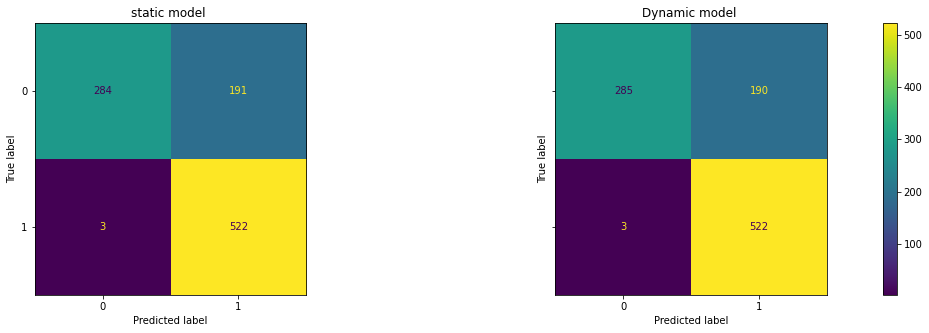

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8440
window : 62
After getting the data from the window : the f1-score of the static  model= 0.8482 
After getting the data from the window : the f1-score of the Dynamic model= 0.8482 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       458
           1       0.74      1.00      0.85       542

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       458
           1       0.74      1.00      0.85       542

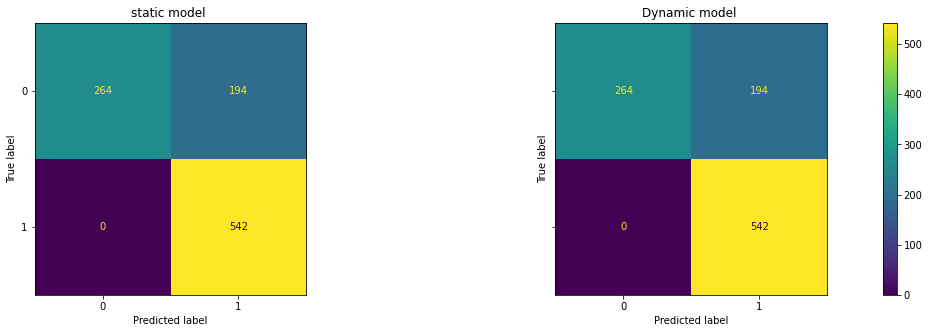

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8482
window : 63
After getting the data from the window : the f1-score of the static  model= 0.8589 
After getting the data from the window : the f1-score of the Dynamic model= 0.8589 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       443
           1       0.75      1.00      0.86       557

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       443
           1       0.75      1.00      0.86       557

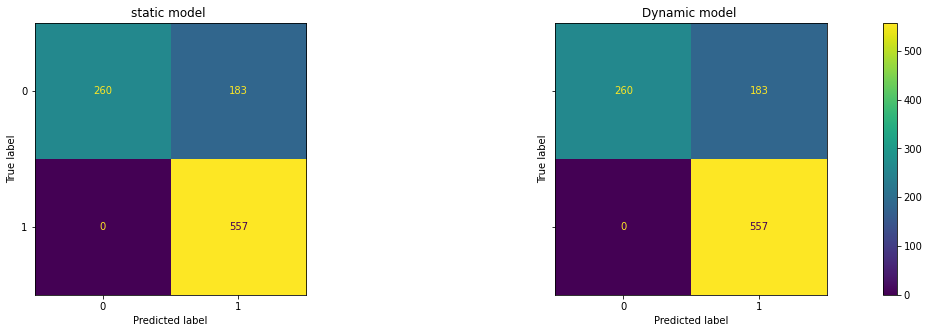

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 64
After getting the data from the window : the f1-score of the static  model= 0.8499 
After getting the data from the window : the f1-score of the Dynamic model= 0.8499 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       448
           1       0.74      1.00      0.85       552

    accuracy                           0.81      1000
   macro avg       0.87      0.78      0.79      1000
weighted avg       0.86      0.81      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       448
           1       0.74      1.00      0.85       552

    accuracy                           0.81      1000
   macro avg       0.87      

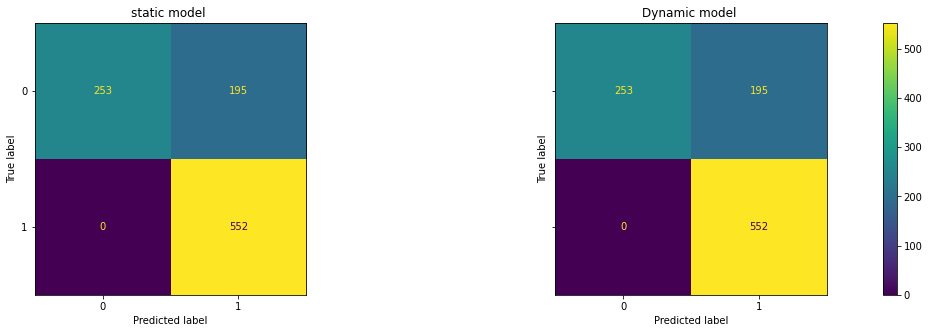

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8499
window : 65
After getting the data from the window : the f1-score of the static  model= 0.8430 
After getting the data from the window : the f1-score of the Dynamic model= 0.8430 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       463
           1       0.73      1.00      0.84       537

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       463
           1       0.73      1.00      0.84       537

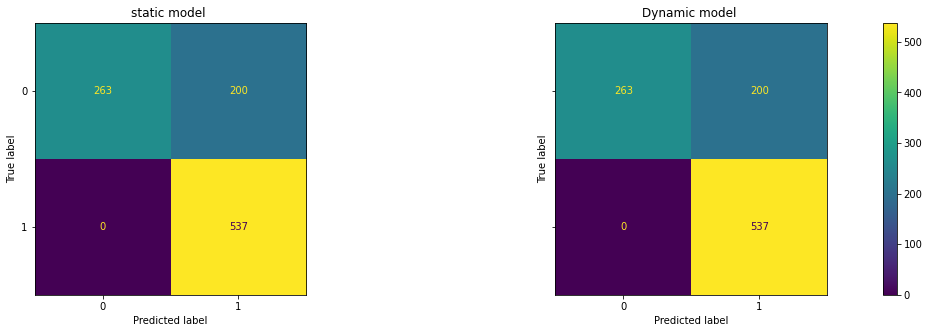

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8430
window : 66
After getting the data from the window : the f1-score of the static  model= 0.8671 
After getting the data from the window : the f1-score of the Dynamic model= 0.8671 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       452
           1       0.77      1.00      0.87       548

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.82      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       452
           1       0.77      1.00      0.87       548

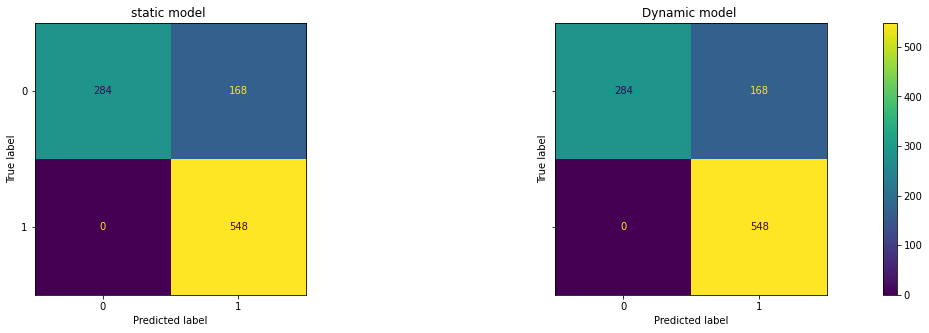

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 67
After getting the data from the window : the f1-score of the static  model= 0.8495 
After getting the data from the window : the f1-score of the Dynamic model= 0.8495 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       458
           1       0.74      1.00      0.85       542

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       458
           1       0.74      1.00      0.85       542

    accuracy                           0.81      1000
   macro avg       0.87      

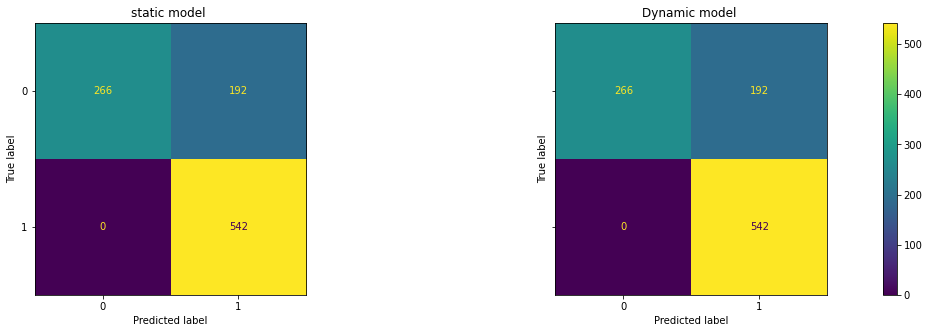

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8495
window : 68
After getting the data from the window : the f1-score of the static  model= 0.8540 
After getting the data from the window : the f1-score of the Dynamic model= 0.8549 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       449
           1       0.75      1.00      0.85       551

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       449
           1       0.75      1.00      0.85       551

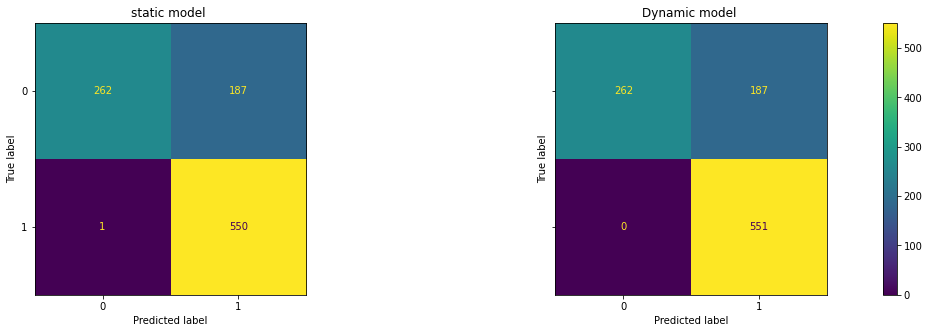

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 69
After getting the data from the window : the f1-score of the static  model= 0.8536 
After getting the data from the window : the f1-score of the Dynamic model= 0.8545 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.58      0.73       447
           1       0.75      1.00      0.85       553

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       447
           1       0.75      1.00      0.85       553

    accuracy                           0.81      1000
   macro avg       0.87      

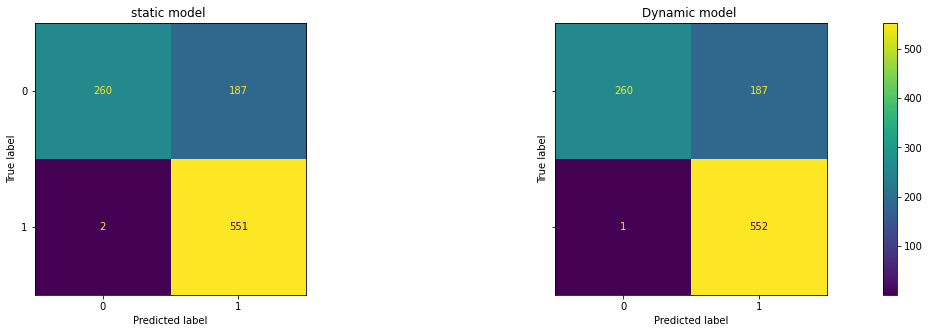

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 70
After getting the data from the window : the f1-score of the static  model= 0.8665 
After getting the data from the window : the f1-score of the Dynamic model= 0.8665 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       445
           1       0.76      1.00      0.87       555

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       445
           1       0.76      1.00      0.87       555

    accuracy                           0.83      1000
   macro avg       0.88      

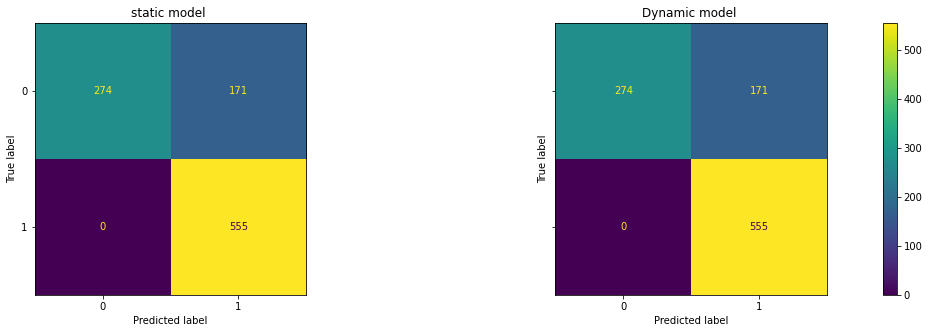

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 71
After getting the data from the window : the f1-score of the static  model= 0.8569 
After getting the data from the window : the f1-score of the Dynamic model= 0.8569 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       452
           1       0.75      1.00      0.86       548

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       452
           1       0.75      1.00      0.86       548

    accuracy                           0.82      1000
   macro avg       0.87      

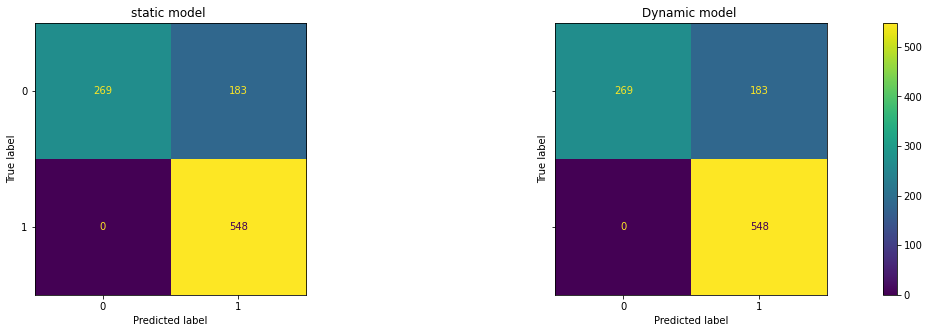

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 72
After getting the data from the window : the f1-score of the static  model= 0.8567 
After getting the data from the window : the f1-score of the Dynamic model= 0.8567 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       438
           1       0.75      1.00      0.86       562

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       438
           1       0.75      1.00      0.86       562

    accuracy                           0.81      1000
   macro avg       0.87      

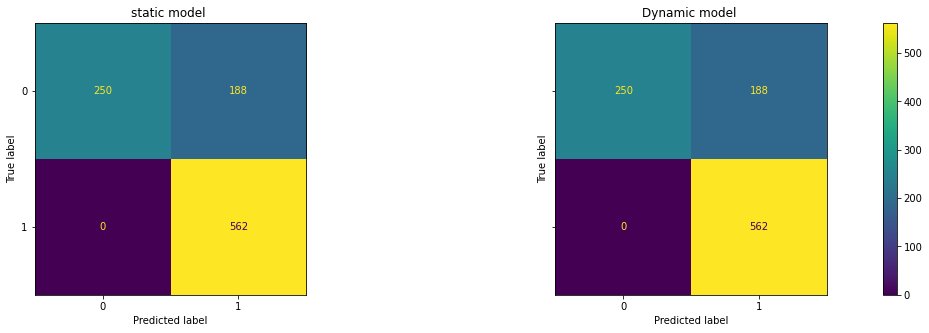

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 73
After getting the data from the window : the f1-score of the static  model= 0.8504 
After getting the data from the window : the f1-score of the Dynamic model= 0.8497 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       460
           1       0.74      1.00      0.85       540

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       460
           1       0.74      1.00      0.85       540

    accuracy                           0.81      1000
   macro avg       0.87      

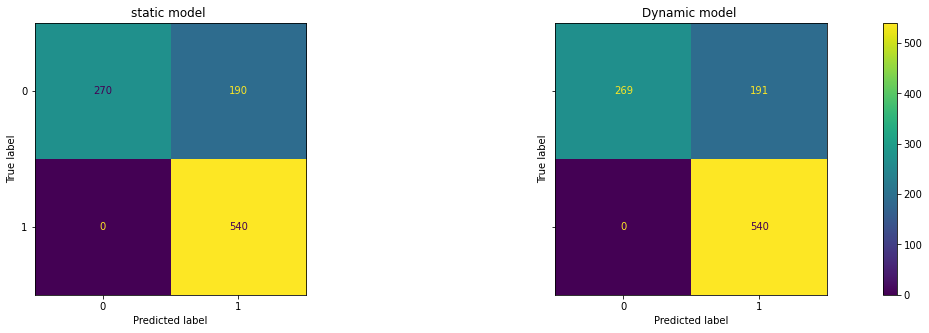

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8497
window : 74
After getting the data from the window : the f1-score of the static  model= 0.8554 
After getting the data from the window : the f1-score of the Dynamic model= 0.8554 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       444
           1       0.75      1.00      0.86       556

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       444
           1       0.75      1.00      0.86       556

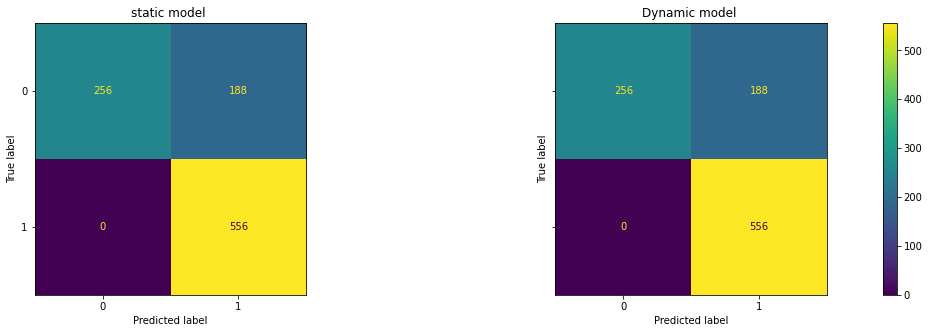

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 75
After getting the data from the window : the f1-score of the static  model= 0.8423 
After getting the data from the window : the f1-score of the Dynamic model= 0.8423 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       465
           1       0.73      1.00      0.84       535

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       465
           1       0.73      1.00      0.84       535

    accuracy                           0.80      1000
   macro avg       0.86      

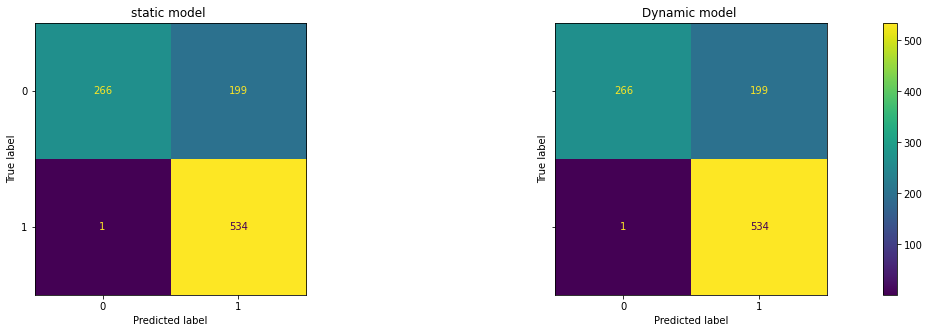

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8423
window : 76
After getting the data from the window : the f1-score of the static  model= 0.8512 
After getting the data from the window : the f1-score of the Dynamic model= 0.8512 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       450
           1       0.74      1.00      0.85       550

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       450
           1       0.74      1.00      0.85       550

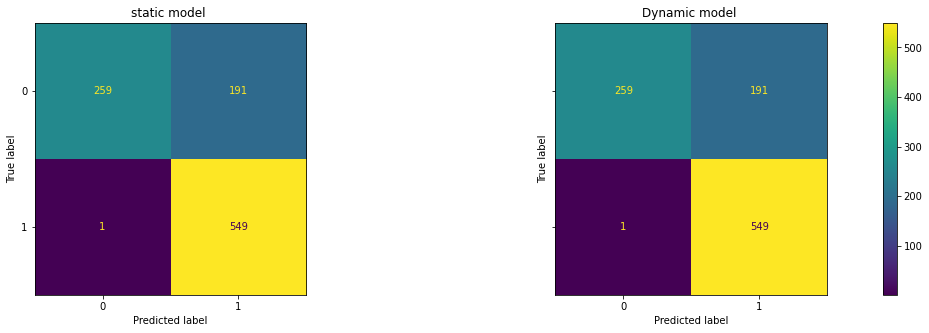

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 77
After getting the data from the window : the f1-score of the static  model= 0.8461 
After getting the data from the window : the f1-score of the Dynamic model= 0.8461 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.52      0.68       431
           1       0.73      1.00      0.85       569

    accuracy                           0.79      1000
   macro avg       0.87      0.76      0.77      1000
weighted avg       0.85      0.79      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.52      0.68       431
           1       0.73      1.00      0.85       569

    accuracy                           0.79      1000
   macro avg       0.87      

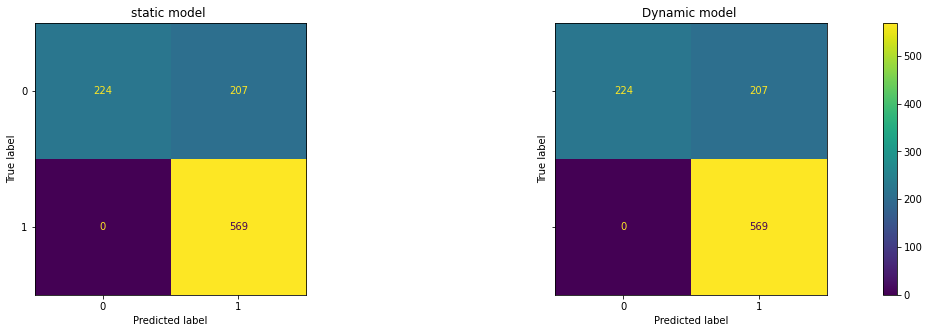

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8461
window : 78
After getting the data from the window : the f1-score of the static  model= 0.8634 
After getting the data from the window : the f1-score of the Dynamic model= 0.8634 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       427
           1       0.76      1.00      0.86       573

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       427
           1       0.76      1.00      0.86       573

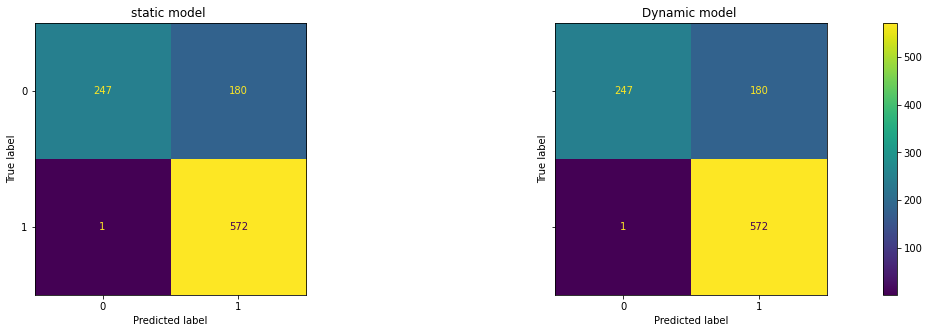

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 79
After getting the data from the window : the f1-score of the static  model= 0.8699 
After getting the data from the window : the f1-score of the Dynamic model= 0.8699 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       434
           1       0.77      1.00      0.87       566

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       434
           1       0.77      1.00      0.87       566

    accuracy                           0.83      1000
   macro avg       0.88      

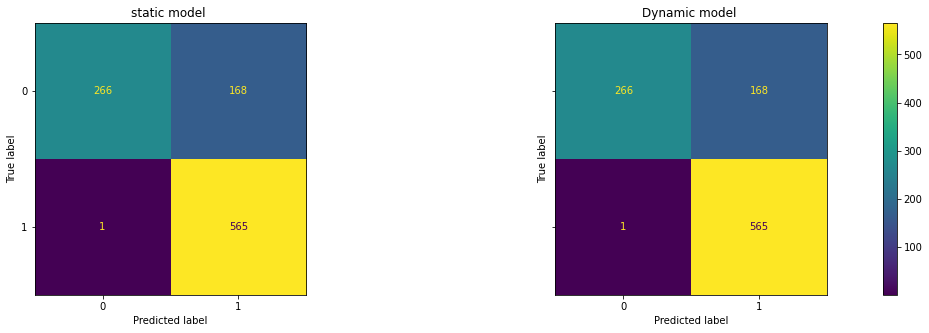

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 80
After getting the data from the window : the f1-score of the static  model= 0.8567 
After getting the data from the window : the f1-score of the Dynamic model= 0.8567 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       453
           1       0.75      1.00      0.86       547

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       453
           1       0.75      1.00      0.86       547

    accuracy                           0.82      1000
   macro avg       0.87      

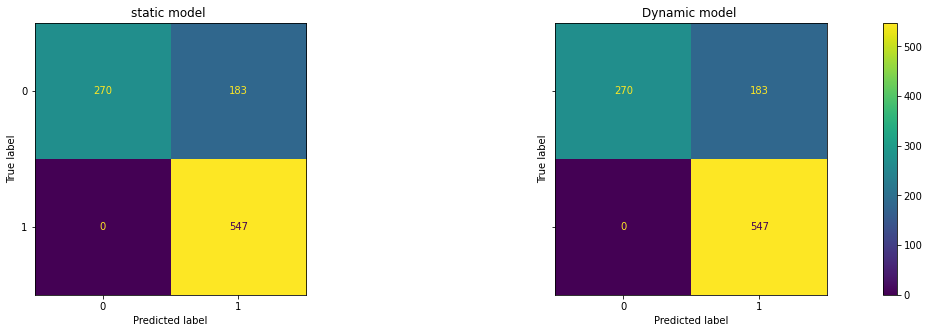

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 81
After getting the data from the window : the f1-score of the static  model= 0.8636 
After getting the data from the window : the f1-score of the Dynamic model= 0.8636 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       446
           1       0.76      1.00      0.86       554

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.82      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       446
           1       0.76      1.00      0.86       554

    accuracy                           0.82      1000
   macro avg       0.88      

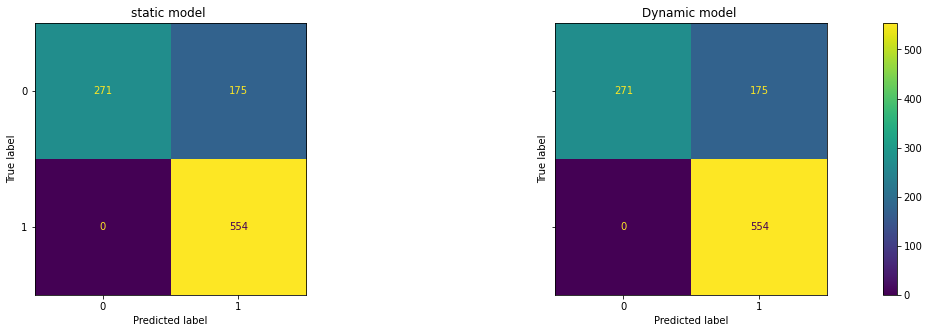

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 82
After getting the data from the window : the f1-score of the static  model= 0.8578 
After getting the data from the window : the f1-score of the Dynamic model= 0.8578 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       441
           1       0.75      1.00      0.86       559

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       441
           1       0.75      1.00      0.86       559

    accuracy                           0.81      1000
   macro avg       0.87      

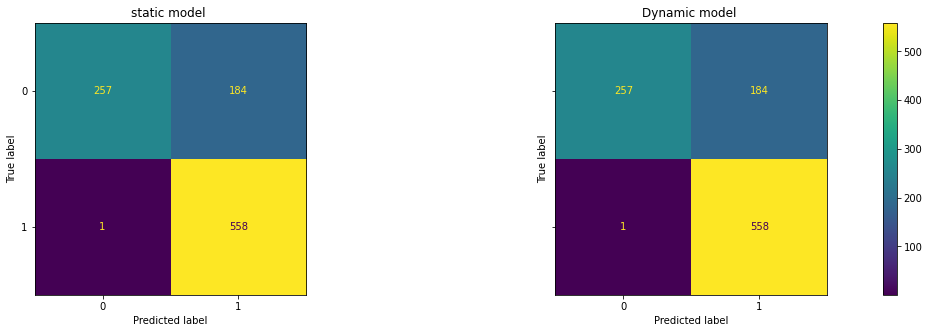

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 83
After getting the data from the window : the f1-score of the static  model= 0.8394 
After getting the data from the window : the f1-score of the Dynamic model= 0.8394 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       480
           1       0.72      1.00      0.84       520

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.86      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       480
           1       0.72      1.00      0.84       520

    accuracy                           0.80      1000
   macro avg       0.86      

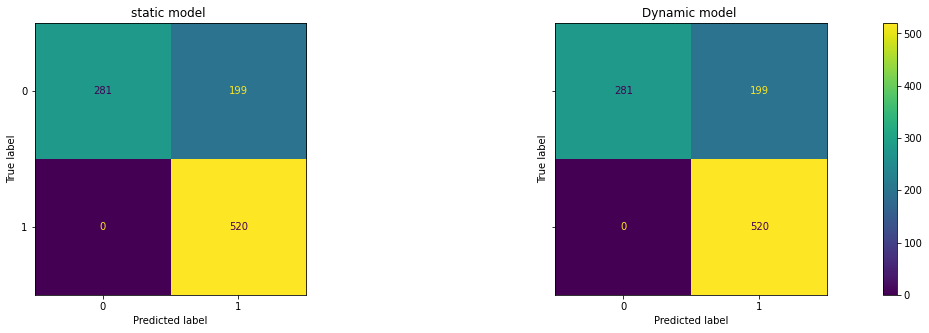

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8394
window : 84
After getting the data from the window : the f1-score of the static  model= 0.8576 
After getting the data from the window : the f1-score of the Dynamic model= 0.8576 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       443
           1       0.75      1.00      0.86       557

    accuracy                           0.81      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       443
           1       0.75      1.00      0.86       557

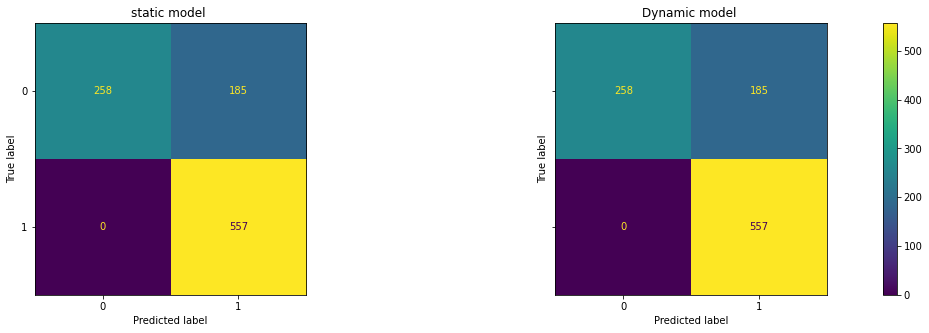

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 85
After getting the data from the window : the f1-score of the static  model= 0.8544 
After getting the data from the window : the f1-score of the Dynamic model= 0.8544 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       462
           1       0.75      1.00      0.85       538

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       462
           1       0.75      1.00      0.85       538

    accuracy                           0.82      1000
   macro avg       0.87      

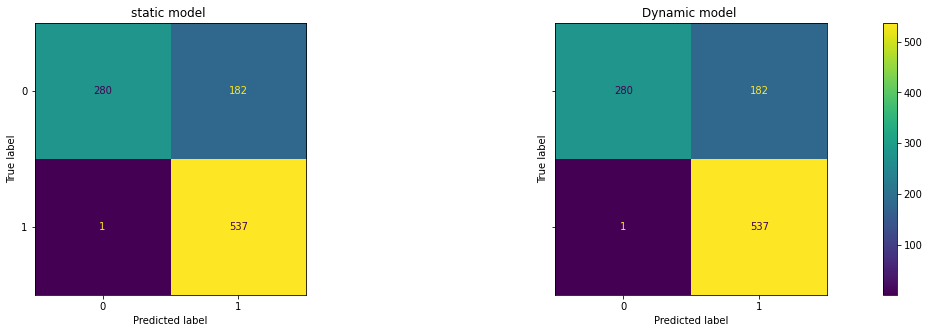

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 86
After getting the data from the window : the f1-score of the static  model= 0.8459 
After getting the data from the window : the f1-score of the Dynamic model= 0.8467 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.54      0.70       442
           1       0.73      1.00      0.85       558

    accuracy                           0.80      1000
   macro avg       0.86      0.77      0.77      1000
weighted avg       0.85      0.80      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.54      0.70       442
           1       0.73      1.00      0.85       558

    accuracy                           0.80      1000
   macro avg       0.87      

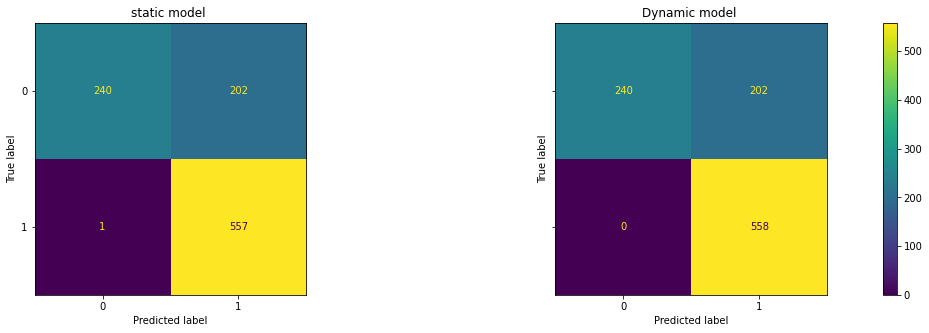

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8467
window : 87
After getting the data from the window : the f1-score of the static  model= 0.8430 
After getting the data from the window : the f1-score of the Dynamic model= 0.8430 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       468
           1       0.73      0.99      0.84       532

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       468
           1       0.73      0.99      0.84       532

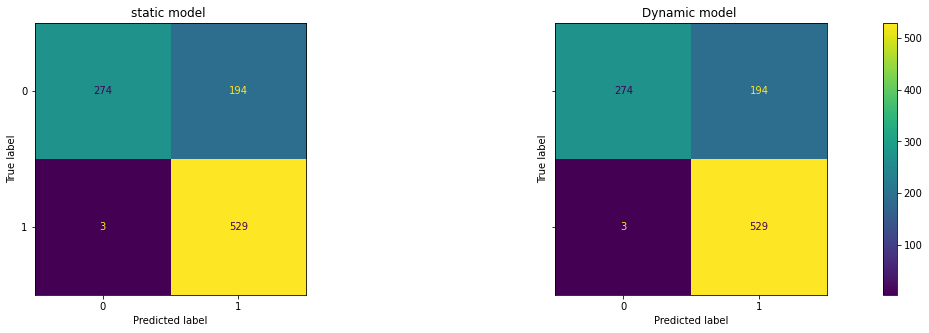

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8430
window : 88
After getting the data from the window : the f1-score of the static  model= 0.8522 
After getting the data from the window : the f1-score of the Dynamic model= 0.8522 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       457
           1       0.74      1.00      0.85       543

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       457
           1       0.74      1.00      0.85       543

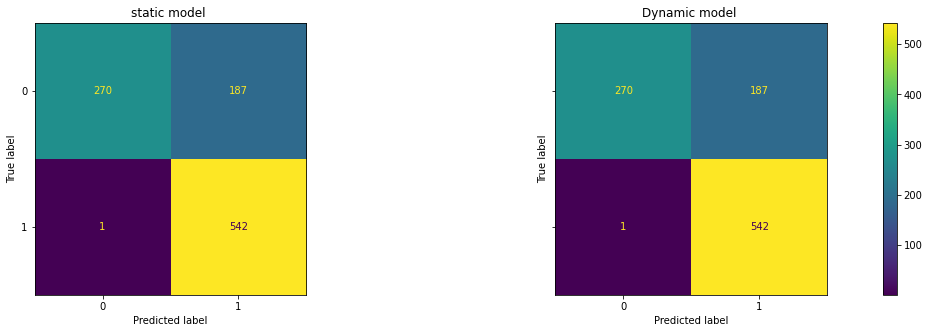

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 89
After getting the data from the window : the f1-score of the static  model= 0.8615 
After getting the data from the window : the f1-score of the Dynamic model= 0.8615 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       467
           1       0.76      1.00      0.86       533

    accuracy                           0.83      1000
   macro avg       0.88      0.82      0.82      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       467
           1       0.76      1.00      0.86       533

    accuracy                           0.83      1000
   macro avg       0.88      

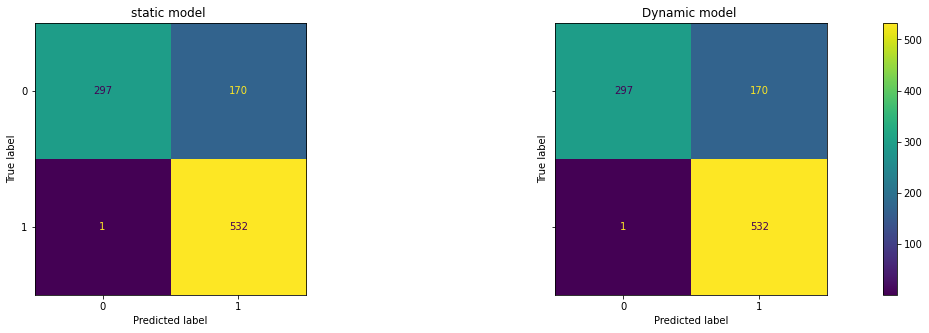

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 90
After getting the data from the window : the f1-score of the static  model= 0.8598 
After getting the data from the window : the f1-score of the Dynamic model= 0.8607 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       447
           1       0.76      1.00      0.86       553

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       447
           1       0.76      1.00      0.86       553

    accuracy                           0.82      1000
   macro avg       0.88      

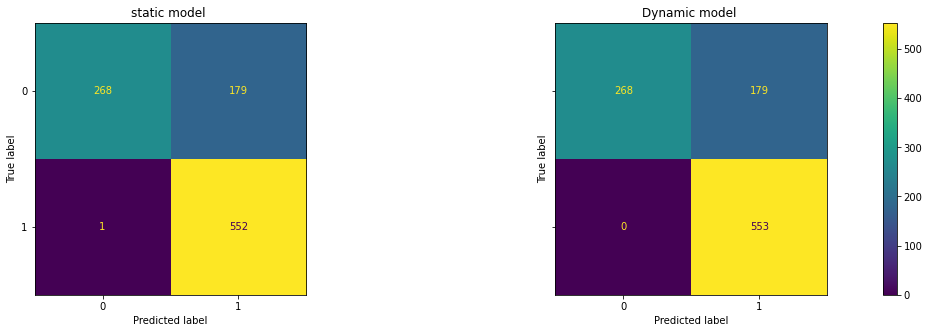

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 91
After getting the data from the window : the f1-score of the static  model= 0.8571 
After getting the data from the window : the f1-score of the Dynamic model= 0.8580 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.55      0.70       418
           1       0.75      0.99      0.86       582

    accuracy                           0.81      1000
   macro avg       0.87      0.77      0.78      1000
weighted avg       0.85      0.81      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.55      0.70       418
           1       0.75      1.00      0.86       582

    accuracy                           0.81      1000
   macro avg       0.87      

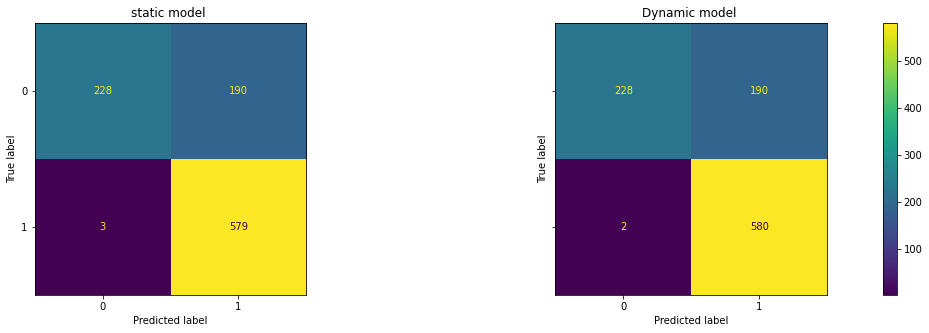

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 92
After getting the data from the window : the f1-score of the static  model= 0.8646 
After getting the data from the window : the f1-score of the Dynamic model= 0.8646 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       434
           1       0.76      1.00      0.86       566

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       434
           1       0.76      1.00      0.86       566

    accuracy                           0.82      1000
   macro avg       0.88      

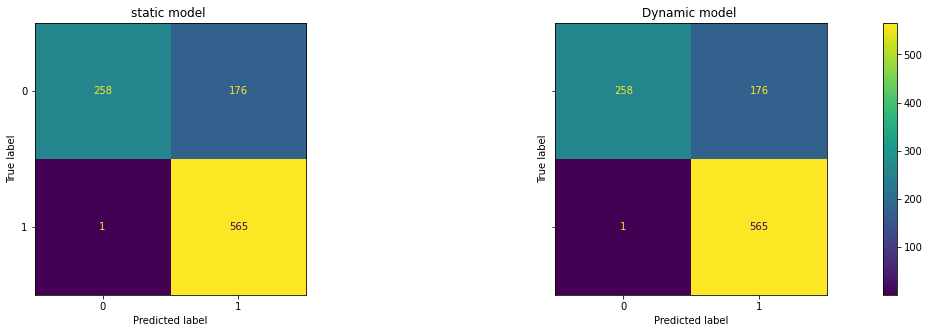

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 93
After getting the data from the window : the f1-score of the static  model= 0.8507 
After getting the data from the window : the f1-score of the Dynamic model= 0.8507 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       453
           1       0.74      1.00      0.85       547

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       453
           1       0.74      1.00      0.85       547

    accuracy                           0.81      1000
   macro avg       0.87      

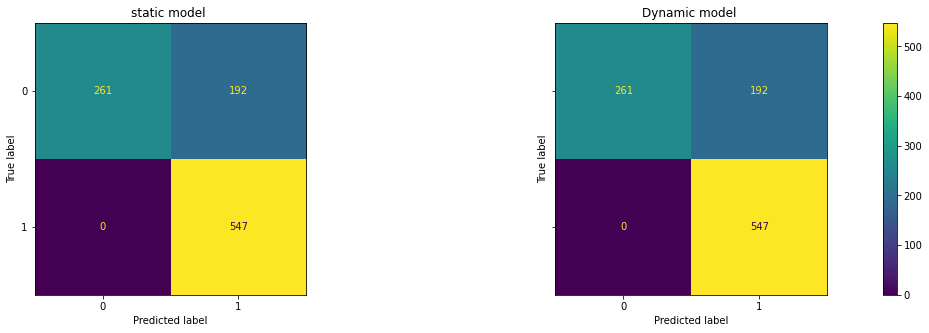

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 94
After getting the data from the window : the f1-score of the static  model= 0.8476 
After getting the data from the window : the f1-score of the Dynamic model= 0.8469 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       479
           1       0.74      1.00      0.85       521

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       479
           1       0.74      1.00      0.85       521

    accuracy                           0.81      1000
   macro avg       0.87      

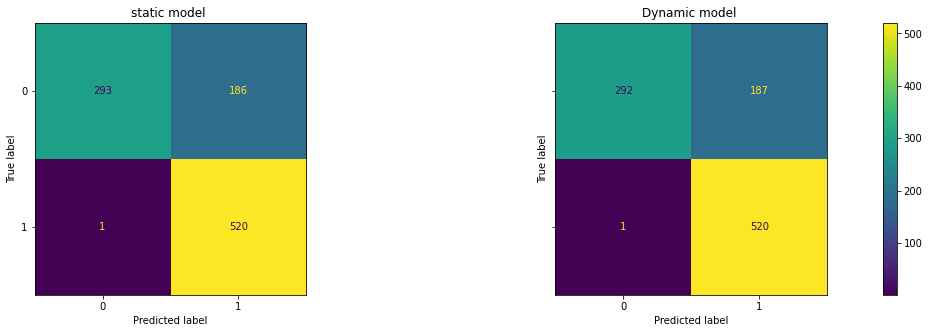

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8469
window : 95
After getting the data from the window : the f1-score of the static  model= 0.8786 
After getting the data from the window : the f1-score of the Dynamic model= 0.8786 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       428
           1       0.78      1.00      0.88       572

    accuracy                           0.84      1000
   macro avg       0.89      0.82      0.83      1000
weighted avg       0.88      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       428
           1       0.78      1.00      0.88       572

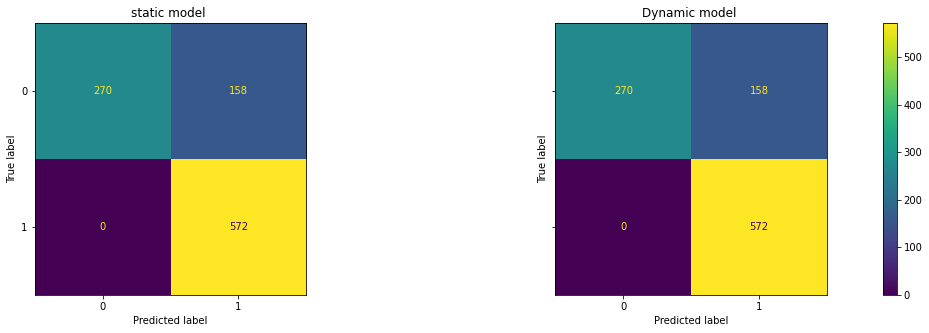

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 96
After getting the data from the window : the f1-score of the static  model= 0.8520 
After getting the data from the window : the f1-score of the Dynamic model= 0.8527 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       453
           1       0.74      1.00      0.85       547

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       453
           1       0.74      1.00      0.85       547

    accuracy                           0.81      1000
   macro avg       0.87      

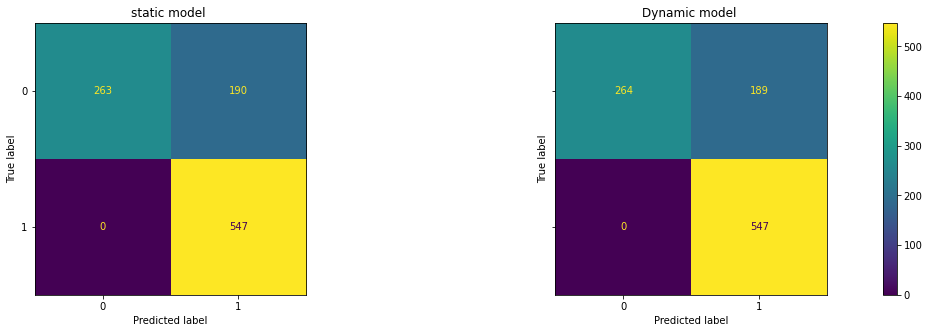

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 97
After getting the data from the window : the f1-score of the static  model= 0.8396 
After getting the data from the window : the f1-score of the Dynamic model= 0.8403 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       479
           1       0.72      1.00      0.84       521

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.86      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       479
           1       0.72      1.00      0.84       521

    accuracy                           0.80      1000
   macro avg       0.86      

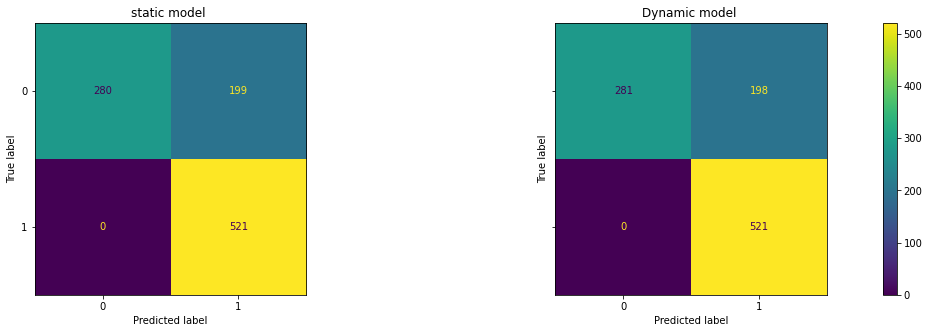

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8403
window : 98
After getting the data from the window : the f1-score of the static  model= 0.8523 
After getting the data from the window : the f1-score of the Dynamic model= 0.8523 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       469
           1       0.74      1.00      0.85       531

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       469
           1       0.74      1.00      0.85       531

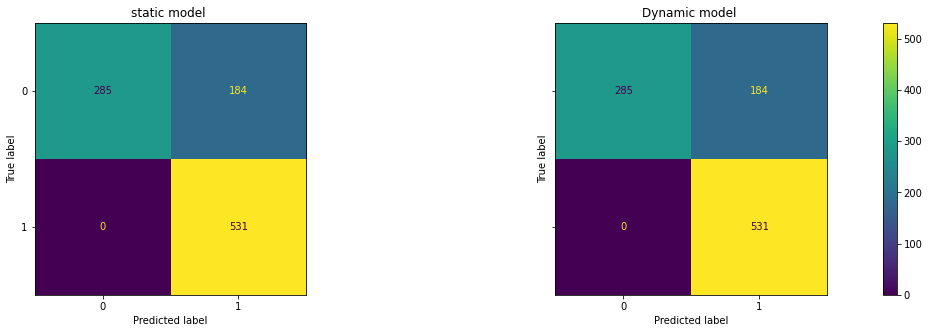

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 99
After getting the data from the window : the f1-score of the static  model= 0.8600 
After getting the data from the window : the f1-score of the Dynamic model= 0.8600 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       438
           1       0.75      1.00      0.86       562

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       438
           1       0.75      1.00      0.86       562

    accuracy                           0.82      1000
   macro avg       0.88      

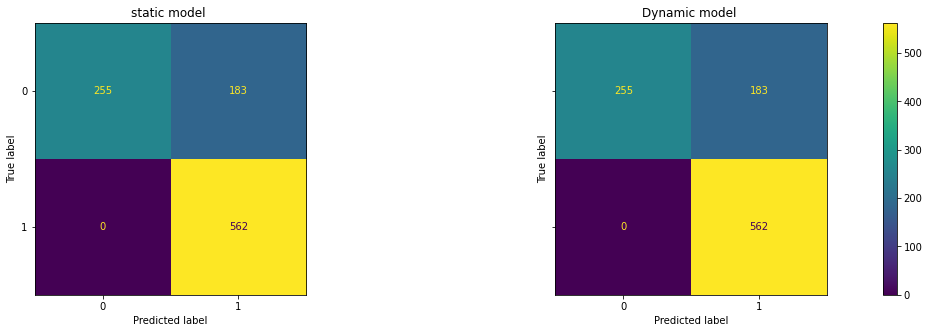

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 100
After getting the data from the window : the f1-score of the static  model= 0.8396 
After getting the data from the window : the f1-score of the Dynamic model= 0.8412 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       473
           1       0.72      1.00      0.84       527

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       473
           1       0.73      1.00      0.84       527

    accuracy                           0.80      1000
   macro avg       0.86     

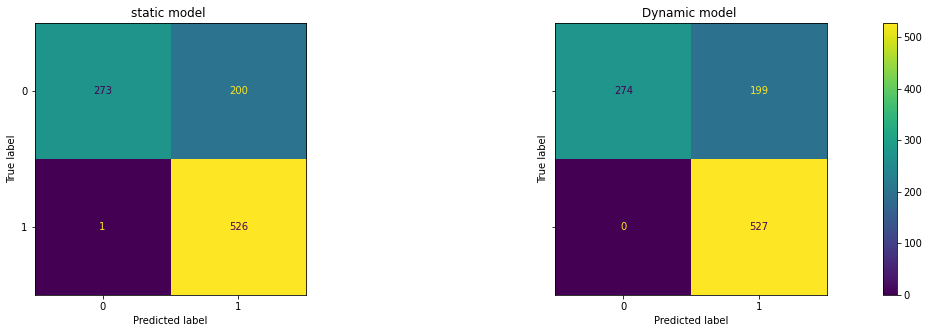

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8412
window : 101
After getting the data from the window : the f1-score of the static  model= 0.8603 
After getting the data from the window : the f1-score of the Dynamic model= 0.8603 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       452
           1       0.75      1.00      0.86       548

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       452
           1       0.75      1.00      0.86       54

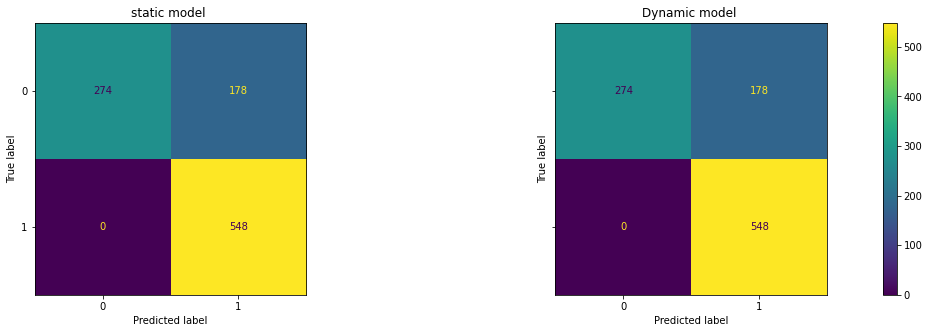

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 102
After getting the data from the window : the f1-score of the static  model= 0.8546 
After getting the data from the window : the f1-score of the Dynamic model= 0.8546 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       461
           1       0.75      1.00      0.85       539

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       461
           1       0.75      1.00      0.85       539

    accuracy                           0.82      1000
   macro avg       0.87     

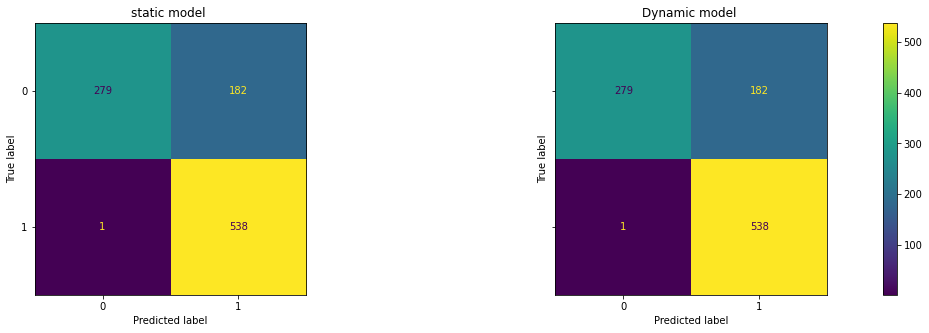

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 103
After getting the data from the window : the f1-score of the static  model= 0.8596 
After getting the data from the window : the f1-score of the Dynamic model= 0.8596 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       447
           1       0.76      1.00      0.86       553

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       447
           1       0.76      1.00      0.86       553

    accuracy                           0.82      1000
   macro avg       0.87     

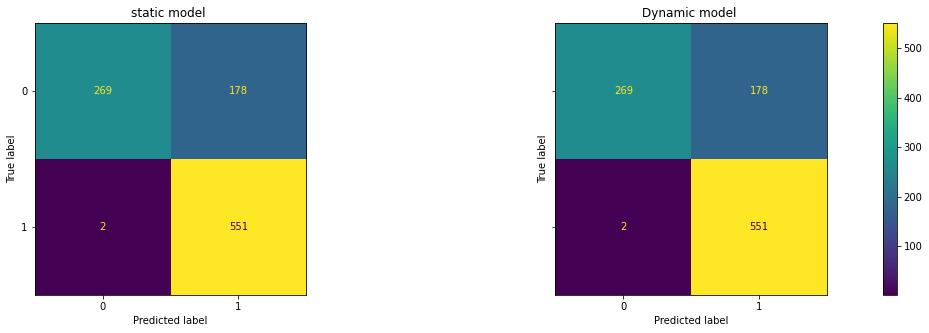

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 104
After getting the data from the window : the f1-score of the static  model= 0.8569 
After getting the data from the window : the f1-score of the Dynamic model= 0.8569 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       443
           1       0.75      0.99      0.86       557

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       443
           1       0.75      0.99      0.86       557

    accuracy                           0.81      1000
   macro avg       0.87     

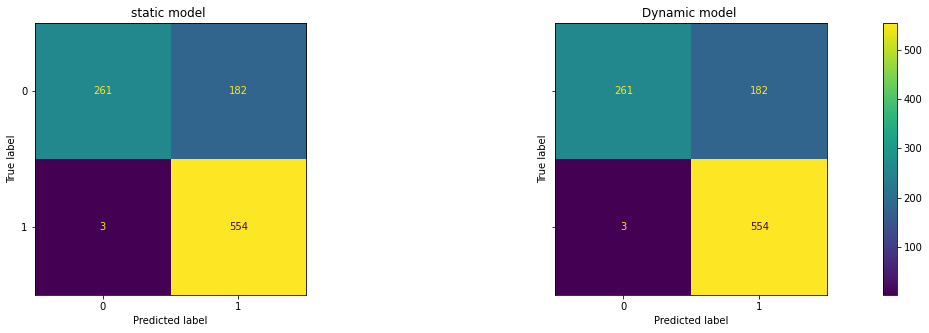

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 105
After getting the data from the window : the f1-score of the static  model= 0.8688 
After getting the data from the window : the f1-score of the Dynamic model= 0.8681 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       444
           1       0.77      1.00      0.87       556

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.82      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       444
           1       0.77      1.00      0.87       556

    accuracy                           0.83      1000
   macro avg       0.88     

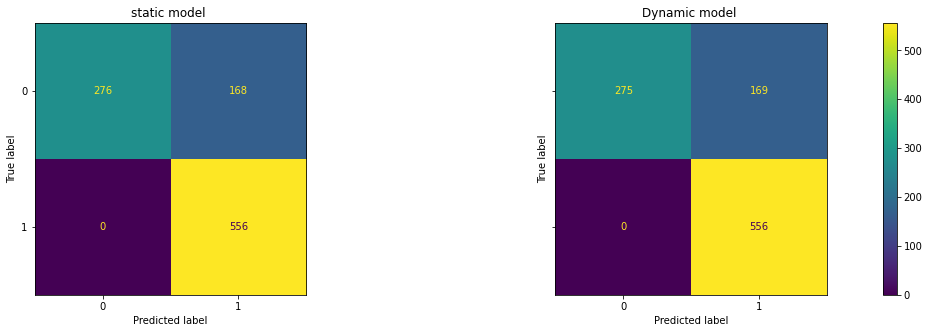

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 106
After getting the data from the window : the f1-score of the static  model= 0.8558 
After getting the data from the window : the f1-score of the Dynamic model= 0.8558 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       466
           1       0.75      1.00      0.86       534

    accuracy                           0.82      1000
   macro avg       0.87      0.81      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       466
           1       0.75      1.00      0.86       534

    accuracy                           0.82      1000
   macro avg       0.87     

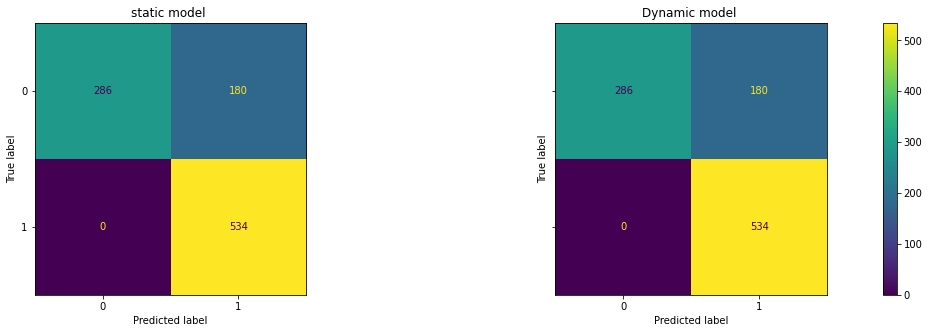

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 107
After getting the data from the window : the f1-score of the static  model= 0.8656 
After getting the data from the window : the f1-score of the Dynamic model= 0.8650 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       433
           1       0.76      1.00      0.87       567

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       433
           1       0.76      1.00      0.86       567

    accuracy                           0.82      1000
   macro avg       0.88     

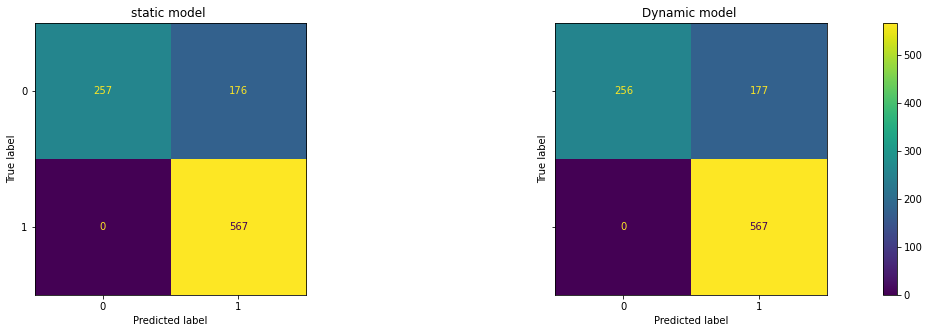

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 108
After getting the data from the window : the f1-score of the static  model= 0.8515 
After getting the data from the window : the f1-score of the Dynamic model= 0.8515 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       460
           1       0.74      1.00      0.85       540

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       460
           1       0.74      1.00      0.85       540

    accuracy                           0.81      1000
   macro avg       0.87     

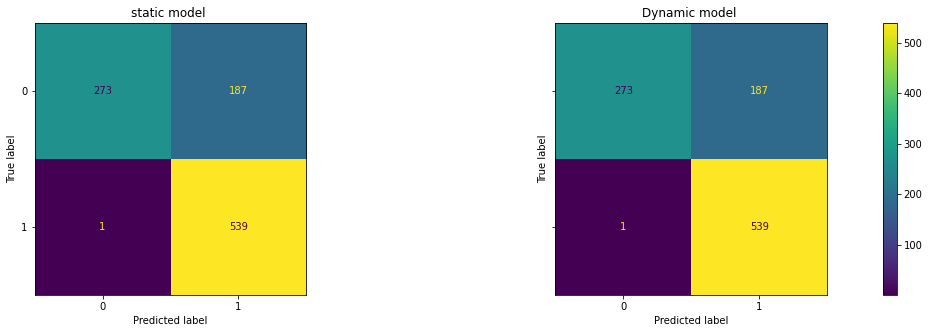

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 109
After getting the data from the window : the f1-score of the static  model= 0.8582 
After getting the data from the window : the f1-score of the Dynamic model= 0.8582 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       443
           1       0.75      1.00      0.86       557

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       443
           1       0.75      1.00      0.86       557

    accuracy                           0.82      1000
   macro avg       0.88     

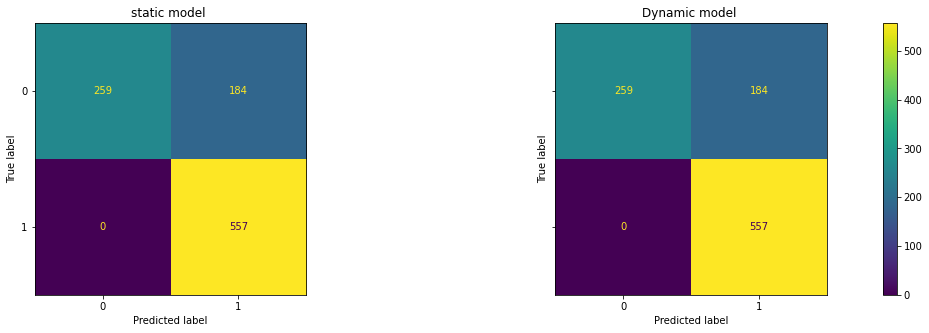

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 110
After getting the data from the window : the f1-score of the static  model= 0.8642 
After getting the data from the window : the f1-score of the Dynamic model= 0.8642 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       424
           1       0.76      1.00      0.86       576

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       424
           1       0.76      1.00      0.86       576

    accuracy                           0.82      1000
   macro avg       0.88     

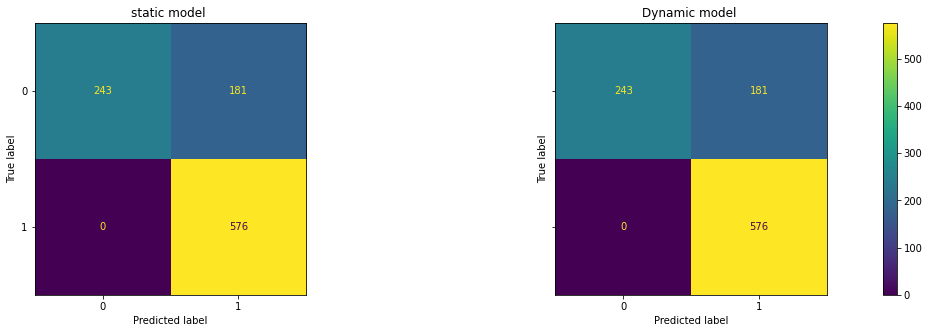

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 111
After getting the data from the window : the f1-score of the static  model= 0.8484 
After getting the data from the window : the f1-score of the Dynamic model= 0.8493 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.61      0.75       472
           1       0.74      1.00      0.85       528

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       472
           1       0.74      1.00      0.85       528

    accuracy                           0.81      1000
   macro avg       0.87     

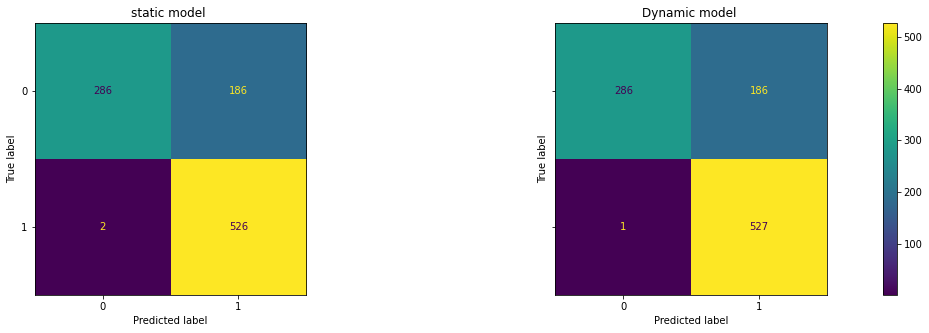

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8493
window : 112
After getting the data from the window : the f1-score of the static  model= 0.8449 
After getting the data from the window : the f1-score of the Dynamic model= 0.8449 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       449
           1       0.73      1.00      0.84       551

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       449
           1       0.73      1.00      0.84       55

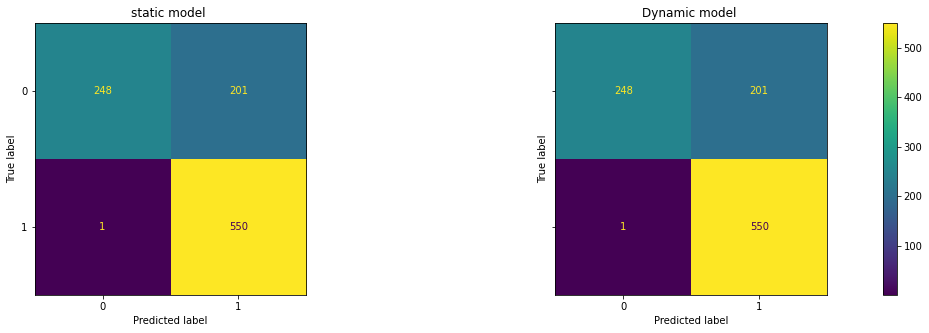

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8449
window : 113
After getting the data from the window : the f1-score of the static  model= 0.8379 
After getting the data from the window : the f1-score of the Dynamic model= 0.8379 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       477
           1       0.72      1.00      0.84       523

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       477
           1       0.72      1.00      0.84       52

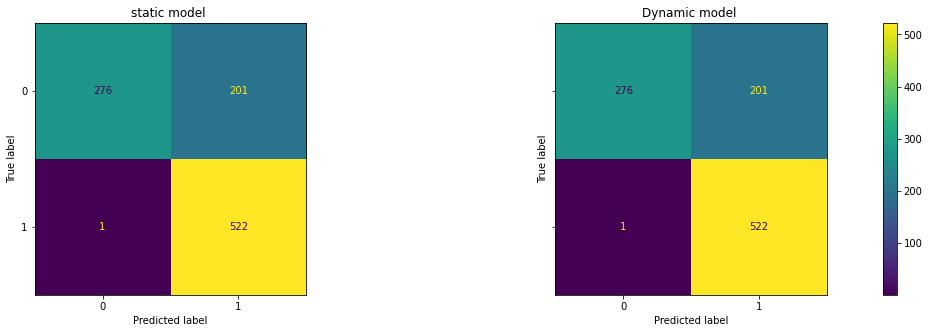

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8379
window : 114
After getting the data from the window : the f1-score of the static  model= 0.8540 
After getting the data from the window : the f1-score of the Dynamic model= 0.8540 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       462
           1       0.75      1.00      0.85       538

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       462
           1       0.75      1.00      0.85       53

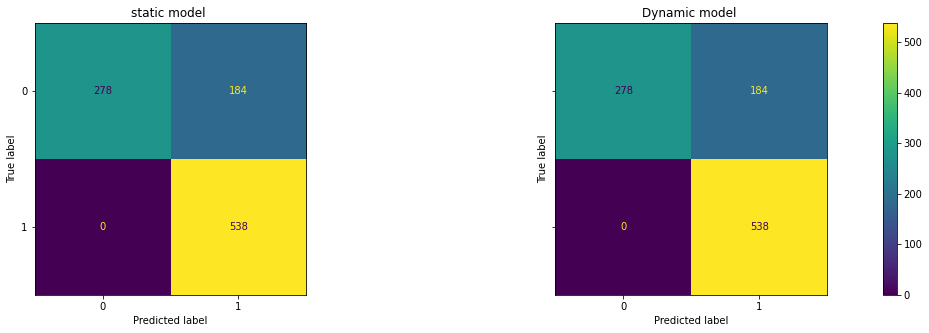

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 115
After getting the data from the window : the f1-score of the static  model= 0.8448 
After getting the data from the window : the f1-score of the Dynamic model= 0.8448 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       461
           1       0.73      1.00      0.84       539

    accuracy                           0.80      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       461
           1       0.73      1.00      0.84       539

    accuracy                           0.80      1000
   macro avg       0.87     

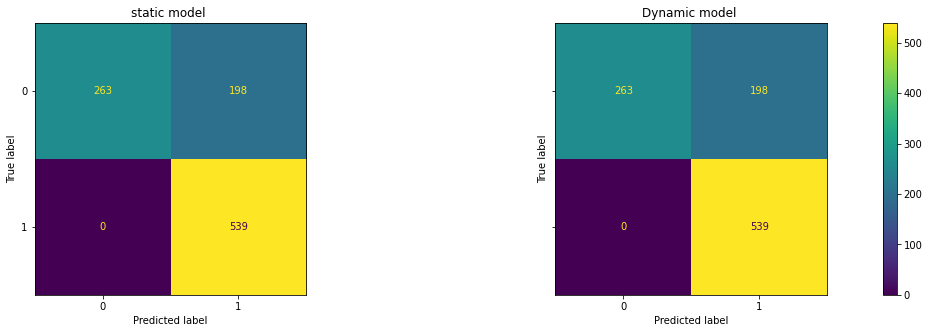

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8448
window : 116
After getting the data from the window : the f1-score of the static  model= 0.8639 
After getting the data from the window : the f1-score of the Dynamic model= 0.8639 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       451
           1       0.76      1.00      0.86       549

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       451
           1       0.76      1.00      0.86       54

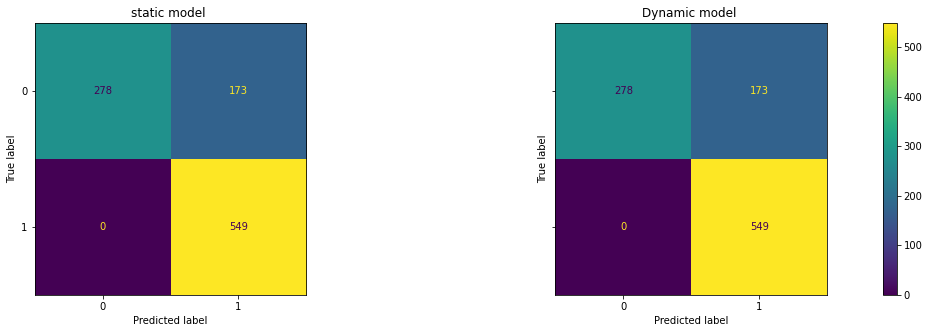

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 117
After getting the data from the window : the f1-score of the static  model= 0.8555 
After getting the data from the window : the f1-score of the Dynamic model= 0.8555 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       473
           1       0.75      1.00      0.86       527

    accuracy                           0.82      1000
   macro avg       0.87      0.81      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       473
           1       0.75      1.00      0.86       527

    accuracy                           0.82      1000
   macro avg       0.87     

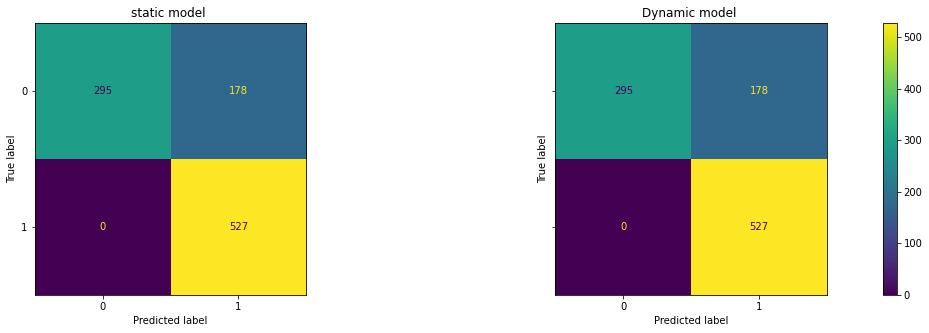

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 118
After getting the data from the window : the f1-score of the static  model= 0.8536 
After getting the data from the window : the f1-score of the Dynamic model= 0.8536 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       451
           1       0.75      1.00      0.85       549

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       451
           1       0.75      1.00      0.85       549

    accuracy                           0.81      1000
   macro avg       0.87     

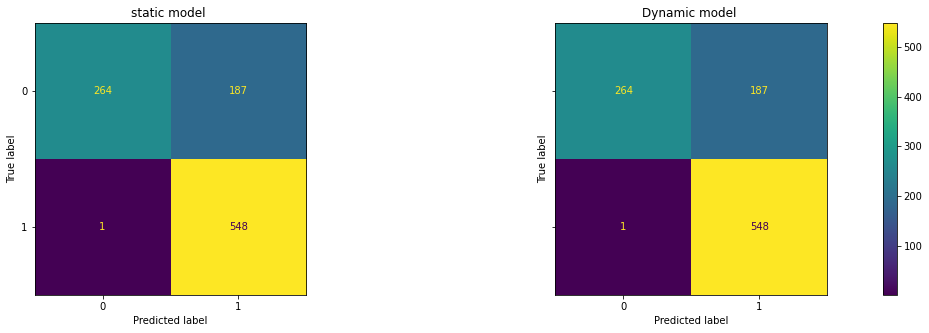

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 119
After getting the data from the window : the f1-score of the static  model= 0.8640 
After getting the data from the window : the f1-score of the Dynamic model= 0.8640 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       444
           1       0.76      1.00      0.86       556

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.82      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       444
           1       0.76      1.00      0.86       556

    accuracy                           0.82      1000
   macro avg       0.88     

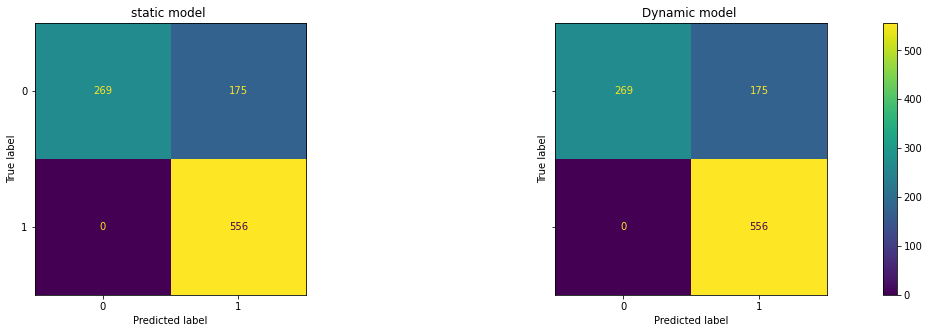

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 120
After getting the data from the window : the f1-score of the static  model= 0.8451 
After getting the data from the window : the f1-score of the Dynamic model= 0.8451 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       456
           1       0.73      1.00      0.85       544

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       456
           1       0.73      1.00      0.85       544

    accuracy                           0.80      1000
   macro avg       0.86     

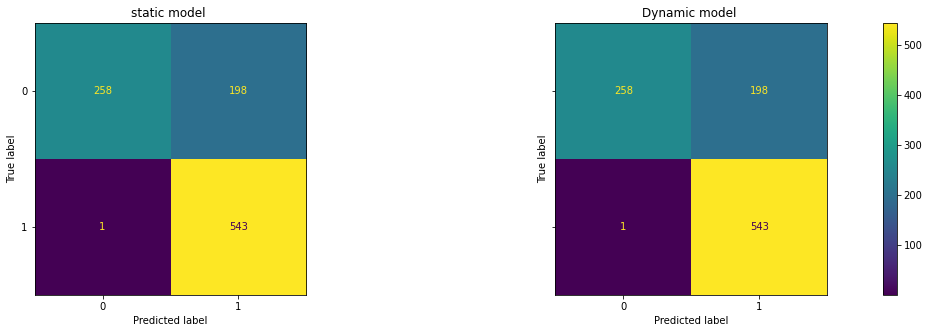

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8451
window : 121
After getting the data from the window : the f1-score of the static  model= 0.8509 
After getting the data from the window : the f1-score of the Dynamic model= 0.8509 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       457
           1       0.74      1.00      0.85       543

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       457
           1       0.74      1.00      0.85       54

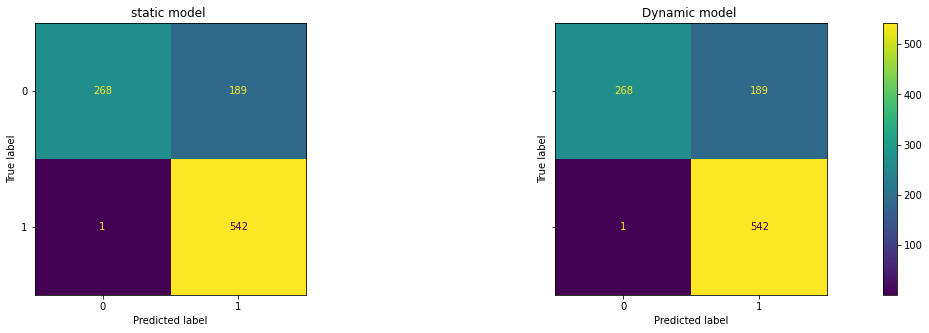

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 122
After getting the data from the window : the f1-score of the static  model= 0.8560 
After getting the data from the window : the f1-score of the Dynamic model= 0.8560 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       468
           1       0.75      1.00      0.86       532

    accuracy                           0.82      1000
   macro avg       0.87      0.81      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       468
           1       0.75      1.00      0.86       532

    accuracy                           0.82      1000
   macro avg       0.87     

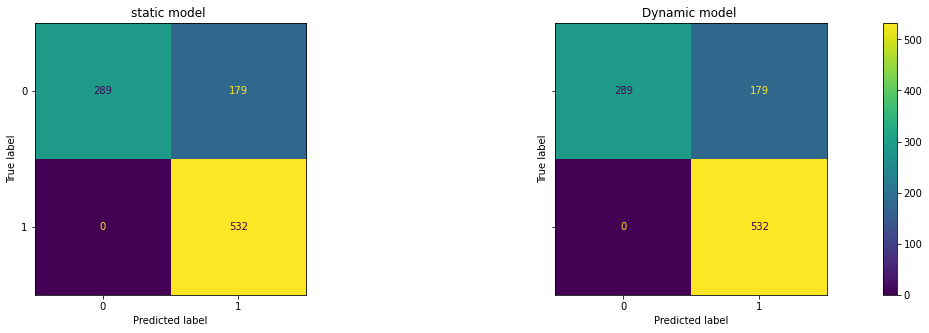

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 123
After getting the data from the window : the f1-score of the static  model= 0.8556 
After getting the data from the window : the f1-score of the Dynamic model= 0.8556 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       455
           1       0.75      1.00      0.86       545

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       455
           1       0.75      1.00      0.86       545

    accuracy                           0.82      1000
   macro avg       0.87     

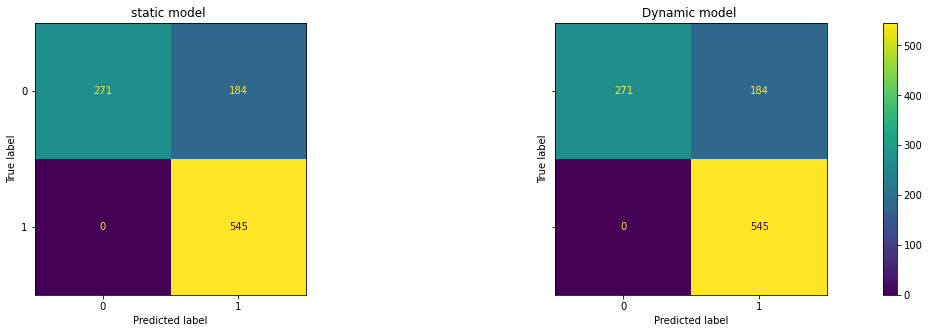

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 124
After getting the data from the window : the f1-score of the static  model= 0.8475 
After getting the data from the window : the f1-score of the Dynamic model= 0.8493 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       473
           1       0.74      1.00      0.85       527

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       473
           1       0.74      1.00      0.85       527

    accuracy                           0.81      1000
   macro avg       0.87     

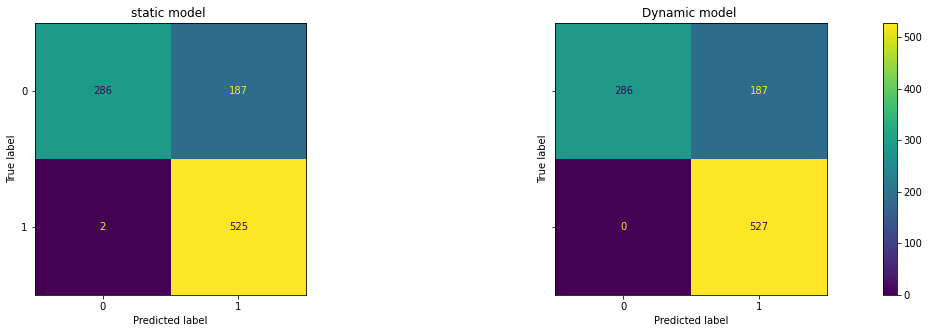

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8493
window : 125
After getting the data from the window : the f1-score of the static  model= 0.8419 
After getting the data from the window : the f1-score of the Dynamic model= 0.8419 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       473
           1       0.73      1.00      0.84       527

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.86      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       473
           1       0.73      1.00      0.84       52

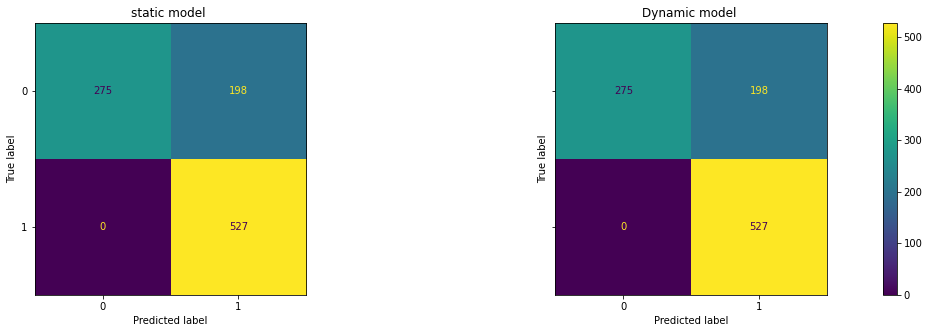

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8419
window : 126
After getting the data from the window : the f1-score of the static  model= 0.8655 
After getting the data from the window : the f1-score of the Dynamic model= 0.8655 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       453
           1       0.76      1.00      0.87       547

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.82      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       453
           1       0.76      1.00      0.87       54

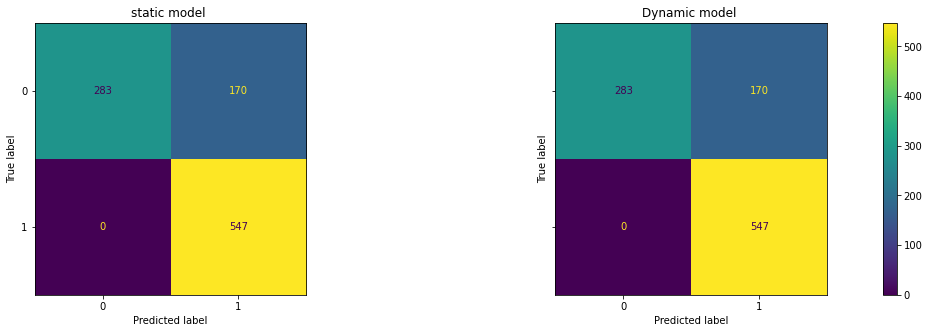

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 127
After getting the data from the window : the f1-score of the static  model= 0.8500 
After getting the data from the window : the f1-score of the Dynamic model= 0.8500 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       459
           1       0.74      1.00      0.85       541

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       459
           1       0.74      1.00      0.85       541

    accuracy                           0.81      1000
   macro avg       0.87     

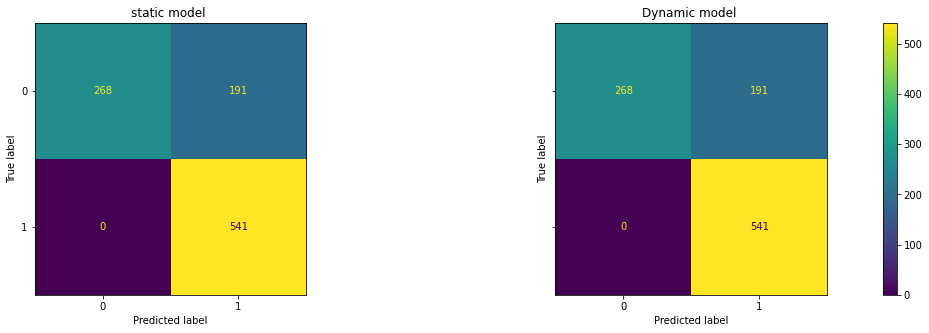

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8500
window : 128
After getting the data from the window : the f1-score of the static  model= 0.8556 
After getting the data from the window : the f1-score of the Dynamic model= 0.8556 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       460
           1       0.75      1.00      0.86       540

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       460
           1       0.75      1.00      0.86       54

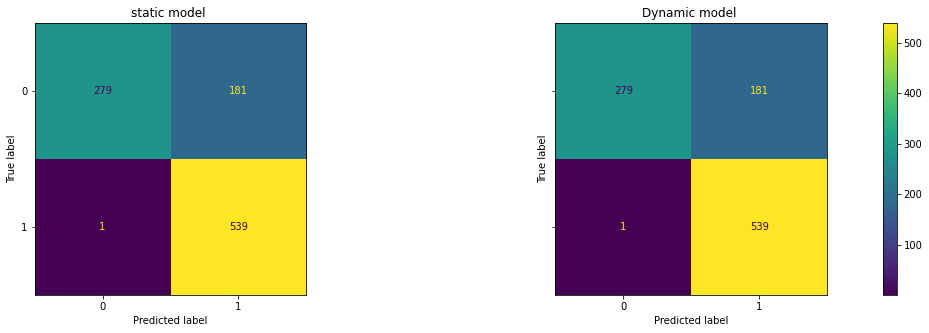

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 129
After getting the data from the window : the f1-score of the static  model= 0.8680 
After getting the data from the window : the f1-score of the Dynamic model= 0.8680 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       431
           1       0.77      1.00      0.87       569

    accuracy                           0.83      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       431
           1       0.77      1.00      0.87       569

    accuracy                           0.83      1000
   macro avg       0.88     

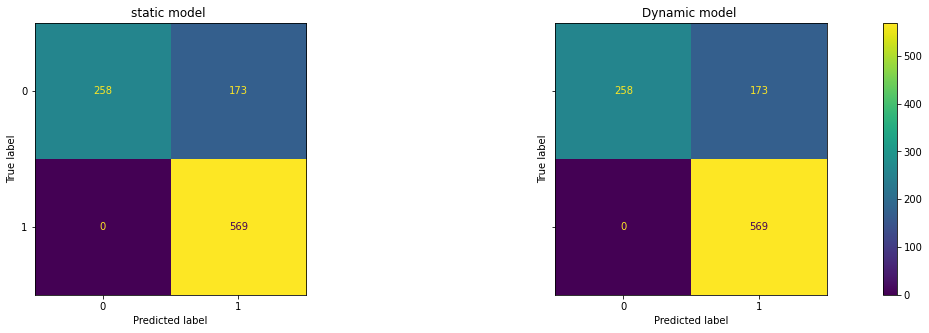

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 130
After getting the data from the window : the f1-score of the static  model= 0.8582 
After getting the data from the window : the f1-score of the Dynamic model= 0.8582 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       424
           1       0.75      1.00      0.86       576

    accuracy                           0.81      1000
   macro avg       0.87      0.78      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       424
           1       0.75      1.00      0.86       576

    accuracy                           0.81      1000
   macro avg       0.87     

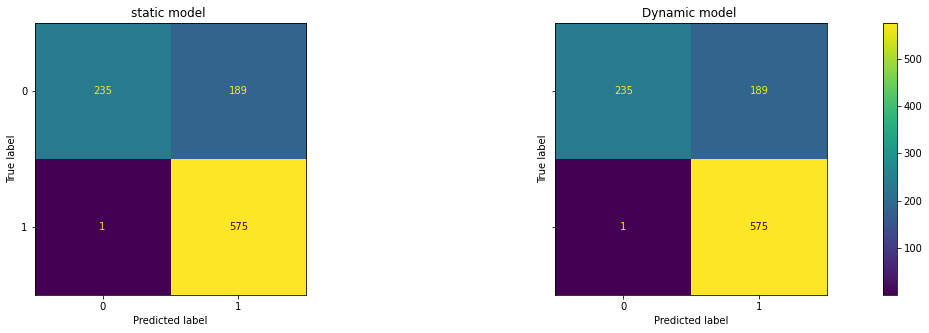

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 131
After getting the data from the window : the f1-score of the static  model= 0.8548 
After getting the data from the window : the f1-score of the Dynamic model= 0.8548 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       472
           1       0.75      1.00      0.85       528

    accuracy                           0.82      1000
   macro avg       0.87      0.81      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       472
           1       0.75      1.00      0.85       528

    accuracy                           0.82      1000
   macro avg       0.87     

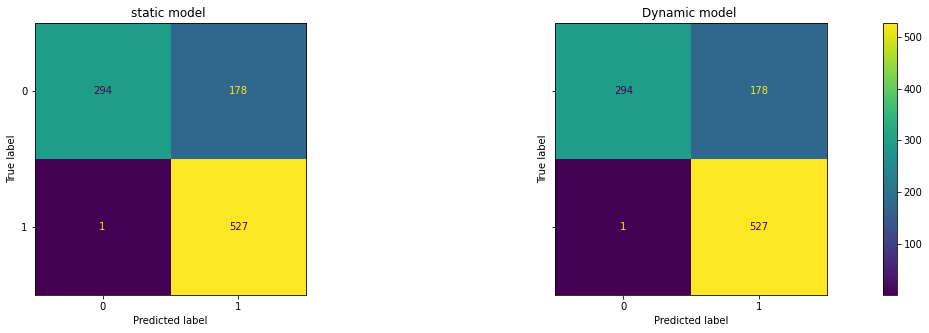

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 132
After getting the data from the window : the f1-score of the static  model= 0.8770 
After getting the data from the window : the f1-score of the Dynamic model= 0.8770 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       426
           1       0.78      1.00      0.88       574

    accuracy                           0.84      1000
   macro avg       0.89      0.81      0.82      1000
weighted avg       0.87      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       426
           1       0.78      1.00      0.88       574

    accuracy                           0.84      1000
   macro avg       0.89     

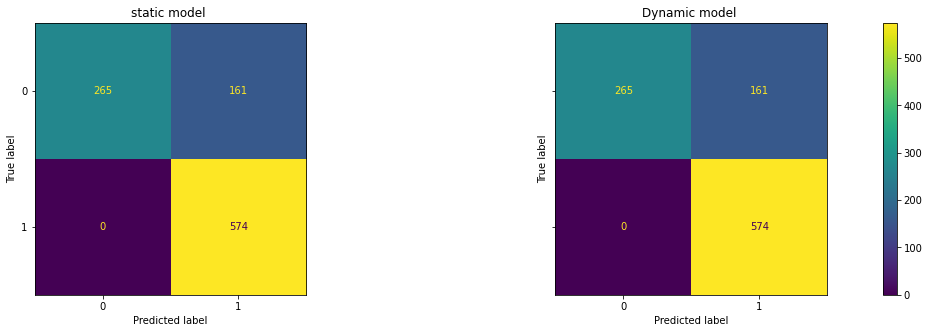

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 133
After getting the data from the window : the f1-score of the static  model= 0.8617 
After getting the data from the window : the f1-score of the Dynamic model= 0.8627 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.63      0.77       462
           1       0.76      1.00      0.86       538

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.82      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       462
           1       0.76      1.00      0.86       538

    accuracy                           0.83      1000
   macro avg       0.88     

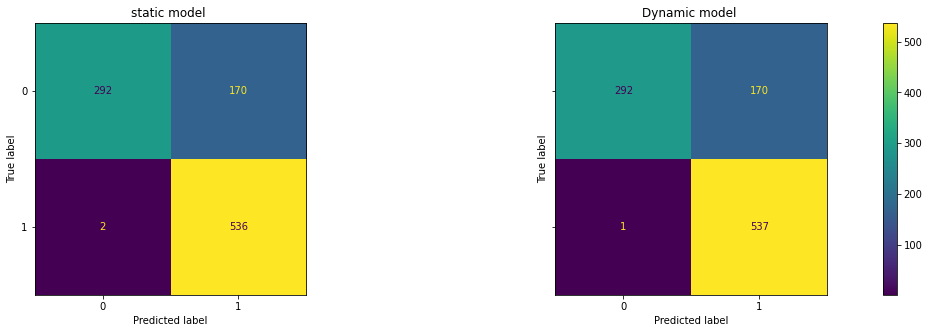

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 134
After getting the data from the window : the f1-score of the static  model= 0.8341 
After getting the data from the window : the f1-score of the Dynamic model= 0.8341 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       482
           1       0.72      1.00      0.83       518

    accuracy                           0.79      1000
   macro avg       0.86      0.79      0.78      1000
weighted avg       0.85      0.79      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       482
           1       0.72      1.00      0.83       518

    accuracy                           0.79      1000
   macro avg       0.86     

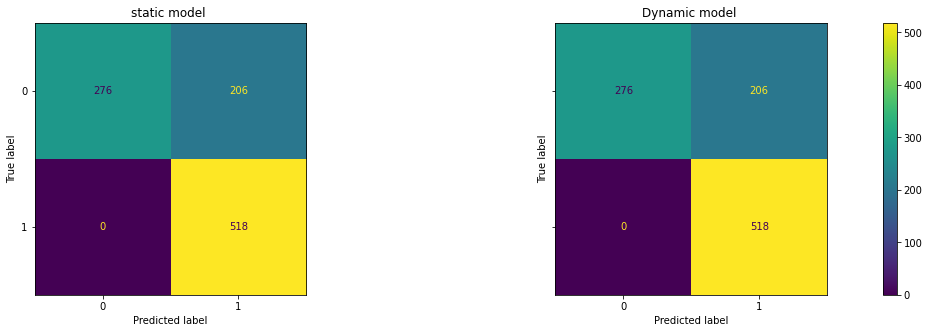

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8341
window : 135
After getting the data from the window : the f1-score of the static  model= 0.8540 
After getting the data from the window : the f1-score of the Dynamic model= 0.8540 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       464
           1       0.75      1.00      0.85       536

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       464
           1       0.75      1.00      0.85       53

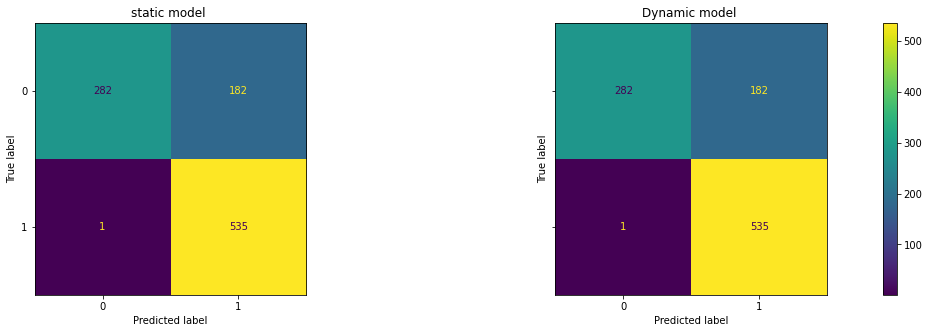

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 136
After getting the data from the window : the f1-score of the static  model= 0.8518 
After getting the data from the window : the f1-score of the Dynamic model= 0.8518 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       451
           1       0.74      1.00      0.85       549

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       451
           1       0.74      1.00      0.85       549

    accuracy                           0.81      1000
   macro avg       0.87     

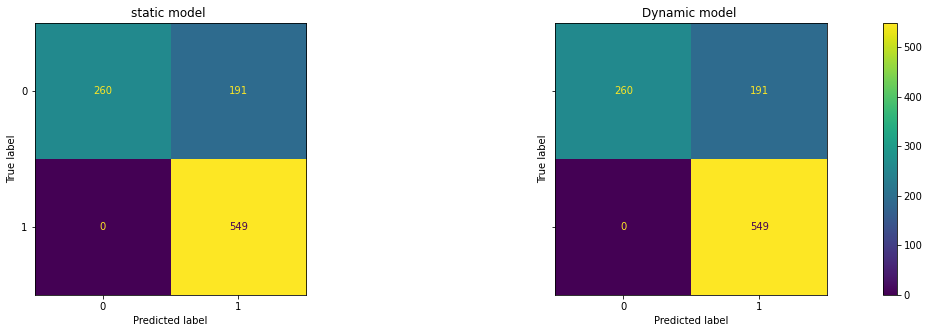

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 137
After getting the data from the window : the f1-score of the static  model= 0.8692 
After getting the data from the window : the f1-score of the Dynamic model= 0.8692 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       432
           1       0.77      1.00      0.87       568

    accuracy                           0.83      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       432
           1       0.77      1.00      0.87       568

    accuracy                           0.83      1000
   macro avg       0.88     

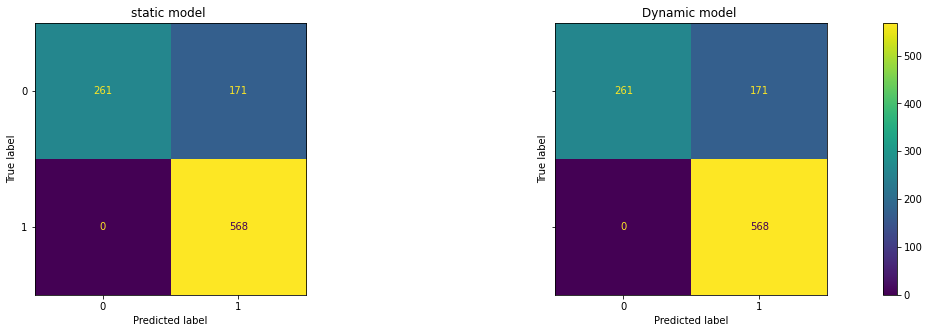

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 138
After getting the data from the window : the f1-score of the static  model= 0.8635 
After getting the data from the window : the f1-score of the Dynamic model= 0.8635 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       440
           1       0.76      1.00      0.86       560

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       440
           1       0.76      1.00      0.86       560

    accuracy                           0.82      1000
   macro avg       0.88     

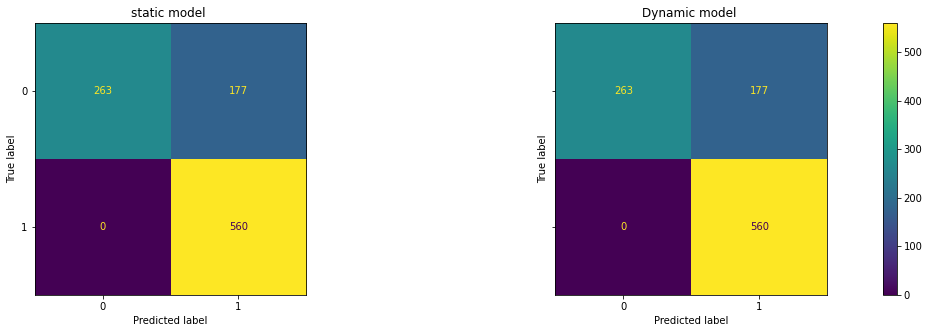

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 139
After getting the data from the window : the f1-score of the static  model= 0.8820 
After getting the data from the window : the f1-score of the Dynamic model= 0.8820 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.65      0.79       431
           1       0.79      1.00      0.88       569

    accuracy                           0.85      1000
   macro avg       0.89      0.82      0.83      1000
weighted avg       0.88      0.85      0.84      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.65      0.79       431
           1       0.79      1.00      0.88       569

    accuracy                           0.85      1000
   macro avg       0.89     

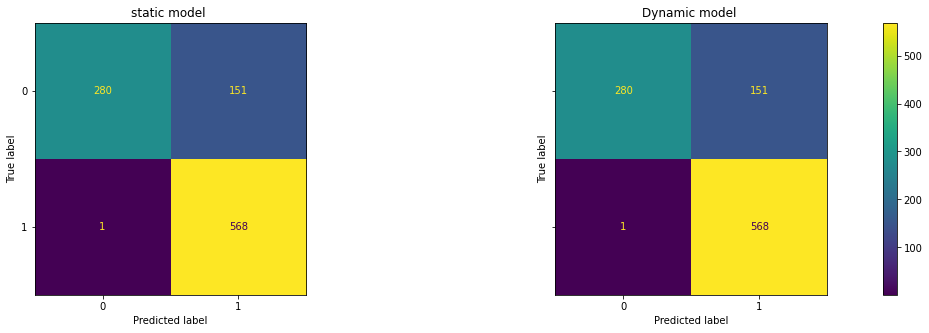

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 140
After getting the data from the window : the f1-score of the static  model= 0.8491 
After getting the data from the window : the f1-score of the Dynamic model= 0.8491 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       454
           1       0.74      1.00      0.85       546

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       454
           1       0.74      1.00      0.85       546

    accuracy                           0.81      1000
   macro avg       0.87     

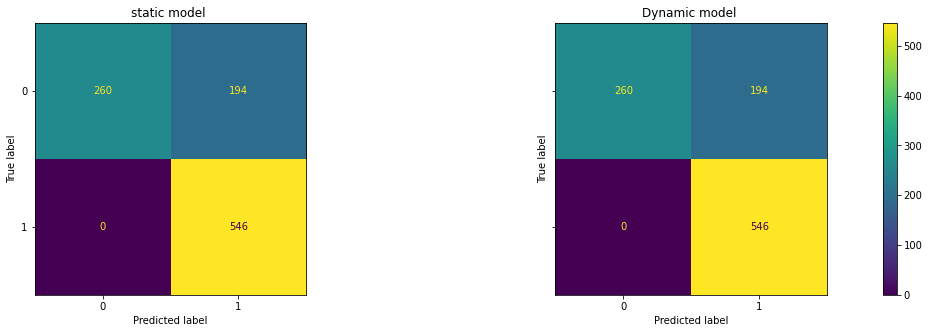

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8491
window : 141
After getting the data from the window : the f1-score of the static  model= 0.8413 
After getting the data from the window : the f1-score of the Dynamic model= 0.8413 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       462
           1       0.73      1.00      0.84       538

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       462
           1       0.73      1.00      0.84       53

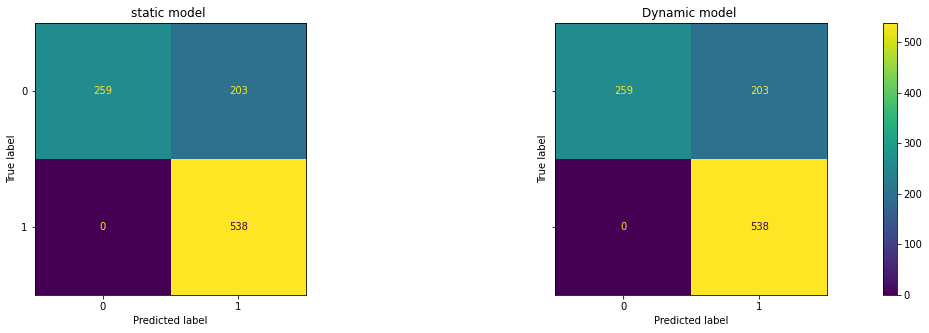

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8413
window : 142
After getting the data from the window : the f1-score of the static  model= 0.8809 
After getting the data from the window : the f1-score of the Dynamic model= 0.8817 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       411
           1       0.79      1.00      0.88       589

    accuracy                           0.84      1000
   macro avg       0.89      0.81      0.82      1000
weighted avg       0.87      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       411
           1       0.79      1.00      0.88       58

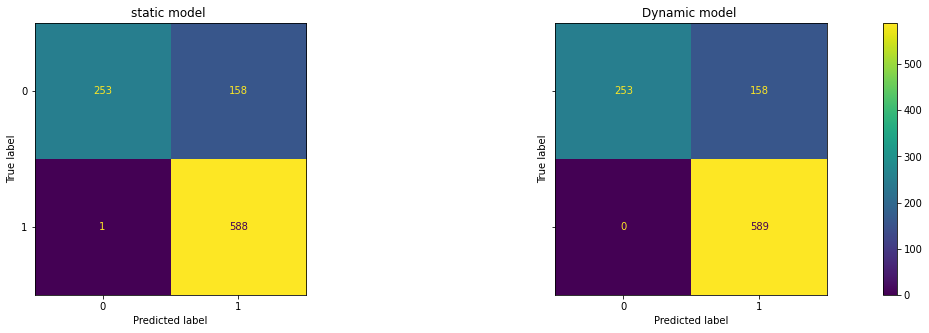

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 143
After getting the data from the window : the f1-score of the static  model= 0.8582 
After getting the data from the window : the f1-score of the Dynamic model= 0.8582 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       434
           1       0.75      1.00      0.86       566

    accuracy                           0.81      1000
   macro avg       0.88      0.78      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       434
           1       0.75      1.00      0.86       566

    accuracy                           0.81      1000
   macro avg       0.88     

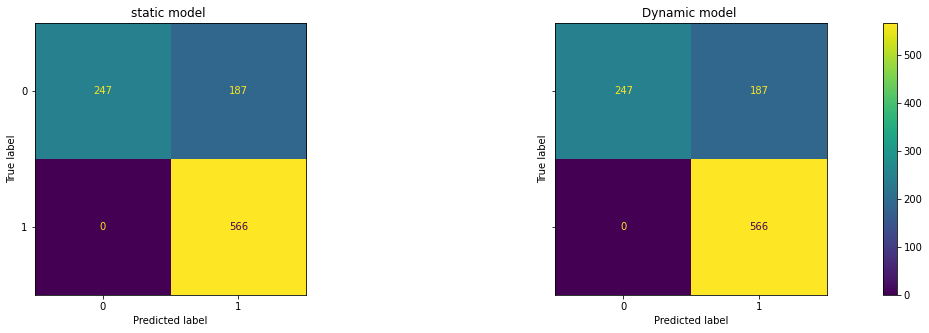

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 144
After getting the data from the window : the f1-score of the static  model= 0.8560 
After getting the data from the window : the f1-score of the Dynamic model= 0.8560 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       444
           1       0.75      1.00      0.86       556

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       444
           1       0.75      1.00      0.86       556

    accuracy                           0.81      1000
   macro avg       0.87     

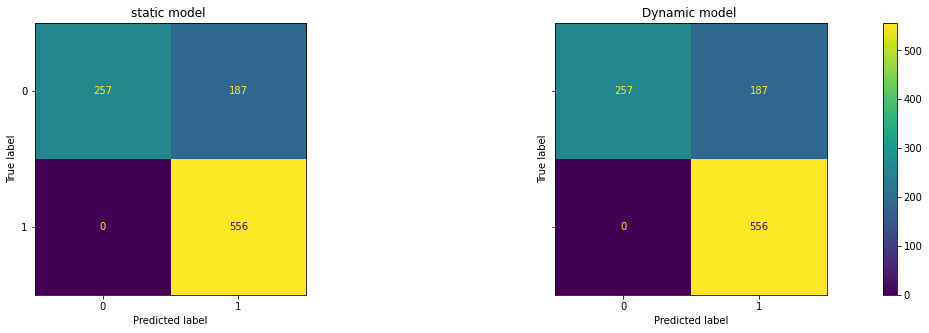

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 145
After getting the data from the window : the f1-score of the static  model= 0.8545 
After getting the data from the window : the f1-score of the Dynamic model= 0.8554 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       447
           1       0.75      1.00      0.85       553

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       447
           1       0.75      1.00      0.86       553

    accuracy                           0.81      1000
   macro avg       0.87     

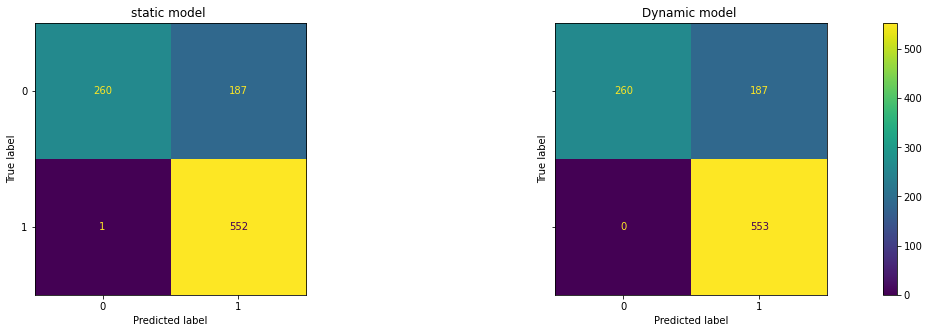

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 146
After getting the data from the window : the f1-score of the static  model= 0.8631 
After getting the data from the window : the f1-score of the Dynamic model= 0.8631 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       423
           1       0.76      1.00      0.86       577

    accuracy                           0.82      1000
   macro avg       0.88      0.78      0.79      1000
weighted avg       0.86      0.82      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       423
           1       0.76      1.00      0.86       577

    accuracy                           0.82      1000
   macro avg       0.88     

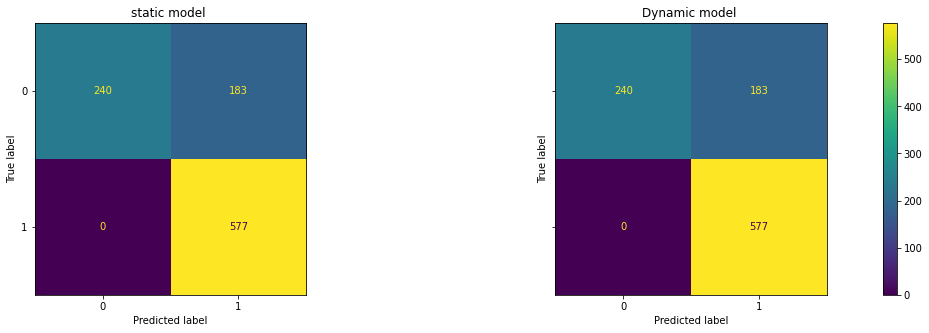

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 147
After getting the data from the window : the f1-score of the static  model= 0.8534 
After getting the data from the window : the f1-score of the Dynamic model= 0.8534 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       444
           1       0.74      1.00      0.85       556

    accuracy                           0.81      1000
   macro avg       0.87      0.78      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       444
           1       0.74      1.00      0.85       556

    accuracy                           0.81      1000
   macro avg       0.87     

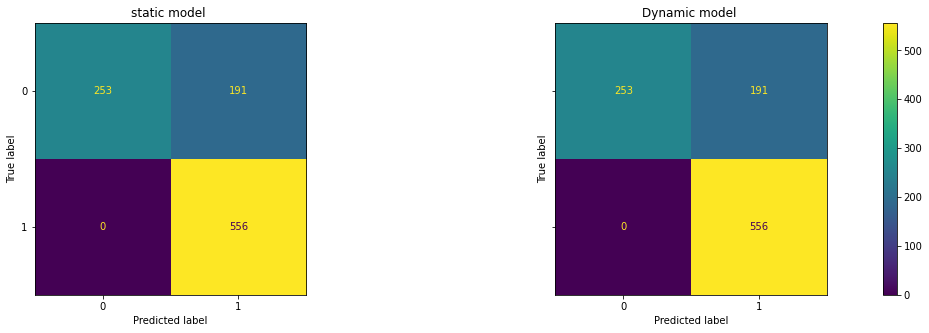

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 148
After getting the data from the window : the f1-score of the static  model= 0.8345 
After getting the data from the window : the f1-score of the Dynamic model= 0.8345 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.52      0.69       452
           1       0.72      1.00      0.83       548

    accuracy                           0.78      1000
   macro avg       0.86      0.76      0.76      1000
weighted avg       0.84      0.78      0.77      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.52      0.69       452
           1       0.72      1.00      0.83       548

    accuracy                           0.78      1000
   macro avg       0.86     

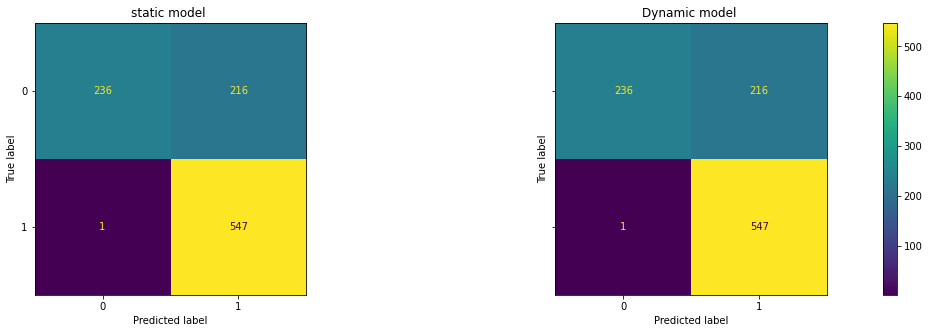

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8345
window : 149
After getting the data from the window : the f1-score of the static  model= 0.8576 
After getting the data from the window : the f1-score of the Dynamic model= 0.8576 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       440
           1       0.75      1.00      0.86       560

    accuracy                           0.81      1000
   macro avg       0.88      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       440
           1       0.75      1.00      0.86       56

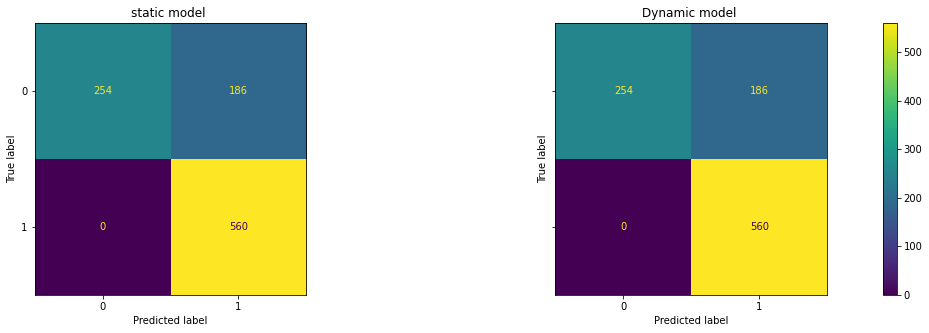

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 150
After getting the data from the window : the f1-score of the static  model= 0.8518 
After getting the data from the window : the f1-score of the Dynamic model= 0.8527 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       453
           1       0.74      1.00      0.85       547

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       453
           1       0.74      1.00      0.85       547

    accuracy                           0.81      1000
   macro avg       0.87     

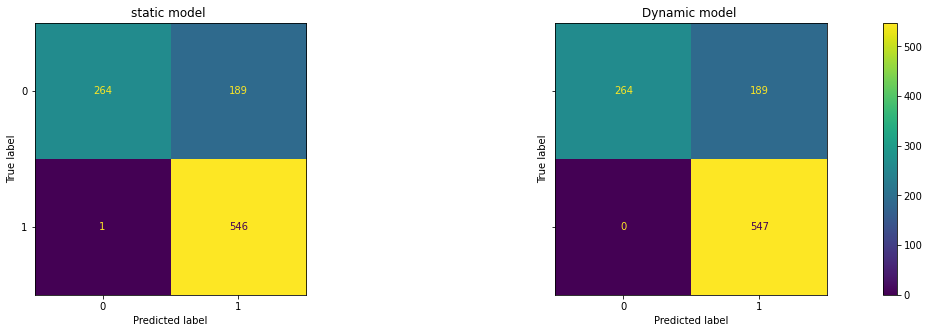

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 151
After getting the data from the window : the f1-score of the static  model= 0.8760 
After getting the data from the window : the f1-score of the Dynamic model= 0.8760 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       423
           1       0.78      1.00      0.88       577

    accuracy                           0.84      1000
   macro avg       0.89      0.81      0.82      1000
weighted avg       0.87      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       423
           1       0.78      1.00      0.88       577

    accuracy                           0.84      1000
   macro avg       0.89     

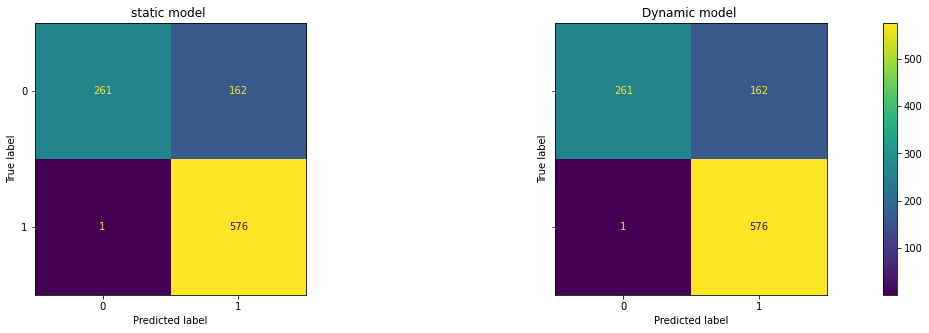

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 152
After getting the data from the window : the f1-score of the static  model= 0.8563 
After getting the data from the window : the f1-score of the Dynamic model= 0.8563 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       440
           1       0.75      1.00      0.86       560

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       440
           1       0.75      1.00      0.86       560

    accuracy                           0.81      1000
   macro avg       0.87     

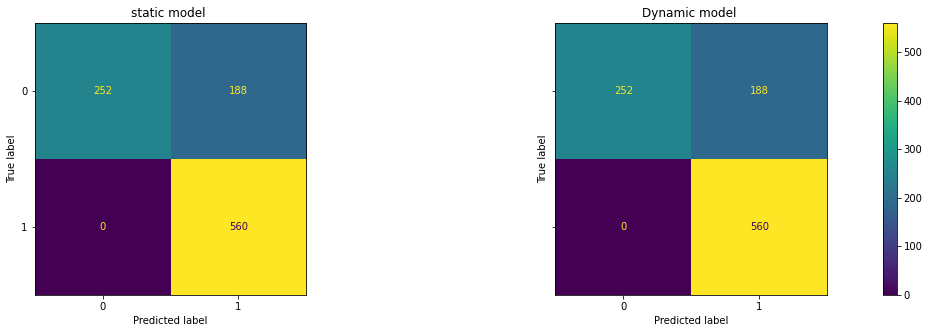

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 153
After getting the data from the window : the f1-score of the static  model= 0.8381 
After getting the data from the window : the f1-score of the Dynamic model= 0.8381 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       467
           1       0.72      1.00      0.84       533

    accuracy                           0.79      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.79      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       467
           1       0.72      1.00      0.84       533

    accuracy                           0.79      1000
   macro avg       0.86     

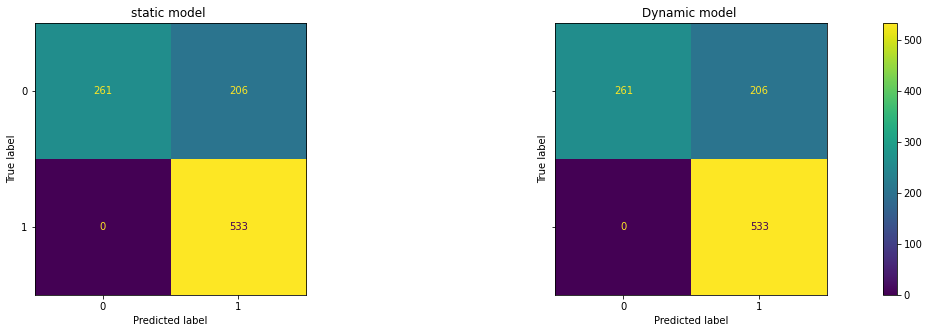

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8381
window : 154
After getting the data from the window : the f1-score of the static  model= 0.8613 
After getting the data from the window : the f1-score of the Dynamic model= 0.8613 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       441
           1       0.76      1.00      0.86       559

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       441
           1       0.76      1.00      0.86       55

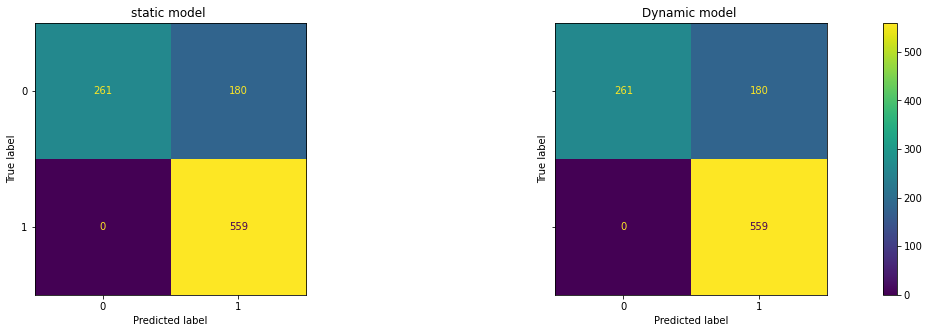

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 155
After getting the data from the window : the f1-score of the static  model= 0.8558 
After getting the data from the window : the f1-score of the Dynamic model= 0.8558 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       445
           1       0.75      1.00      0.86       555

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       445
           1       0.75      1.00      0.86       555

    accuracy                           0.81      1000
   macro avg       0.87     

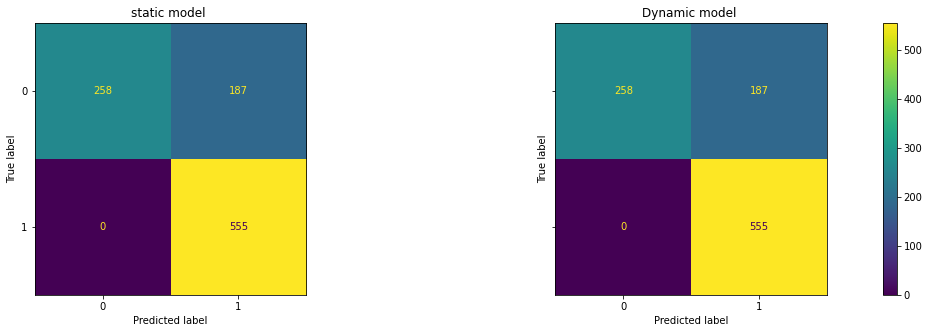

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 156
After getting the data from the window : the f1-score of the static  model= 0.8719 
After getting the data from the window : the f1-score of the Dynamic model= 0.8719 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       411
           1       0.77      1.00      0.87       589

    accuracy                           0.83      1000
   macro avg       0.89      0.79      0.80      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       411
           1       0.77      1.00      0.87       589

    accuracy                           0.83      1000
   macro avg       0.89     

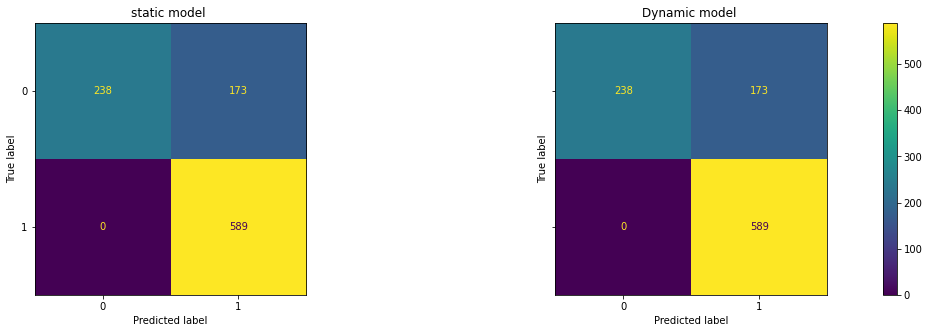

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 157
After getting the data from the window : the f1-score of the static  model= 0.8558 
After getting the data from the window : the f1-score of the Dynamic model= 0.8558 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       457
           1       0.75      1.00      0.86       543

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       457
           1       0.75      1.00      0.86       543

    accuracy                           0.82      1000
   macro avg       0.87     

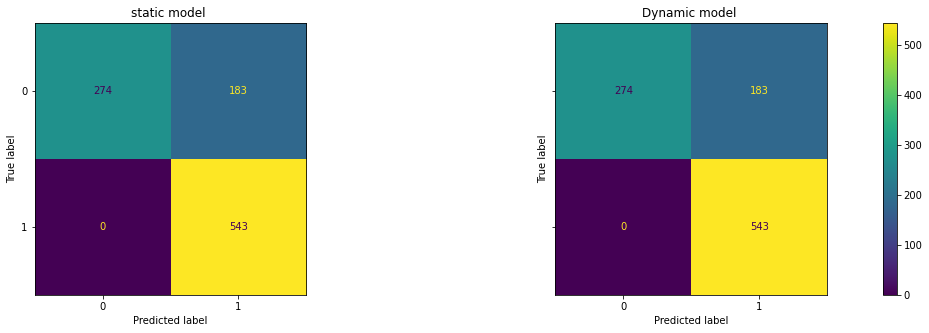

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 158
After getting the data from the window : the f1-score of the static  model= 0.8695 
After getting the data from the window : the f1-score of the Dynamic model= 0.8695 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       437
           1       0.77      1.00      0.87       563

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       437
           1       0.77      1.00      0.87       563

    accuracy                           0.83      1000
   macro avg       0.88     

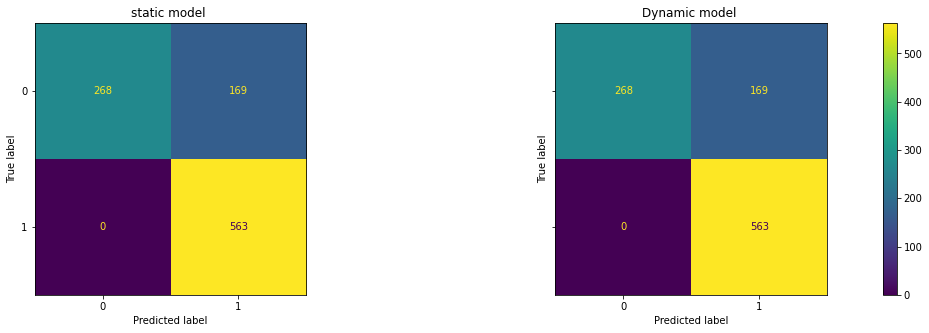

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 159
After getting the data from the window : the f1-score of the static  model= 0.8580 
After getting the data from the window : the f1-score of the Dynamic model= 0.8580 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       438
           1       0.75      1.00      0.86       562

    accuracy                           0.81      1000
   macro avg       0.88      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       438
           1       0.75      1.00      0.86       562

    accuracy                           0.81      1000
   macro avg       0.88     

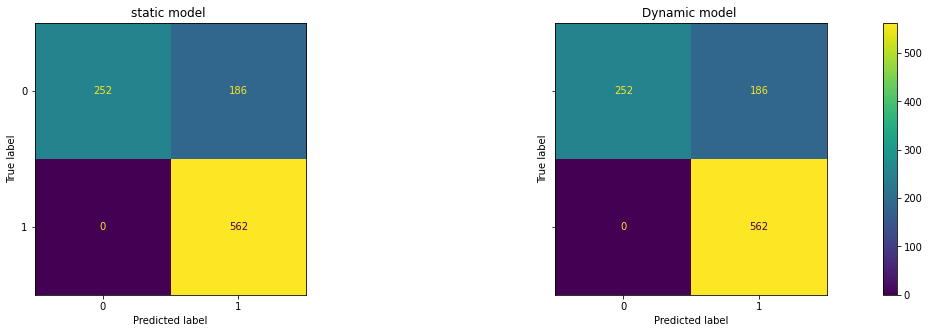

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 160
After getting the data from the window : the f1-score of the static  model= 0.8377 
After getting the data from the window : the f1-score of the Dynamic model= 0.8384 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.54      0.70       457
           1       0.72      1.00      0.84       543

    accuracy                           0.79      1000
   macro avg       0.86      0.77      0.77      1000
weighted avg       0.85      0.79      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.54      0.70       457
           1       0.72      1.00      0.84       543

    accuracy                           0.79      1000
   macro avg       0.86     

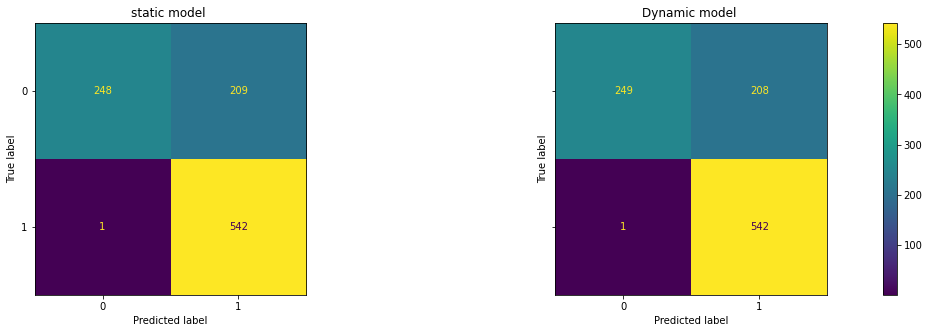

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8384
window : 161
After getting the data from the window : the f1-score of the static  model= 0.8393 
After getting the data from the window : the f1-score of the Dynamic model= 0.8393 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       462
           1       0.72      1.00      0.84       538

    accuracy                           0.79      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.79      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       462
           1       0.72      1.00      0.84       53

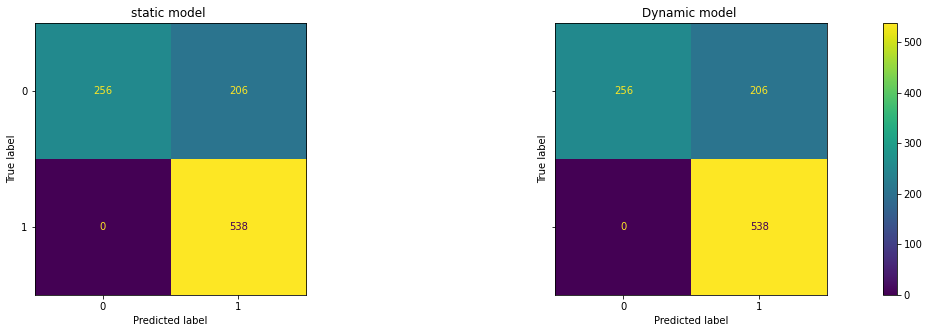

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8393
window : 162
After getting the data from the window : the f1-score of the static  model= 0.8615 
After getting the data from the window : the f1-score of the Dynamic model= 0.8625 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       467
           1       0.76      1.00      0.86       533

    accuracy                           0.83      1000
   macro avg       0.88      0.82      0.82      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       467
           1       0.76      1.00      0.86       53

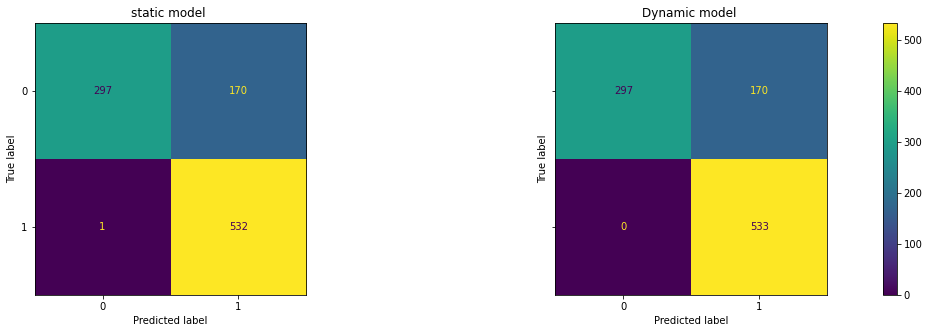

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 163
After getting the data from the window : the f1-score of the static  model= 0.8565 
After getting the data from the window : the f1-score of the Dynamic model= 0.8565 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       448
           1       0.75      1.00      0.86       552

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       448
           1       0.75      1.00      0.86       552

    accuracy                           0.81      1000
   macro avg       0.87     

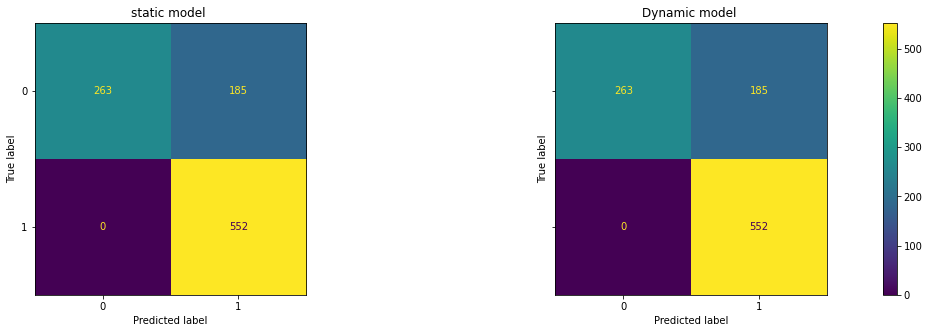

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 164
After getting the data from the window : the f1-score of the static  model= 0.8621 
After getting the data from the window : the f1-score of the Dynamic model= 0.8621 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       433
           1       0.76      1.00      0.86       567

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       433
           1       0.76      1.00      0.86       567

    accuracy                           0.82      1000
   macro avg       0.88     

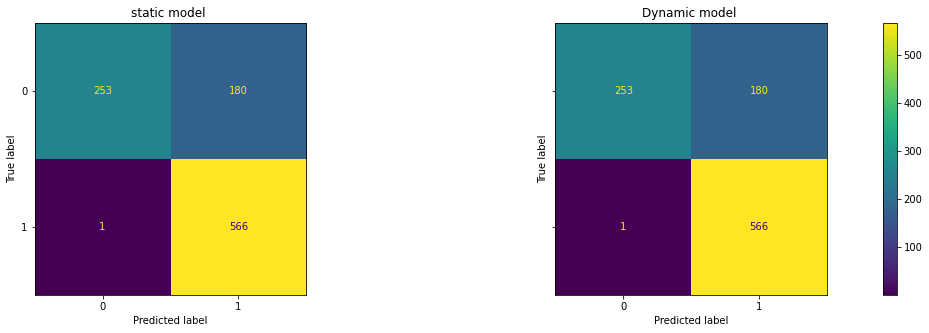

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 165
After getting the data from the window : the f1-score of the static  model= 0.8770 
After getting the data from the window : the f1-score of the Dynamic model= 0.8764 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       433
           1       0.78      1.00      0.88       567

    accuracy                           0.84      1000
   macro avg       0.89      0.82      0.83      1000
weighted avg       0.88      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       433
           1       0.78      1.00      0.88       567

    accuracy                           0.84      1000
   macro avg       0.89     

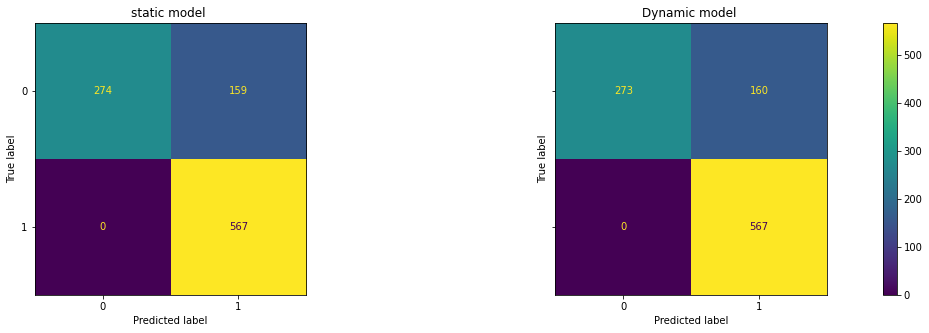

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 166
After getting the data from the window : the f1-score of the static  model= 0.8413 
After getting the data from the window : the f1-score of the Dynamic model= 0.8413 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       475
           1       0.73      1.00      0.84       525

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.86      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       475
           1       0.73      1.00      0.84       525

    accuracy                           0.80      1000
   macro avg       0.86     

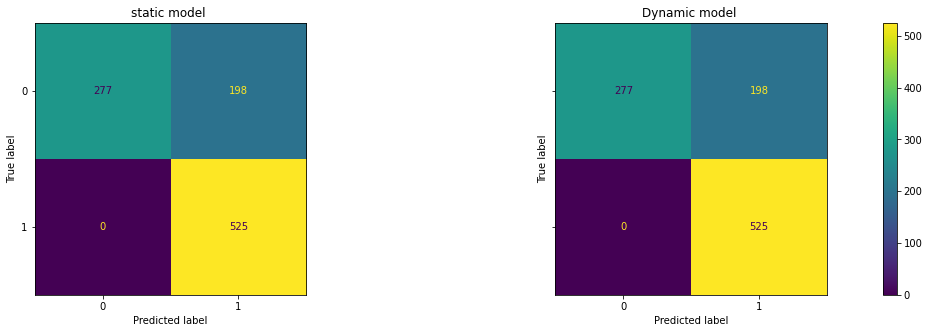

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8413
window : 167
After getting the data from the window : the f1-score of the static  model= 0.8580 
After getting the data from the window : the f1-score of the Dynamic model= 0.8580 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       456
           1       0.75      1.00      0.86       544

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       456
           1       0.75      1.00      0.86       54

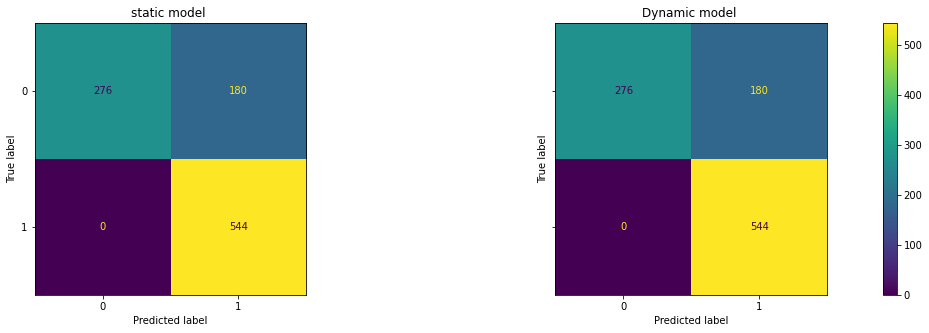

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 168
After getting the data from the window : the f1-score of the static  model= 0.8466 
After getting the data from the window : the f1-score of the Dynamic model= 0.8466 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       458
           1       0.74      1.00      0.85       542

    accuracy                           0.80      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       458
           1       0.74      1.00      0.85       542

    accuracy                           0.80      1000
   macro avg       0.87     

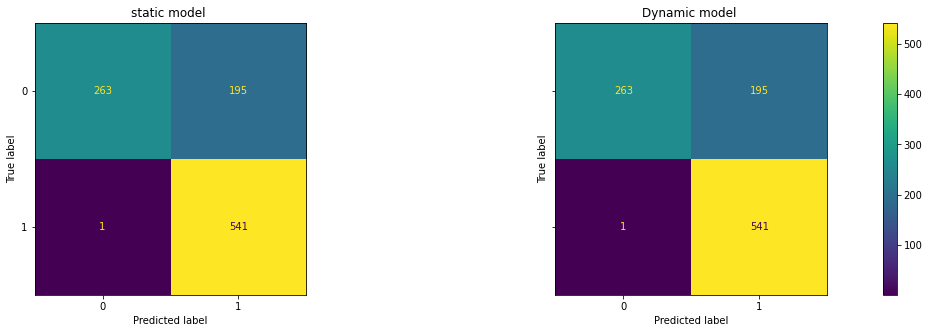

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8466
window : 169
After getting the data from the window : the f1-score of the static  model= 0.8716 
After getting the data from the window : the f1-score of the Dynamic model= 0.8731 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       429
           1       0.77      1.00      0.87       571

    accuracy                           0.83      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       429
           1       0.77      1.00      0.87       57

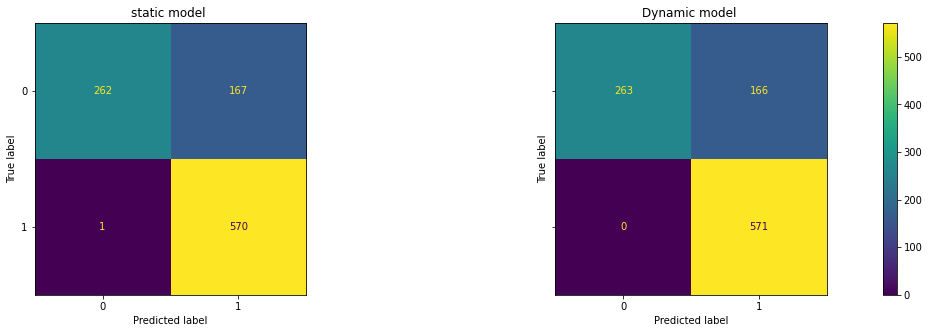

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 170
After getting the data from the window : the f1-score of the static  model= 0.8609 
After getting the data from the window : the f1-score of the Dynamic model= 0.8609 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       448
           1       0.76      1.00      0.86       552

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       448
           1       0.76      1.00      0.86       552

    accuracy                           0.82      1000
   macro avg       0.88     

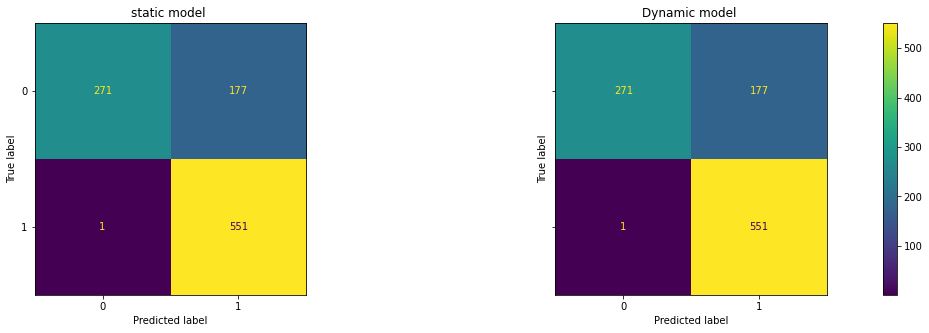

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 171
After getting the data from the window : the f1-score of the static  model= 0.8596 
After getting the data from the window : the f1-score of the Dynamic model= 0.8596 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       461
           1       0.75      1.00      0.86       539

    accuracy                           0.82      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.82      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       461
           1       0.75      1.00      0.86       539

    accuracy                           0.82      1000
   macro avg       0.88     

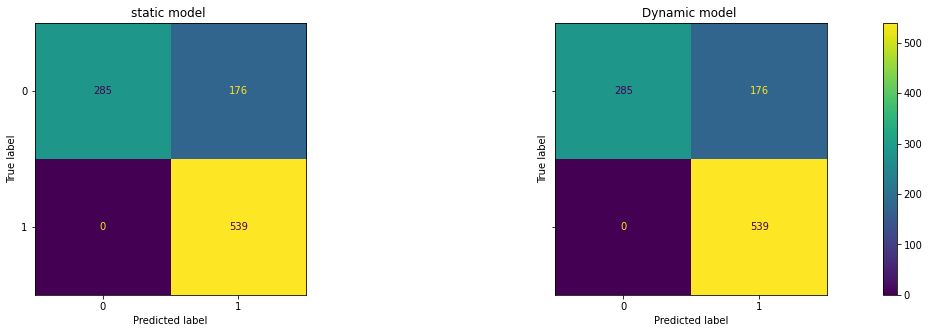

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 172
After getting the data from the window : the f1-score of the static  model= 0.8631 
After getting the data from the window : the f1-score of the Dynamic model= 0.8631 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.57      0.72       421
           1       0.76      1.00      0.86       579

    accuracy                           0.82      1000
   macro avg       0.88      0.78      0.79      1000
weighted avg       0.86      0.82      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.57      0.72       421
           1       0.76      1.00      0.86       579

    accuracy                           0.82      1000
   macro avg       0.88     

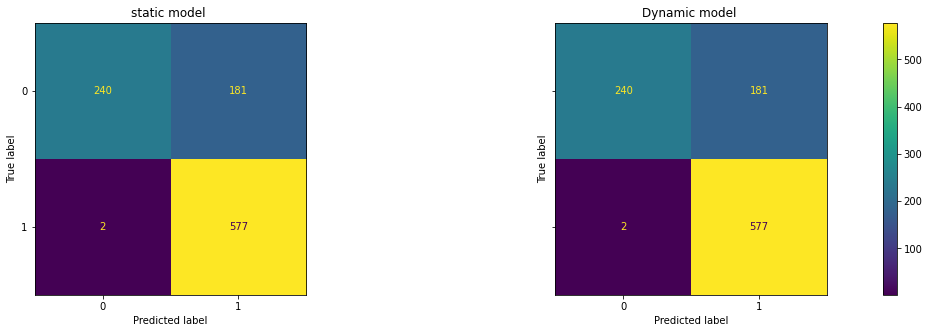

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 173
After getting the data from the window : the f1-score of the static  model= 0.8583 
After getting the data from the window : the f1-score of the Dynamic model= 0.8598 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.61      0.75       453
           1       0.75      1.00      0.86       547

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.81      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       453
           1       0.76      1.00      0.86       547

    accuracy                           0.82      1000
   macro avg       0.88     

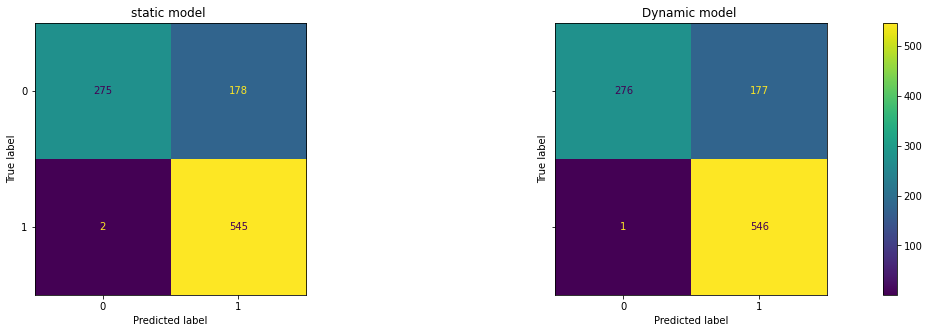

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 174
After getting the data from the window : the f1-score of the static  model= 0.8711 
After getting the data from the window : the f1-score of the Dynamic model= 0.8711 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       446
           1       0.77      1.00      0.87       554

    accuracy                           0.84      1000
   macro avg       0.89      0.82      0.82      1000
weighted avg       0.87      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       446
           1       0.77      1.00      0.87       554

    accuracy                           0.84      1000
   macro avg       0.89     

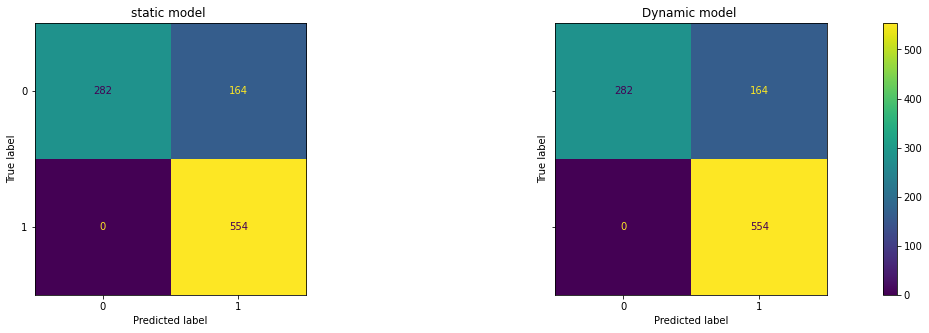

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 175
After getting the data from the window : the f1-score of the static  model= 0.8685 
After getting the data from the window : the f1-score of the Dynamic model= 0.8692 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       431
           1       0.77      1.00      0.87       569

    accuracy                           0.83      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       431
           1       0.77      1.00      0.87       569

    accuracy                           0.83      1000
   macro avg       0.88     

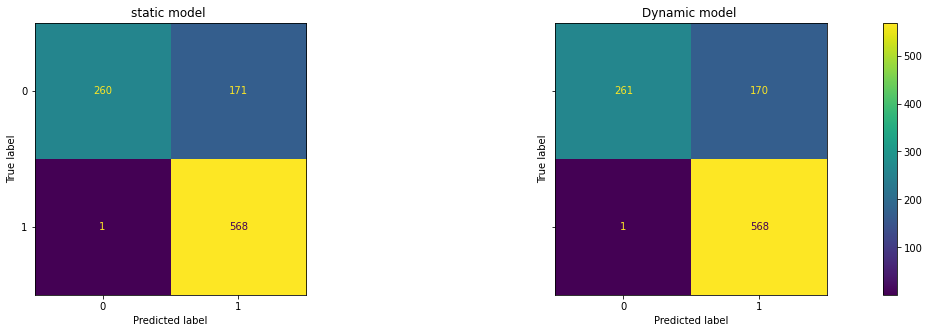

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 176
After getting the data from the window : the f1-score of the static  model= 0.8514 
After getting the data from the window : the f1-score of the Dynamic model= 0.8523 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       449
           1       0.74      1.00      0.85       551

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       449
           1       0.74      1.00      0.85       551

    accuracy                           0.81      1000
   macro avg       0.87     

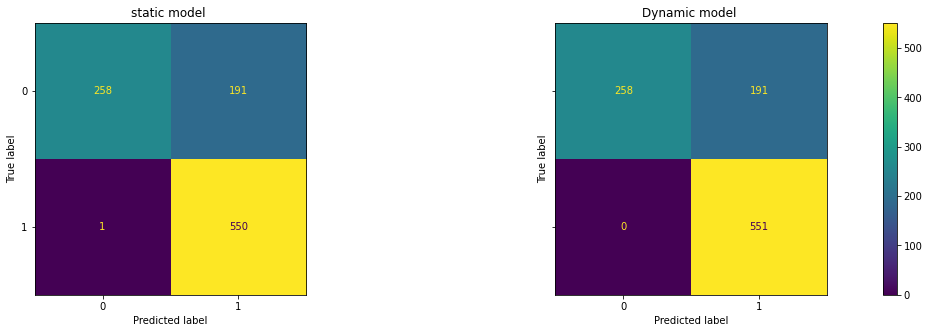

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 177
After getting the data from the window : the f1-score of the static  model= 0.8414 
After getting the data from the window : the f1-score of the Dynamic model= 0.8414 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.56      0.71       458
           1       0.73      1.00      0.84       542

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.56      0.71       458
           1       0.73      1.00      0.84       542

    accuracy                           0.80      1000
   macro avg       0.86     

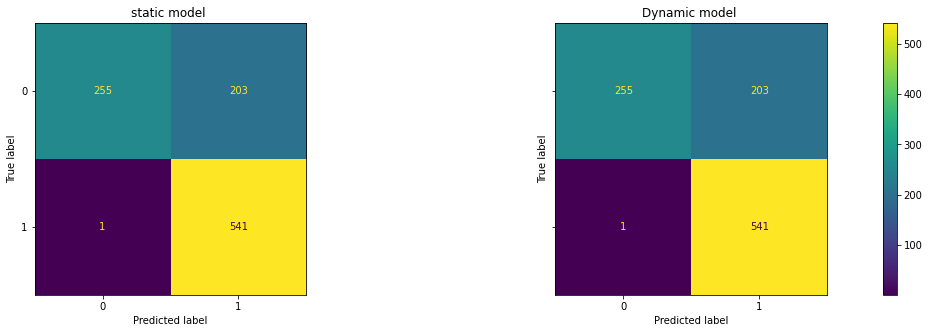

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8414
window : 178
After getting the data from the window : the f1-score of the static  model= 0.8754 
After getting the data from the window : the f1-score of the Dynamic model= 0.8754 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       438
           1       0.78      1.00      0.88       562

    accuracy                           0.84      1000
   macro avg       0.89      0.82      0.83      1000
weighted avg       0.88      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       438
           1       0.78      1.00      0.88       56

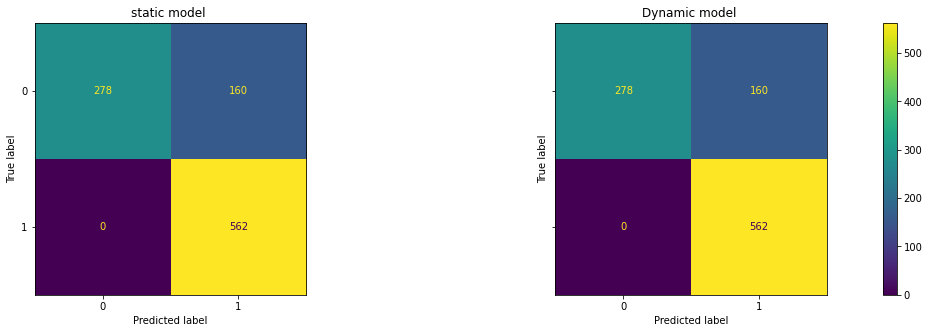

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 179
After getting the data from the window : the f1-score of the static  model= 0.8398 
After getting the data from the window : the f1-score of the Dynamic model= 0.8398 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       473
           1       0.72      1.00      0.84       527

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       473
           1       0.72      1.00      0.84       527

    accuracy                           0.80      1000
   macro avg       0.86     

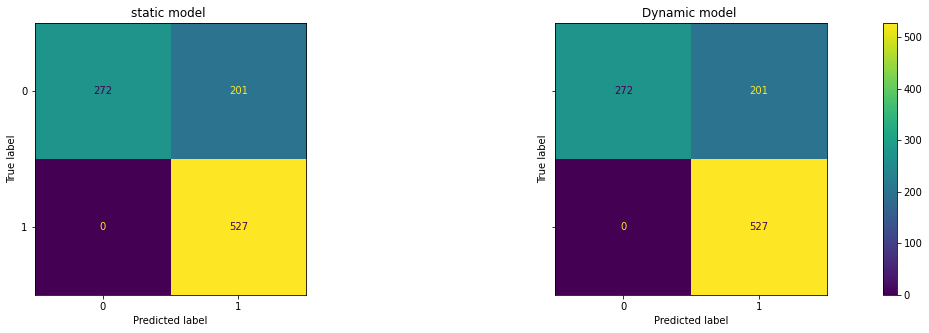

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8398
window : 180
After getting the data from the window : the f1-score of the static  model= 0.8574 
After getting the data from the window : the f1-score of the Dynamic model= 0.8574 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       465
           1       0.75      1.00      0.86       535

    accuracy                           0.82      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       465
           1       0.75      1.00      0.86       53

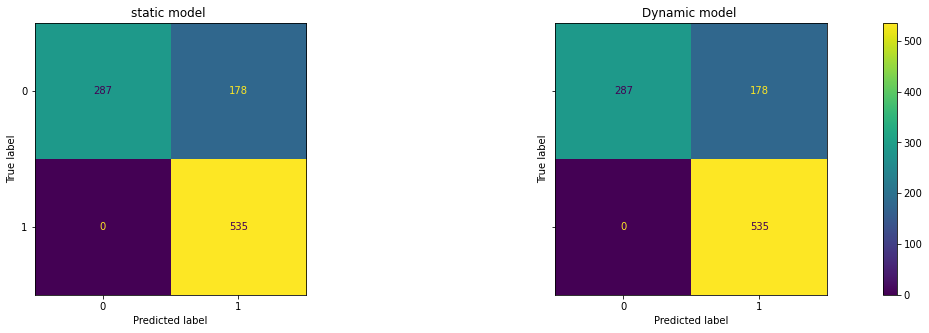

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 181
After getting the data from the window : the f1-score of the static  model= 0.8730 
After getting the data from the window : the f1-score of the Dynamic model= 0.8730 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       432
           1       0.78      1.00      0.87       568

    accuracy                           0.83      1000
   macro avg       0.89      0.81      0.82      1000
weighted avg       0.87      0.83      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       432
           1       0.78      1.00      0.87       568

    accuracy                           0.83      1000
   macro avg       0.89     

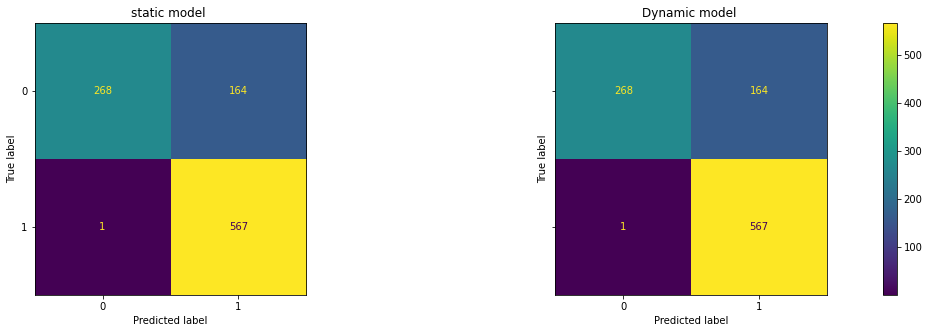

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 182
After getting the data from the window : the f1-score of the static  model= 0.8513 
After getting the data from the window : the f1-score of the Dynamic model= 0.8513 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       461
           1       0.74      1.00      0.85       539

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       461
           1       0.74      1.00      0.85       539

    accuracy                           0.81      1000
   macro avg       0.87     

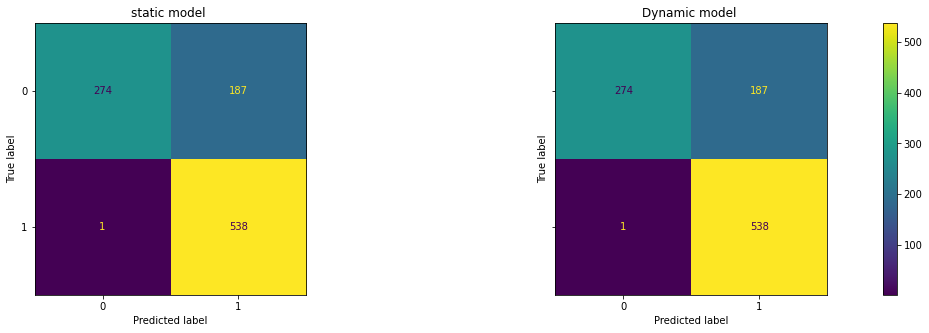

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 183
After getting the data from the window : the f1-score of the static  model= 0.8576 
After getting the data from the window : the f1-score of the Dynamic model= 0.8576 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       451
           1       0.75      1.00      0.86       549

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       451
           1       0.75      1.00      0.86       549

    accuracy                           0.82      1000
   macro avg       0.87     

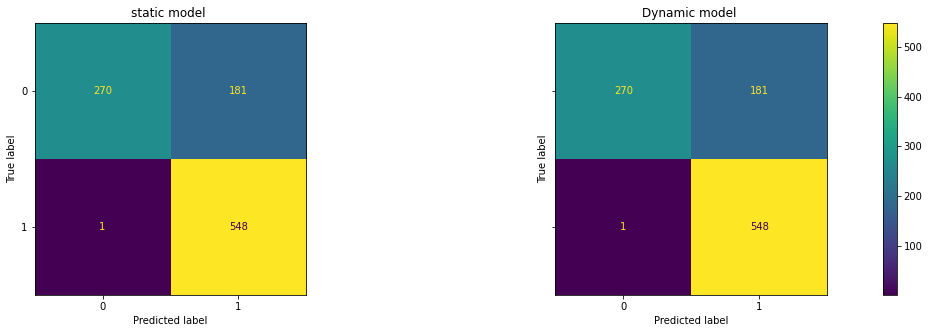

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 184
After getting the data from the window : the f1-score of the static  model= 0.8471 
After getting the data from the window : the f1-score of the Dynamic model= 0.8480 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.57      0.73       455
           1       0.74      1.00      0.85       545

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.79      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       455
           1       0.74      1.00      0.85       545

    accuracy                           0.81      1000
   macro avg       0.87     

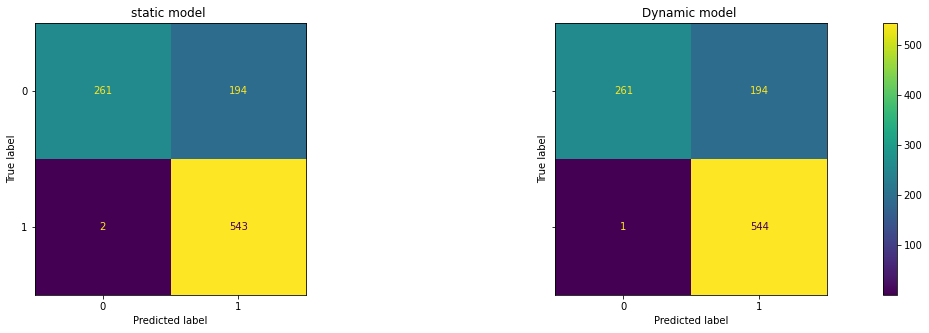

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8480
window : 185
After getting the data from the window : the f1-score of the static  model= 0.8608 
After getting the data from the window : the f1-score of the Dynamic model= 0.8615 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       434
           1       0.76      1.00      0.86       566

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       434
           1       0.76      1.00      0.86       56

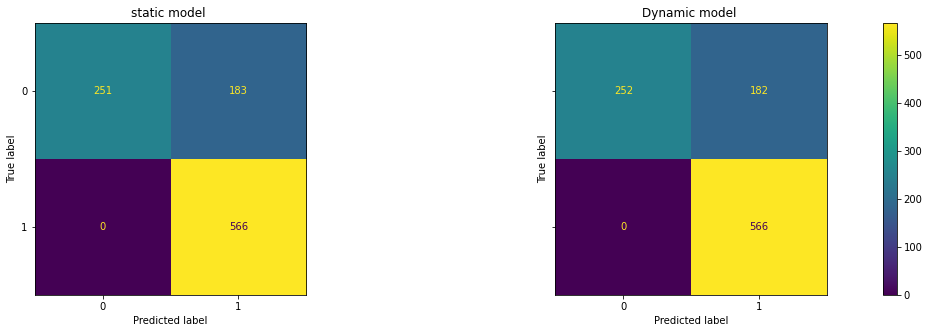

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 186
After getting the data from the window : the f1-score of the static  model= 0.8370 
After getting the data from the window : the f1-score of the Dynamic model= 0.8370 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       466
           1       0.72      1.00      0.84       534

    accuracy                           0.79      1000
   macro avg       0.86      0.78      0.77      1000
weighted avg       0.85      0.79      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       466
           1       0.72      1.00      0.84       534

    accuracy                           0.79      1000
   macro avg       0.86     

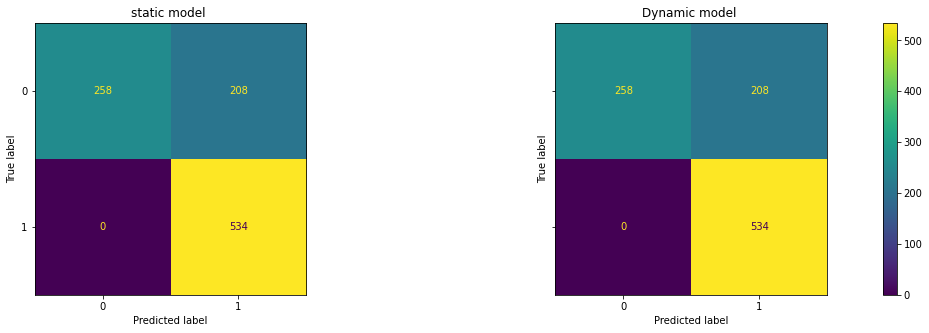

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8370
window : 187
After getting the data from the window : the f1-score of the static  model= 0.8598 
After getting the data from the window : the f1-score of the Dynamic model= 0.8598 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       451
           1       0.75      1.00      0.86       549

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       451
           1       0.75      1.00      0.86       54

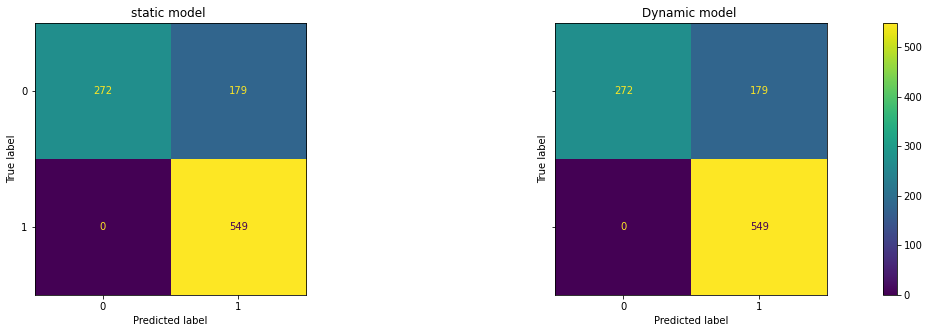

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 188
After getting the data from the window : the f1-score of the static  model= 0.8709 
After getting the data from the window : the f1-score of the Dynamic model= 0.8709 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       439
           1       0.77      1.00      0.87       561

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.82      1000
weighted avg       0.87      0.83      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       439
           1       0.77      1.00      0.87       561

    accuracy                           0.83      1000
   macro avg       0.88     

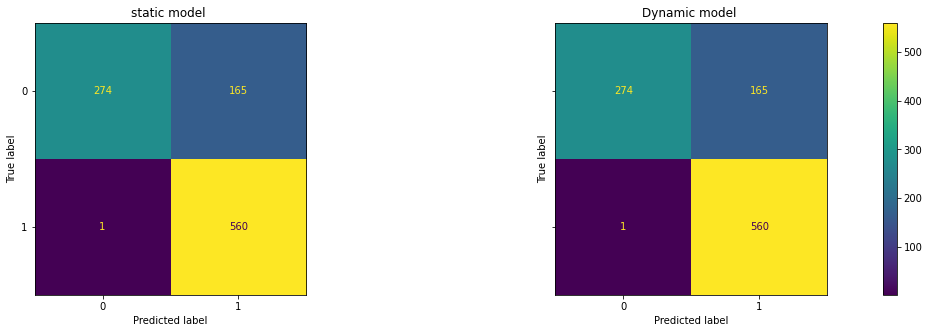

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 189
After getting the data from the window : the f1-score of the static  model= 0.8595 
After getting the data from the window : the f1-score of the Dynamic model= 0.8595 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       437
           1       0.75      1.00      0.86       563

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       437
           1       0.75      1.00      0.86       563

    accuracy                           0.82      1000
   macro avg       0.88     

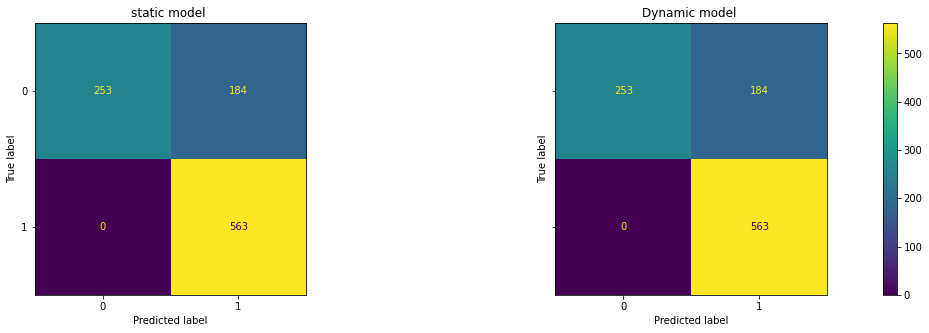

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 190
After getting the data from the window : the f1-score of the static  model= 0.8640 
After getting the data from the window : the f1-score of the Dynamic model= 0.8640 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       444
           1       0.76      1.00      0.86       556

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.82      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.75       444
           1       0.76      1.00      0.86       556

    accuracy                           0.82      1000
   macro avg       0.88     

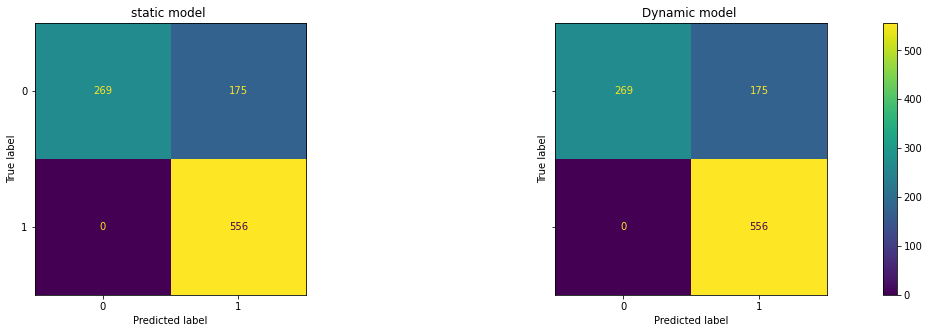

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 191
After getting the data from the window : the f1-score of the static  model= 0.8739 
After getting the data from the window : the f1-score of the Dynamic model= 0.8739 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.65      0.78       449
           1       0.78      1.00      0.87       551

    accuracy                           0.84      1000
   macro avg       0.89      0.82      0.83      1000
weighted avg       0.88      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.65      0.78       449
           1       0.78      1.00      0.87       551

    accuracy                           0.84      1000
   macro avg       0.89     

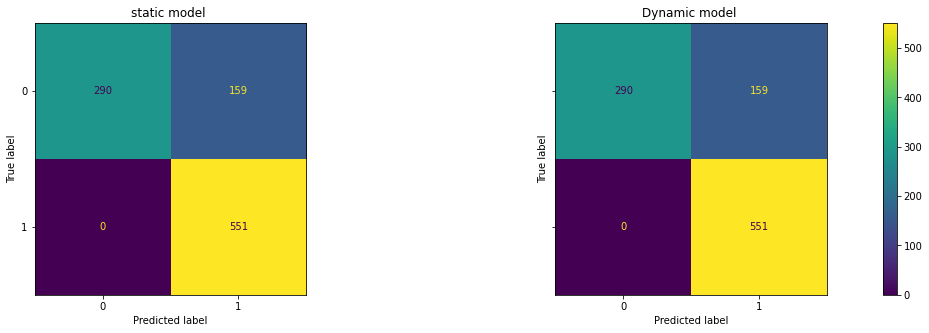

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 192
After getting the data from the window : the f1-score of the static  model= 0.8650 
After getting the data from the window : the f1-score of the Dynamic model= 0.8650 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       435
           1       0.76      1.00      0.87       565

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       435
           1       0.76      1.00      0.87       565

    accuracy                           0.82      1000
   macro avg       0.88     

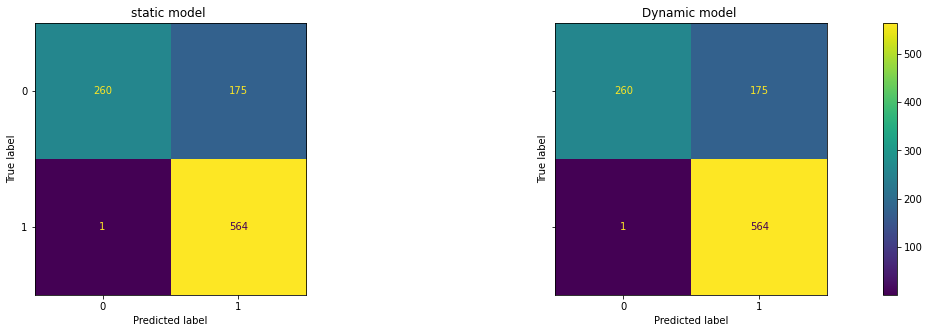

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 193
After getting the data from the window : the f1-score of the static  model= 0.8638 
After getting the data from the window : the f1-score of the Dynamic model= 0.8647 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       446
           1       0.76      1.00      0.86       554

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       446
           1       0.76      1.00      0.86       554

    accuracy                           0.83      1000
   macro avg       0.88     

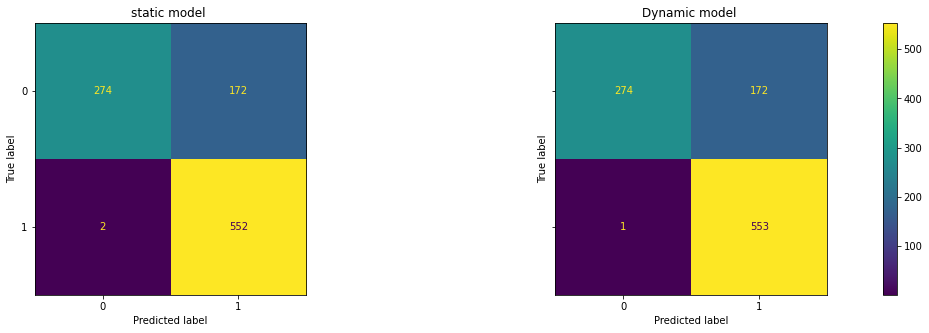

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 194
After getting the data from the window : the f1-score of the static  model= 0.8714 
After getting the data from the window : the f1-score of the Dynamic model= 0.8714 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       431
           1       0.77      1.00      0.87       569

    accuracy                           0.83      1000
   macro avg       0.89      0.81      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       431
           1       0.77      1.00      0.87       569

    accuracy                           0.83      1000
   macro avg       0.89     

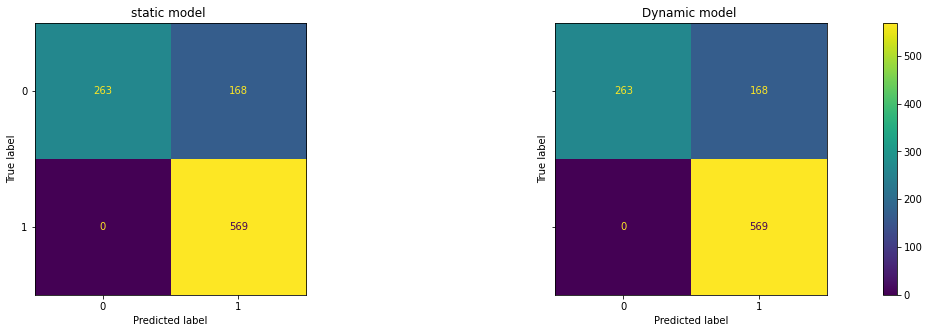

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 195
After getting the data from the window : the f1-score of the static  model= 0.8756 
After getting the data from the window : the f1-score of the Dynamic model= 0.8756 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       437
           1       0.78      1.00      0.88       563

    accuracy                           0.84      1000
   macro avg       0.89      0.82      0.83      1000
weighted avg       0.88      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       437
           1       0.78      1.00      0.88       563

    accuracy                           0.84      1000
   macro avg       0.89     

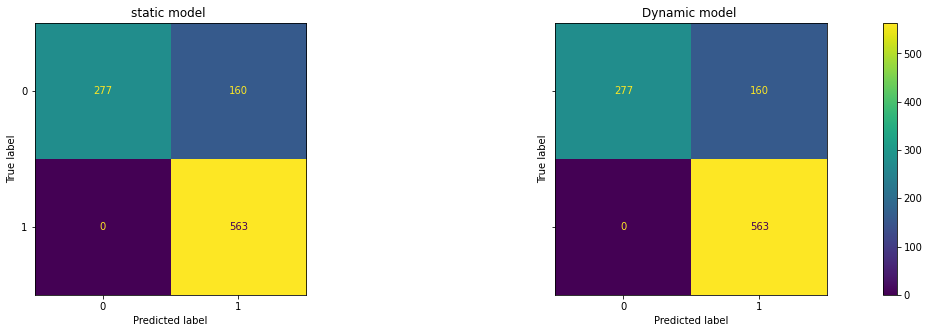

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 196
After getting the data from the window : the f1-score of the static  model= 0.8628 
After getting the data from the window : the f1-score of the Dynamic model= 0.8628 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       452
           1       0.76      1.00      0.86       548

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       452
           1       0.76      1.00      0.86       548

    accuracy                           0.83      1000
   macro avg       0.88     

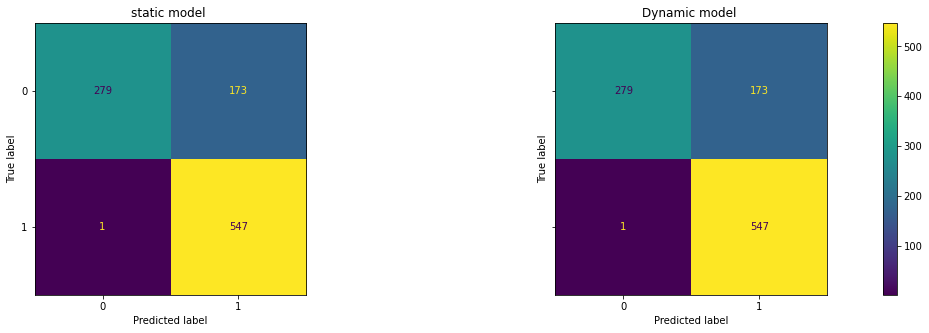

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 197
After getting the data from the window : the f1-score of the static  model= 0.8451 
After getting the data from the window : the f1-score of the Dynamic model= 0.8451 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       478
           1       0.73      1.00      0.85       522

    accuracy                           0.81      1000
   macro avg       0.86      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       478
           1       0.73      1.00      0.85       522

    accuracy                           0.81      1000
   macro avg       0.86     

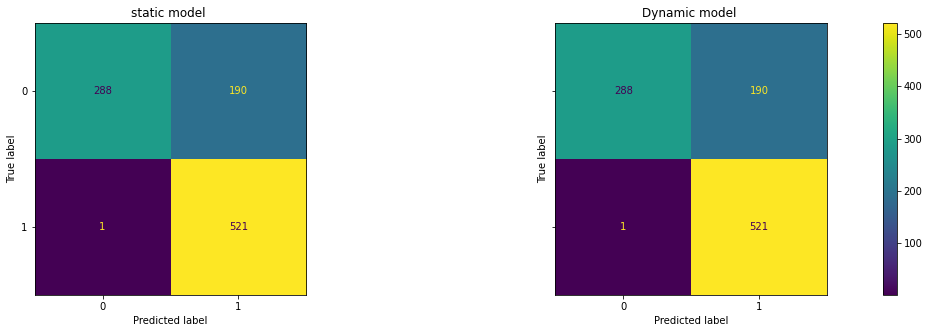

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8451
window : 198
After getting the data from the window : the f1-score of the static  model= 0.8385 
After getting the data from the window : the f1-score of the Dynamic model= 0.8385 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       468
           1       0.72      1.00      0.84       532

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       468
           1       0.72      1.00      0.84       53

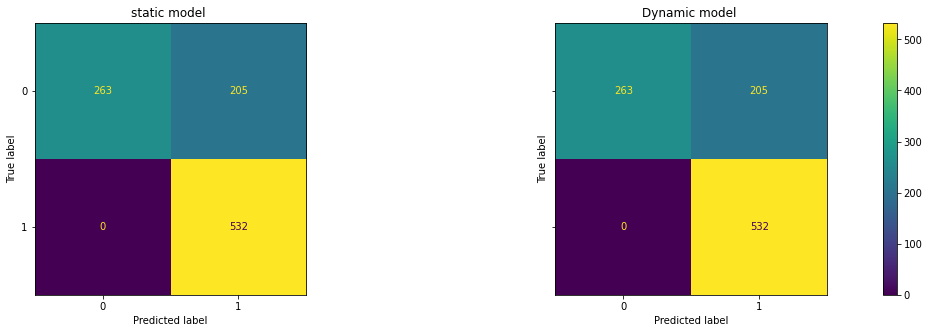

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8385
window : 199
After getting the data from the window : the f1-score of the static  model= 0.8712 
After getting the data from the window : the f1-score of the Dynamic model= 0.8712 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       452
           1       0.77      1.00      0.87       548

    accuracy                           0.84      1000
   macro avg       0.89      0.82      0.83      1000
weighted avg       0.87      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       452
           1       0.77      1.00      0.87       54

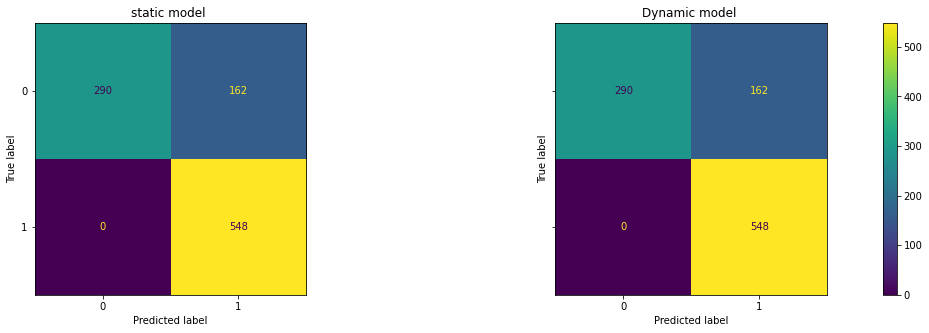

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 200
After getting the data from the window : the f1-score of the static  model= 0.8728 
After getting the data from the window : the f1-score of the Dynamic model= 0.8728 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.65      0.78       449
           1       0.78      1.00      0.87       551

    accuracy                           0.84      1000
   macro avg       0.88      0.82      0.83      1000
weighted avg       0.87      0.84      0.83      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.65      0.78       449
           1       0.78      1.00      0.87       551

    accuracy                           0.84      1000
   macro avg       0.88     

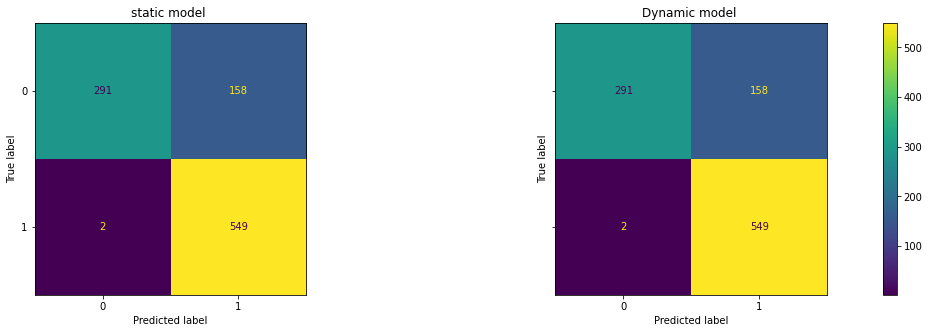

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 201
After getting the data from the window : the f1-score of the static  model= 0.8389 
After getting the data from the window : the f1-score of the Dynamic model= 0.8396 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       486
           1       0.72      1.00      0.84       514

    accuracy                           0.80      1000
   macro avg       0.86      0.80      0.79      1000
weighted avg       0.86      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       486
           1       0.72      1.00      0.84       514

    accuracy                           0.80      1000
   macro avg       0.86     

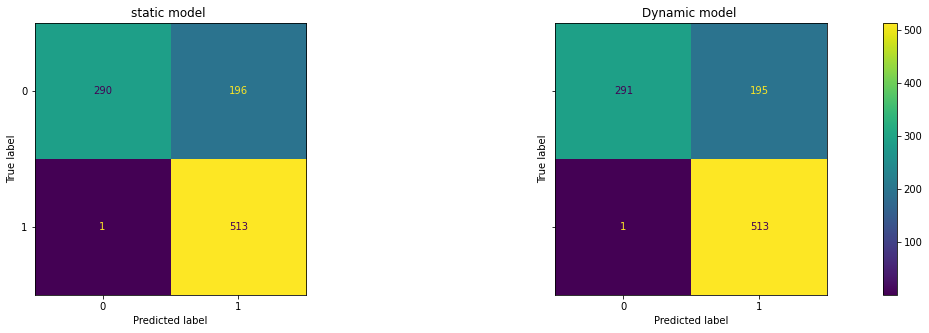

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8396
window : 202
After getting the data from the window : the f1-score of the static  model= 0.8436 
After getting the data from the window : the f1-score of the Dynamic model= 0.8436 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       474
           1       0.73      1.00      0.84       526

    accuracy                           0.81      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.86      0.81      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       474
           1       0.73      1.00      0.84       52

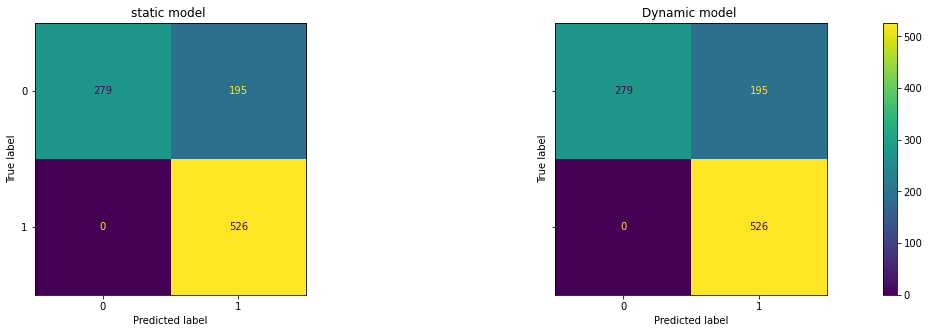

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8436
window : 203
After getting the data from the window : the f1-score of the static  model= 0.8671 
After getting the data from the window : the f1-score of the Dynamic model= 0.8671 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       426
           1       0.77      1.00      0.87       574

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       426
           1       0.77      1.00      0.87       57

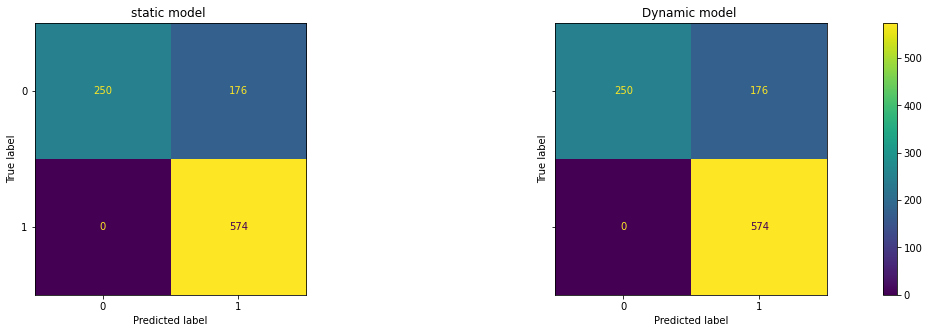

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 204
After getting the data from the window : the f1-score of the static  model= 0.8571 
After getting the data from the window : the f1-score of the Dynamic model= 0.8571 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       465
           1       0.75      1.00      0.86       535

    accuracy                           0.82      1000
   macro avg       0.87      0.81      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       465
           1       0.75      1.00      0.86       535

    accuracy                           0.82      1000
   macro avg       0.87     

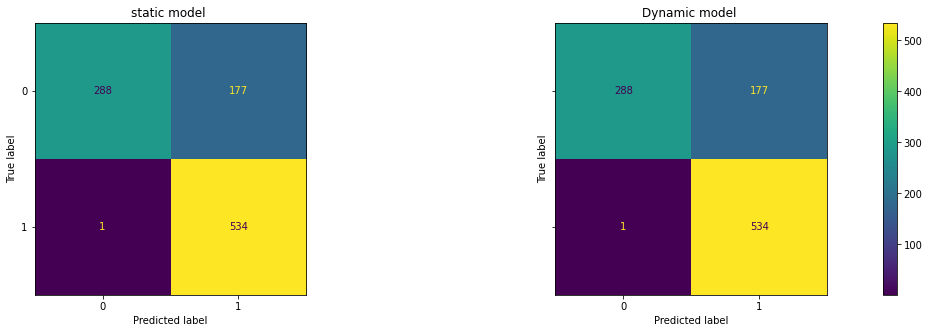

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 205
After getting the data from the window : the f1-score of the static  model= 0.8513 
After getting the data from the window : the f1-score of the Dynamic model= 0.8513 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       456
           1       0.74      1.00      0.85       544

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       456
           1       0.74      1.00      0.85       544

    accuracy                           0.81      1000
   macro avg       0.87     

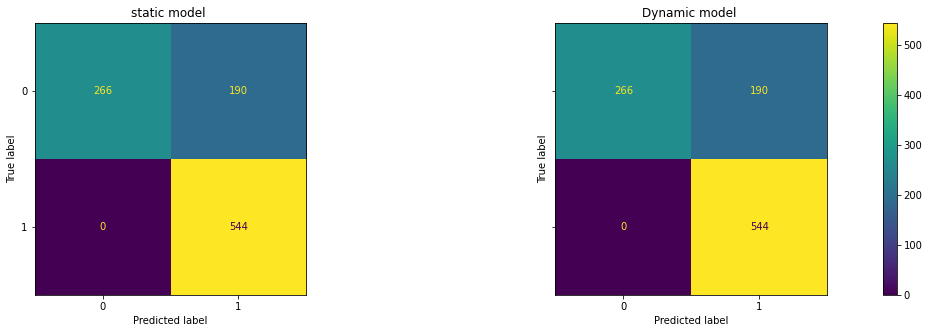

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 206
After getting the data from the window : the f1-score of the static  model= 0.8371 
After getting the data from the window : the f1-score of the Dynamic model= 0.8371 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       475
           1       0.72      1.00      0.84       525

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.78      1000
weighted avg       0.85      0.80      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       475
           1       0.72      1.00      0.84       525

    accuracy                           0.80      1000
   macro avg       0.86     

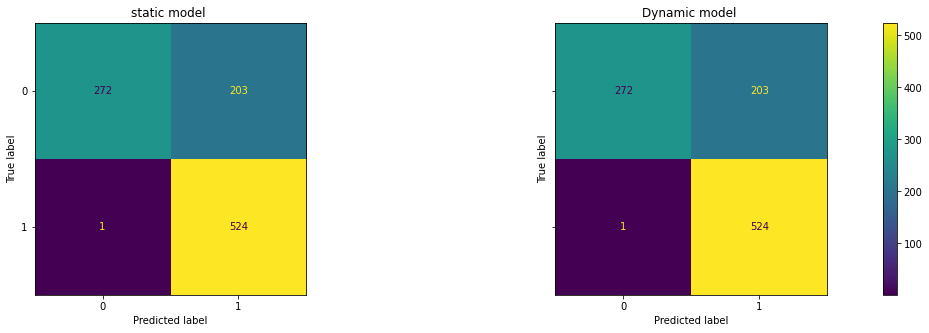

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8371
window : 207
After getting the data from the window : the f1-score of the static  model= 0.8659 
After getting the data from the window : the f1-score of the Dynamic model= 0.8659 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       451
           1       0.76      1.00      0.87       549

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.82      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       451
           1       0.76      1.00      0.87       54

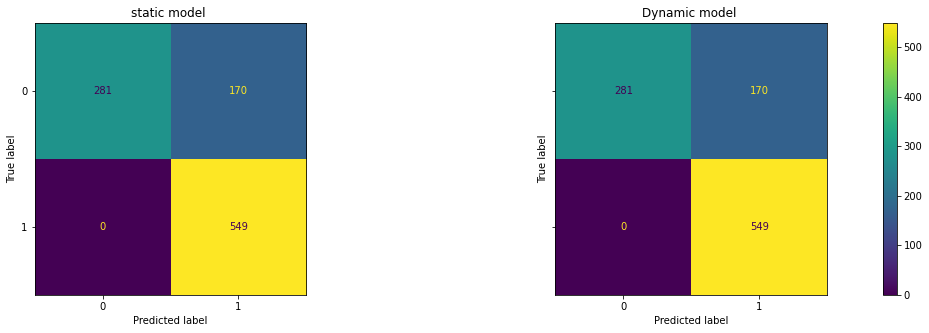

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 208
After getting the data from the window : the f1-score of the static  model= 0.8471 
After getting the data from the window : the f1-score of the Dynamic model= 0.8471 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       466
           1       0.74      1.00      0.85       534

    accuracy                           0.81      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       466
           1       0.74      1.00      0.85       534

    accuracy                           0.81      1000
   macro avg       0.86     

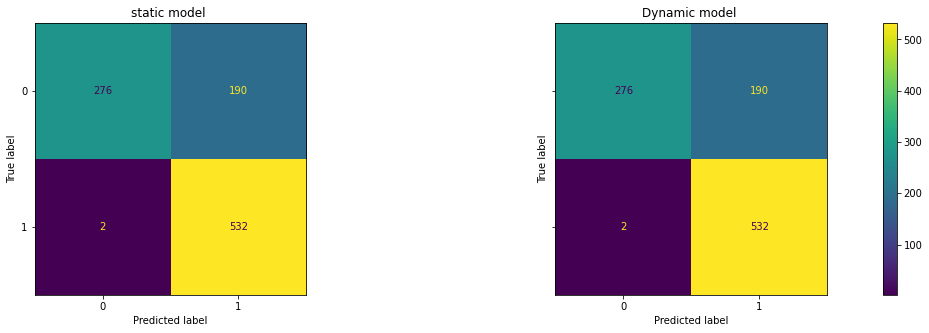

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8471
window : 209
After getting the data from the window : the f1-score of the static  model= 0.8452 
After getting the data from the window : the f1-score of the Dynamic model= 0.8452 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       471
           1       0.73      1.00      0.85       529

    accuracy                           0.81      1000
   macro avg       0.86      0.80      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       471
           1       0.73      1.00      0.85       52

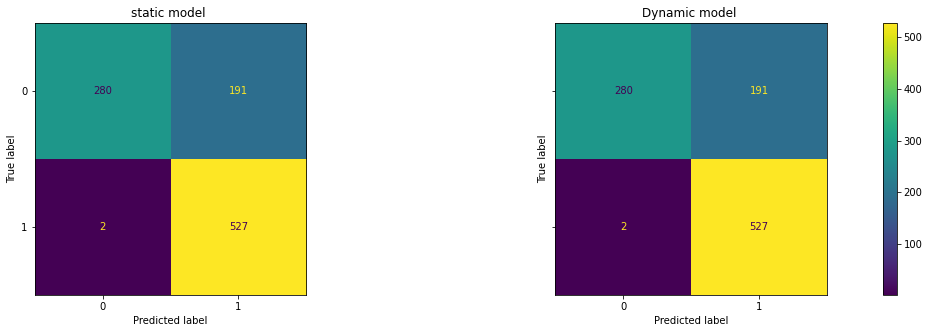

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8452
window : 210
After getting the data from the window : the f1-score of the static  model= 0.8647 
After getting the data from the window : the f1-score of the Dynamic model= 0.8647 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       441
           1       0.76      1.00      0.86       559

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.82      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       441
           1       0.76      1.00      0.86       55

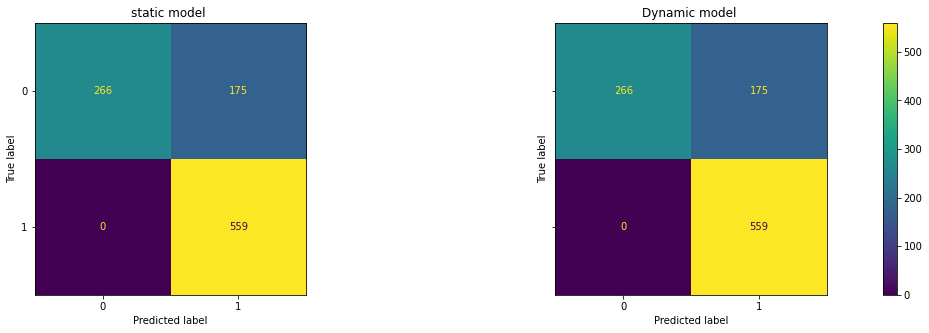

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 211
After getting the data from the window : the f1-score of the static  model= 0.8531 
After getting the data from the window : the f1-score of the Dynamic model= 0.8531 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       453
           1       0.74      1.00      0.85       547

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       453
           1       0.74      1.00      0.85       547

    accuracy                           0.81      1000
   macro avg       0.87     

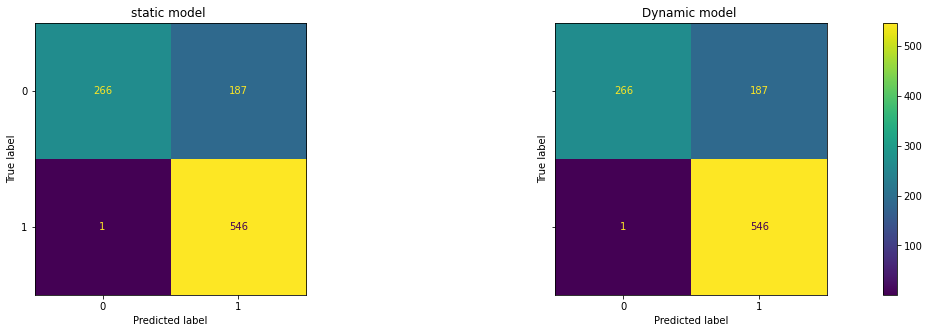

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 212
After getting the data from the window : the f1-score of the static  model= 0.8520 
After getting the data from the window : the f1-score of the Dynamic model= 0.8520 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       454
           1       0.74      1.00      0.85       546

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       454
           1       0.74      1.00      0.85       546

    accuracy                           0.81      1000
   macro avg       0.87     

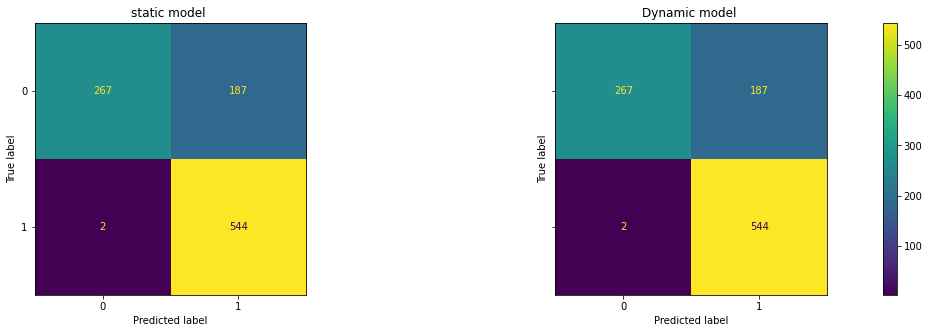

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 213
After getting the data from the window : the f1-score of the static  model= 0.8626 
After getting the data from the window : the f1-score of the Dynamic model= 0.8626 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       457
           1       0.76      1.00      0.86       543

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       457
           1       0.76      1.00      0.86       543

    accuracy                           0.83      1000
   macro avg       0.88     

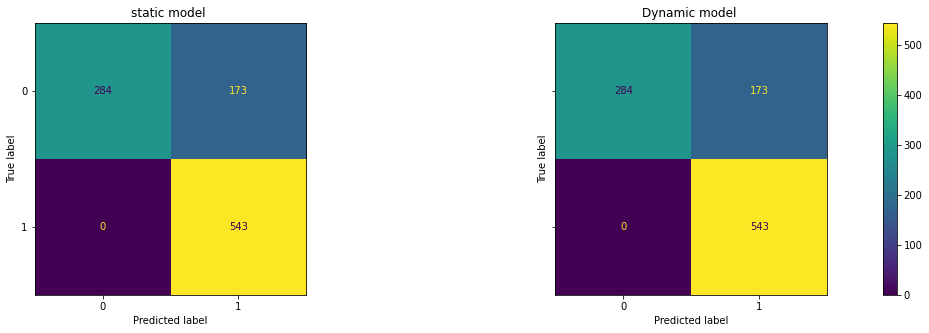

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 214
After getting the data from the window : the f1-score of the static  model= 0.8319 
After getting the data from the window : the f1-score of the Dynamic model= 0.8319 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       473
           1       0.71      1.00      0.83       527

    accuracy                           0.79      1000
   macro avg       0.86      0.77      0.77      1000
weighted avg       0.85      0.79      0.77      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       473
           1       0.71      1.00      0.83       527

    accuracy                           0.79      1000
   macro avg       0.86     

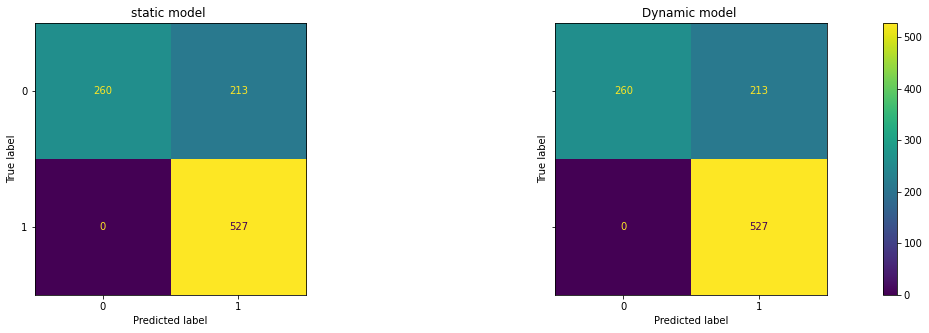

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8319
window : 215
After getting the data from the window : the f1-score of the static  model= 0.8406 
After getting the data from the window : the f1-score of the Dynamic model= 0.8406 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       478
           1       0.72      1.00      0.84       522

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.79      1000
weighted avg       0.86      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       478
           1       0.72      1.00      0.84       52

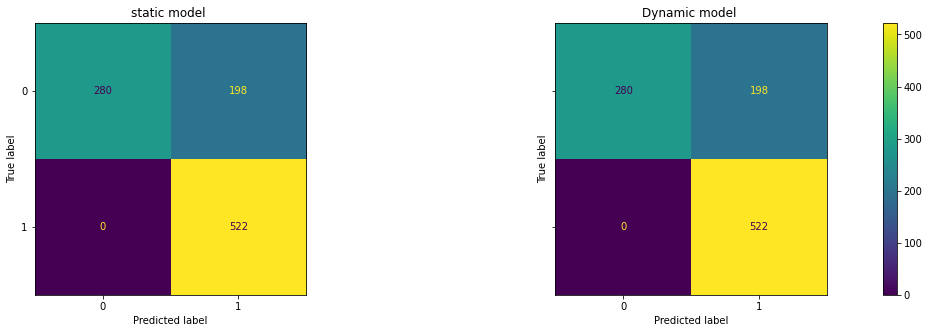

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8406
window : 216
After getting the data from the window : the f1-score of the static  model= 0.8666 
After getting the data from the window : the f1-score of the Dynamic model= 0.8666 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.58      0.73       420
           1       0.77      1.00      0.87       580

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.58      0.73       420
           1       0.77      1.00      0.87       58

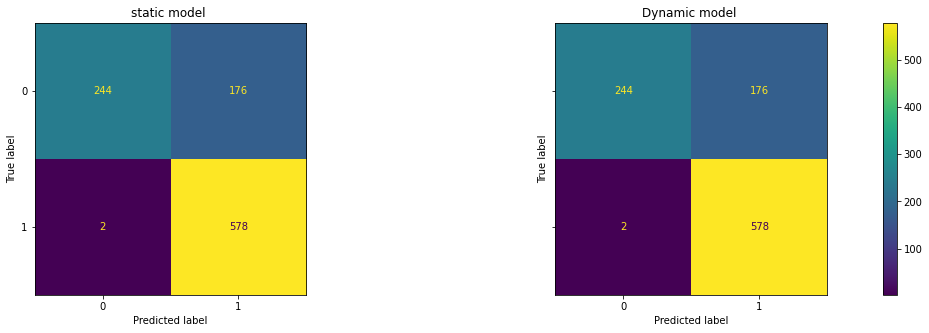

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 217
After getting the data from the window : the f1-score of the static  model= 0.8613 
After getting the data from the window : the f1-score of the Dynamic model= 0.8623 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       471
           1       0.76      1.00      0.86       529

    accuracy                           0.83      1000
   macro avg       0.88      0.82      0.82      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       471
           1       0.76      1.00      0.86       529

    accuracy                           0.83      1000
   macro avg       0.88     

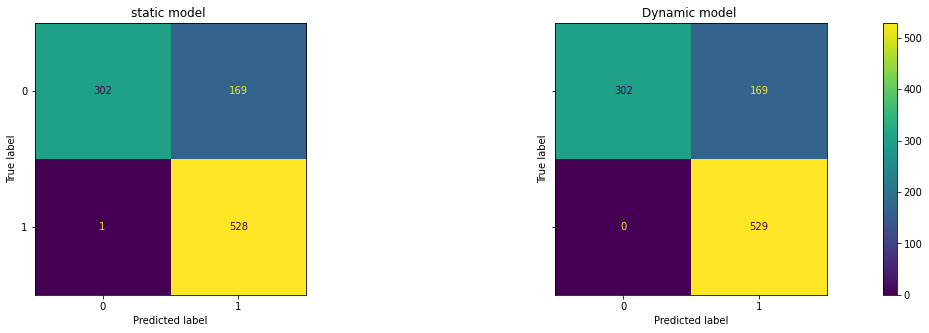

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 218
After getting the data from the window : the f1-score of the static  model= 0.8620 
After getting the data from the window : the f1-score of the Dynamic model= 0.8629 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       442
           1       0.76      1.00      0.86       558

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       442
           1       0.76      1.00      0.86       558

    accuracy                           0.82      1000
   macro avg       0.88     

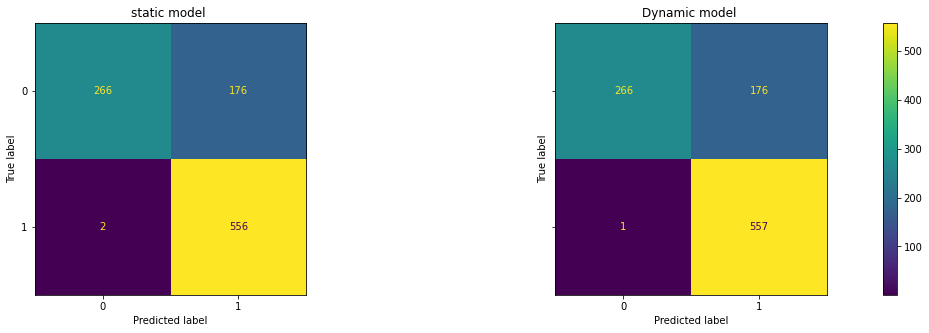

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 219
After getting the data from the window : the f1-score of the static  model= 0.8578 
After getting the data from the window : the f1-score of the Dynamic model= 0.8578 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       442
           1       0.75      1.00      0.86       558

    accuracy                           0.81      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       442
           1       0.75      1.00      0.86       558

    accuracy                           0.81      1000
   macro avg       0.88     

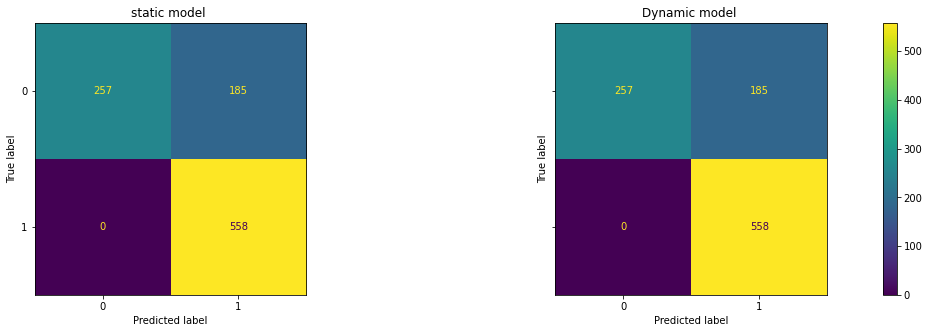

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 220
After getting the data from the window : the f1-score of the static  model= 0.8646 
After getting the data from the window : the f1-score of the Dynamic model= 0.8646 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       451
           1       0.76      1.00      0.86       549

    accuracy                           0.83      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       451
           1       0.76      1.00      0.86       549

    accuracy                           0.83      1000
   macro avg       0.88     

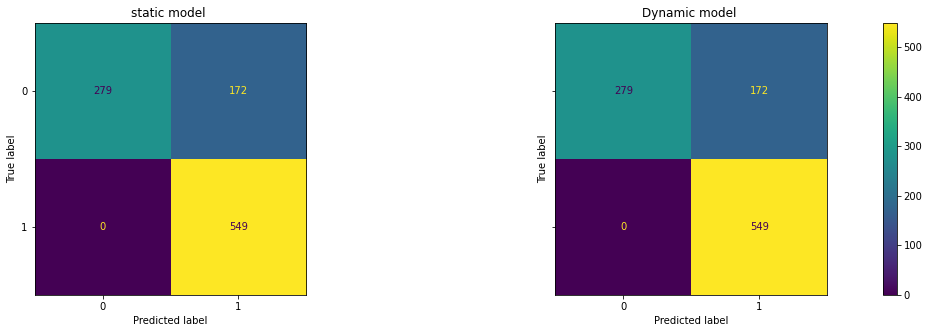

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 221
After getting the data from the window : the f1-score of the static  model= 0.8531 
After getting the data from the window : the f1-score of the Dynamic model= 0.8540 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       456
           1       0.74      1.00      0.85       544

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       456
           1       0.75      1.00      0.85       544

    accuracy                           0.81      1000
   macro avg       0.87     

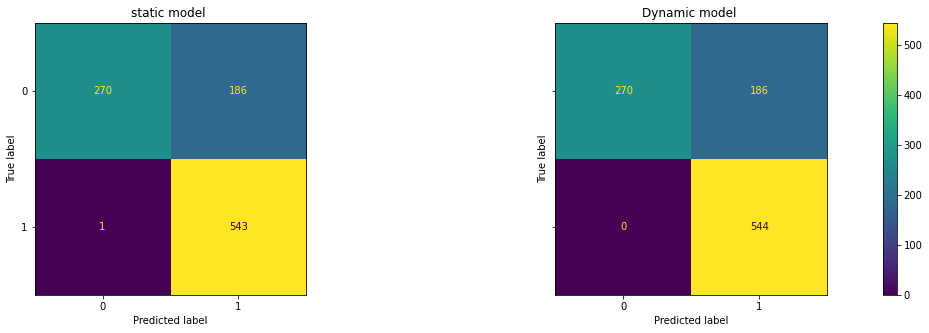

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 222
After getting the data from the window : the f1-score of the static  model= 0.8599 
After getting the data from the window : the f1-score of the Dynamic model= 0.8599 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       457
           1       0.75      1.00      0.86       543

    accuracy                           0.82      1000
   macro avg       0.88      0.81      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       457
           1       0.75      1.00      0.86       543

    accuracy                           0.82      1000
   macro avg       0.88     

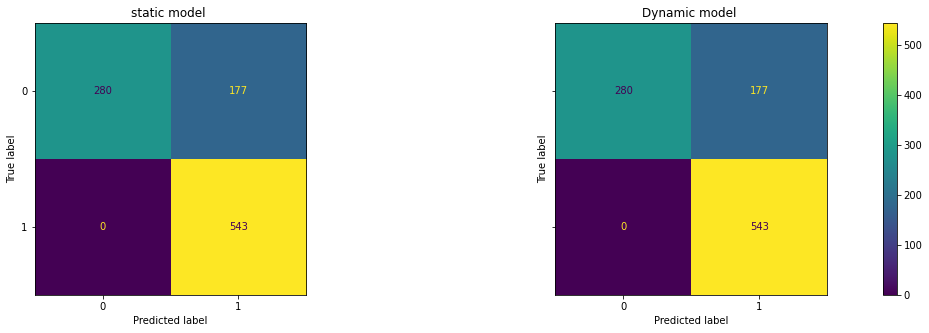

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 223
After getting the data from the window : the f1-score of the static  model= 0.8521 
After getting the data from the window : the f1-score of the Dynamic model= 0.8521 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.52      0.69       421
           1       0.74      1.00      0.85       579

    accuracy                           0.80      1000
   macro avg       0.87      0.76      0.77      1000
weighted avg       0.85      0.80      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.52      0.69       421
           1       0.74      1.00      0.85       579

    accuracy                           0.80      1000
   macro avg       0.87     

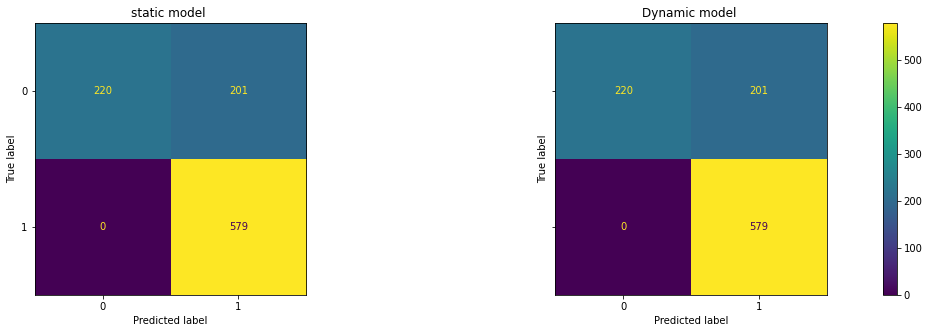

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 224
After getting the data from the window : the f1-score of the static  model= 0.8549 
After getting the data from the window : the f1-score of the Dynamic model= 0.8558 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       456
           1       0.75      1.00      0.85       544

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       456
           1       0.75      1.00      0.86       544

    accuracy                           0.82      1000
   macro avg       0.87     

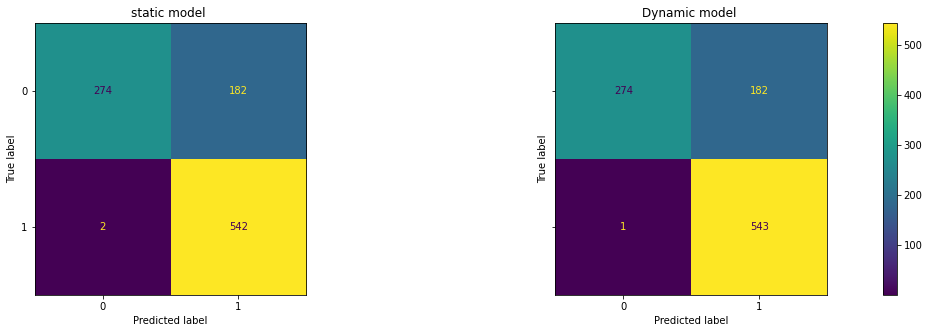

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 225
After getting the data from the window : the f1-score of the static  model= 0.8410 
After getting the data from the window : the f1-score of the Dynamic model= 0.8417 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       463
           1       0.73      1.00      0.84       537

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       463
           1       0.73      1.00      0.84       537

    accuracy                           0.80      1000
   macro avg       0.86     

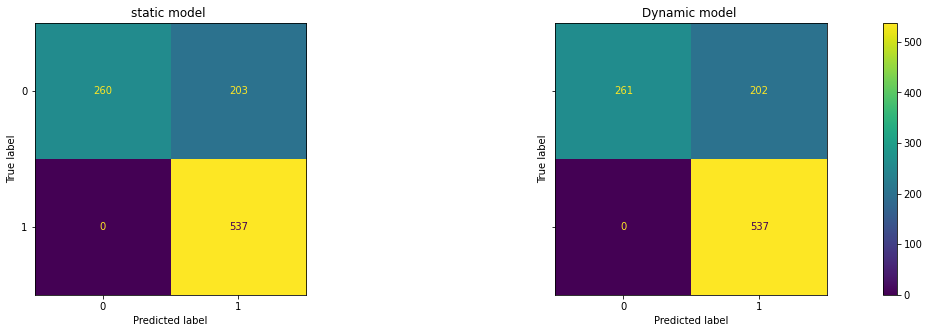

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8417
window : 226
After getting the data from the window : the f1-score of the static  model= 0.8552 
After getting the data from the window : the f1-score of the Dynamic model= 0.8552 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       448
           1       0.75      1.00      0.86       552

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       448
           1       0.75      1.00      0.86       55

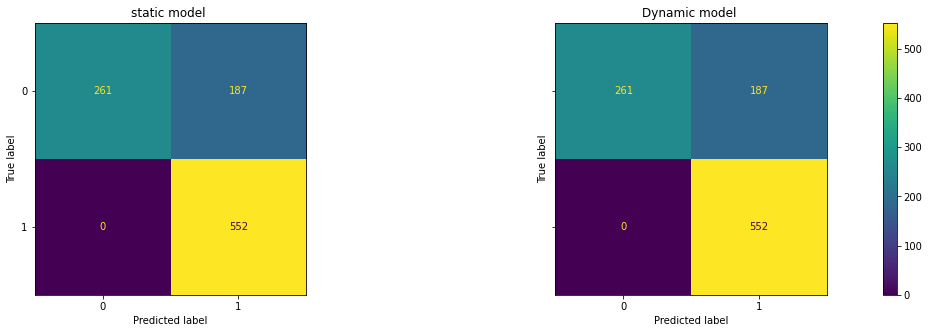

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 227
After getting the data from the window : the f1-score of the static  model= 0.8732 
After getting the data from the window : the f1-score of the Dynamic model= 0.8732 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       423
           1       0.78      1.00      0.87       577

    accuracy                           0.83      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       423
           1       0.78      1.00      0.87       577

    accuracy                           0.83      1000
   macro avg       0.88     

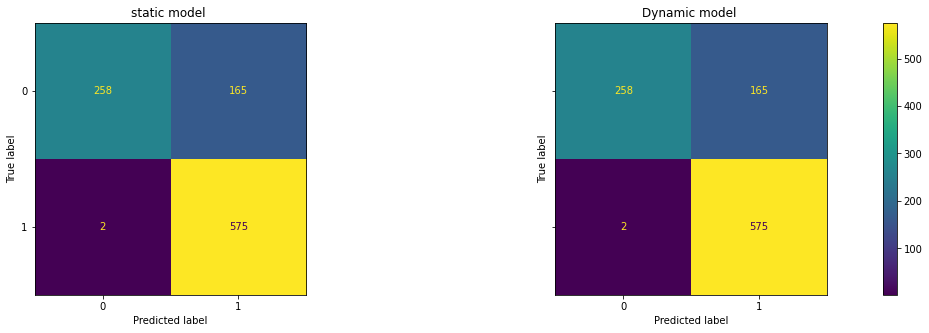

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 228
After getting the data from the window : the f1-score of the static  model= 0.8565 
After getting the data from the window : the f1-score of the Dynamic model= 0.8565 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       445
           1       0.75      1.00      0.86       555

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       445
           1       0.75      1.00      0.86       555

    accuracy                           0.81      1000
   macro avg       0.87     

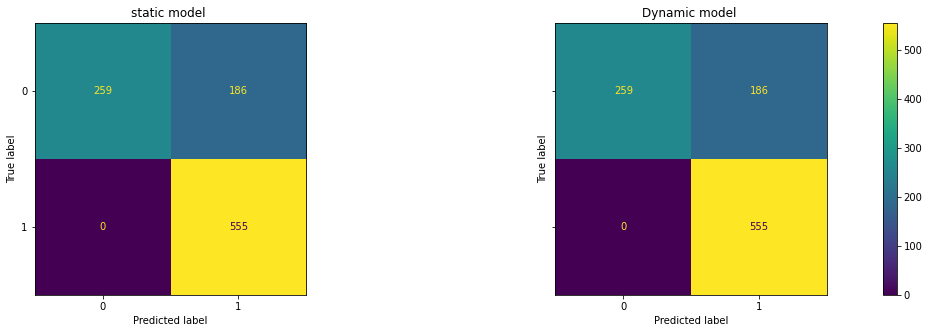

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 229
After getting the data from the window : the f1-score of the static  model= 0.8420 
After getting the data from the window : the f1-score of the Dynamic model= 0.8429 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.57      0.73       465
           1       0.73      1.00      0.84       535

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       465
           1       0.73      1.00      0.84       535

    accuracy                           0.80      1000
   macro avg       0.86     

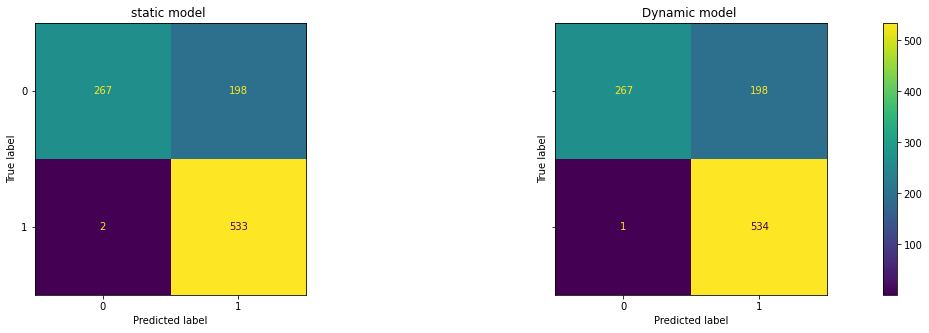

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8429
window : 230
After getting the data from the window : the f1-score of the static  model= 0.8636 
After getting the data from the window : the f1-score of the Dynamic model= 0.8644 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       442
           1       0.76      1.00      0.86       558

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       442
           1       0.76      1.00      0.86       55

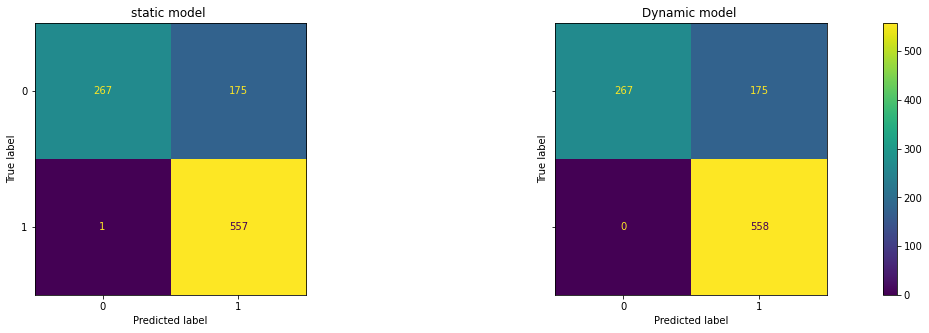

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 231
After getting the data from the window : the f1-score of the static  model= 0.8553 
After getting the data from the window : the f1-score of the Dynamic model= 0.8546 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       468
           1       0.75      1.00      0.86       532

    accuracy                           0.82      1000
   macro avg       0.87      0.81      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       468
           1       0.75      1.00      0.85       532

    accuracy                           0.82      1000
   macro avg       0.87     

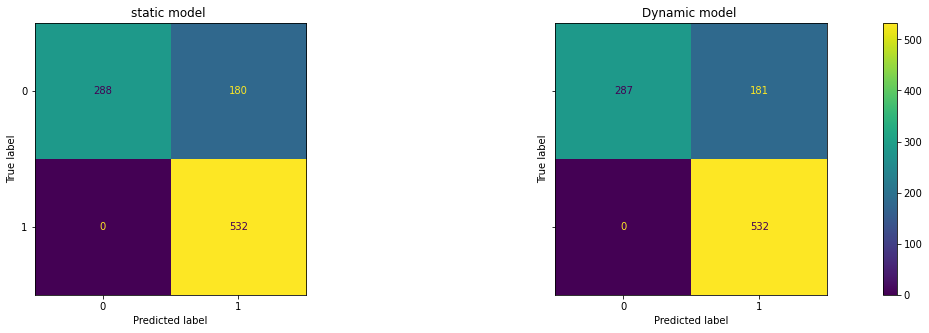

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 232
After getting the data from the window : the f1-score of the static  model= 0.8624 
After getting the data from the window : the f1-score of the Dynamic model= 0.8624 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       437
           1       0.76      1.00      0.86       563

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       437
           1       0.76      1.00      0.86       563

    accuracy                           0.82      1000
   macro avg       0.88     

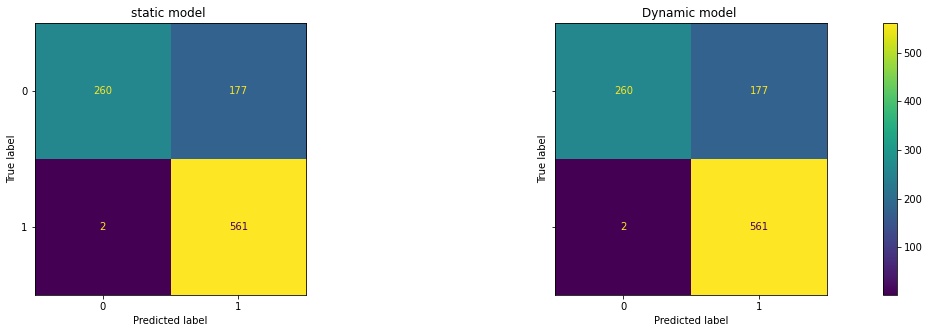

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 233
After getting the data from the window : the f1-score of the static  model= 0.8425 
After getting the data from the window : the f1-score of the Dynamic model= 0.8425 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       464
           1       0.73      1.00      0.84       536

    accuracy                           0.80      1000
   macro avg       0.86      0.78      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       464
           1       0.73      1.00      0.84       536

    accuracy                           0.80      1000
   macro avg       0.86     

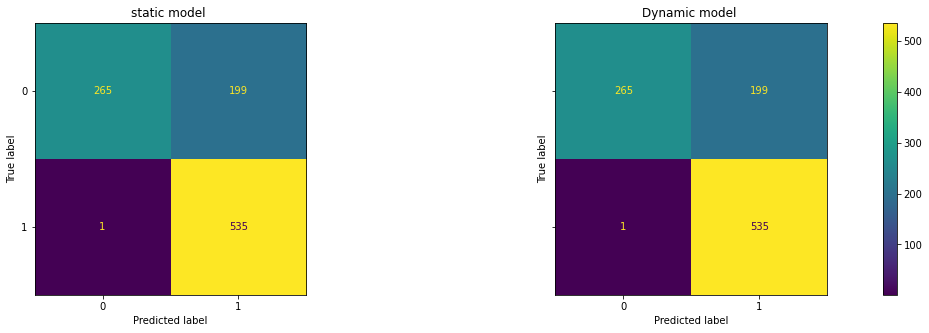

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8425
window : 234
After getting the data from the window : the f1-score of the static  model= 0.8560 
After getting the data from the window : the f1-score of the Dynamic model= 0.8578 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       453
           1       0.75      0.99      0.86       547

    accuracy                           0.82      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       453
           1       0.75      1.00      0.86       54

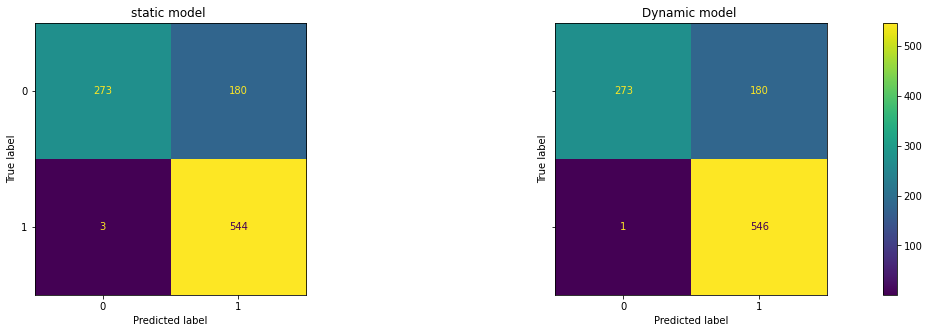

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 235
After getting the data from the window : the f1-score of the static  model= 0.8533 
After getting the data from the window : the f1-score of the Dynamic model= 0.8542 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       454
           1       0.75      1.00      0.85       546

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.59      0.74       454
           1       0.75      1.00      0.85       546

    accuracy                           0.81      1000
   macro avg       0.87     

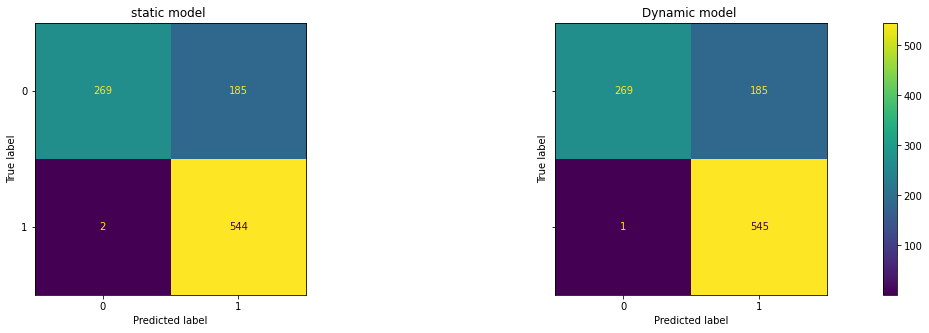

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 236
After getting the data from the window : the f1-score of the static  model= 0.8483 
After getting the data from the window : the f1-score of the Dynamic model= 0.8492 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       448
           1       0.74      1.00      0.85       552

    accuracy                           0.80      1000
   macro avg       0.87      0.78      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       448
           1       0.74      1.00      0.85       552

    accuracy                           0.80      1000
   macro avg       0.87     

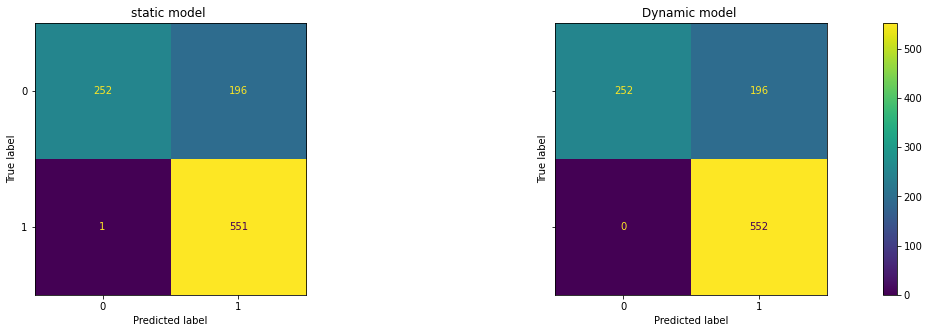

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8492
window : 237
After getting the data from the window : the f1-score of the static  model= 0.8370 
After getting the data from the window : the f1-score of the Dynamic model= 0.8370 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.54      0.71       461
           1       0.72      1.00      0.84       539

    accuracy                           0.79      1000
   macro avg       0.86      0.77      0.77      1000
weighted avg       0.85      0.79      0.78      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.54      0.71       461
           1       0.72      1.00      0.84       53

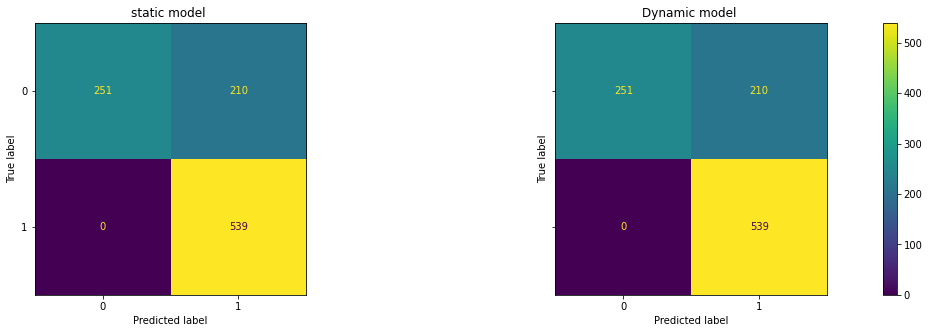

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8370
window : 238
After getting the data from the window : the f1-score of the static  model= 0.8509 
After getting the data from the window : the f1-score of the Dynamic model= 0.8516 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       475
           1       0.74      1.00      0.85       525

    accuracy                           0.82      1000
   macro avg       0.87      0.81      0.81      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       475
           1       0.74      1.00      0.85       52

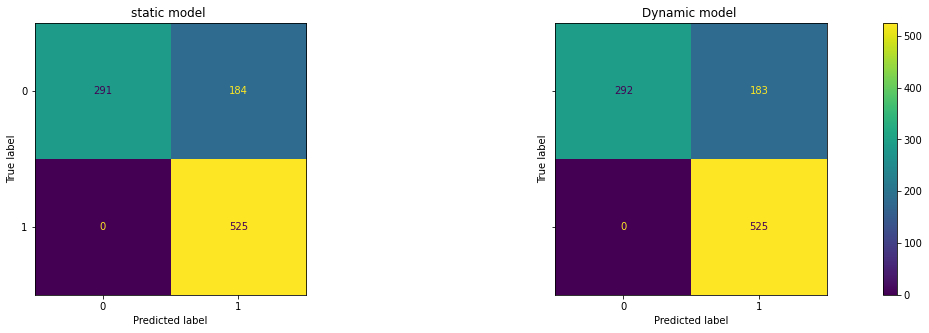

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 239
After getting the data from the window : the f1-score of the static  model= 0.8635 
After getting the data from the window : the f1-score of the Dynamic model= 0.8635 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       440
           1       0.76      1.00      0.86       560

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       440
           1       0.76      1.00      0.86       560

    accuracy                           0.82      1000
   macro avg       0.88     

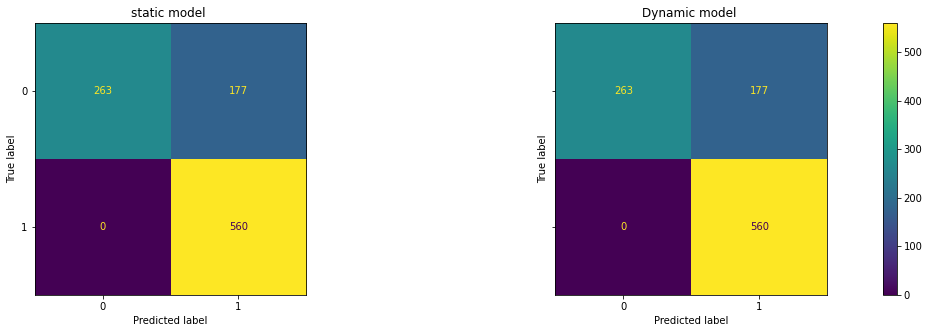

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 240
After getting the data from the window : the f1-score of the static  model= 0.8719 
After getting the data from the window : the f1-score of the Dynamic model= 0.8725 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       425
           1       0.77      1.00      0.87       575

    accuracy                           0.83      1000
   macro avg       0.89      0.80      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       425
           1       0.77      1.00      0.87       575

    accuracy                           0.83      1000
   macro avg       0.89     

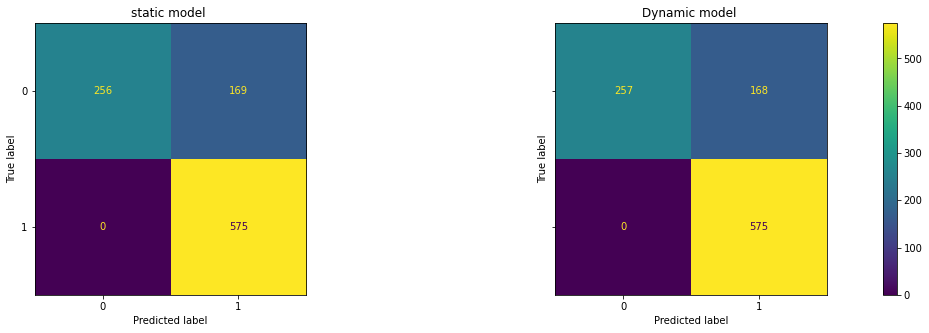

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 241
After getting the data from the window : the f1-score of the static  model= 0.8626 
After getting the data from the window : the f1-score of the Dynamic model= 0.8634 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.58      0.73       430
           1       0.76      1.00      0.86       570

    accuracy                           0.82      1000
   macro avg       0.88      0.79      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.74       430
           1       0.76      1.00      0.86       570

    accuracy                           0.82      1000
   macro avg       0.88     

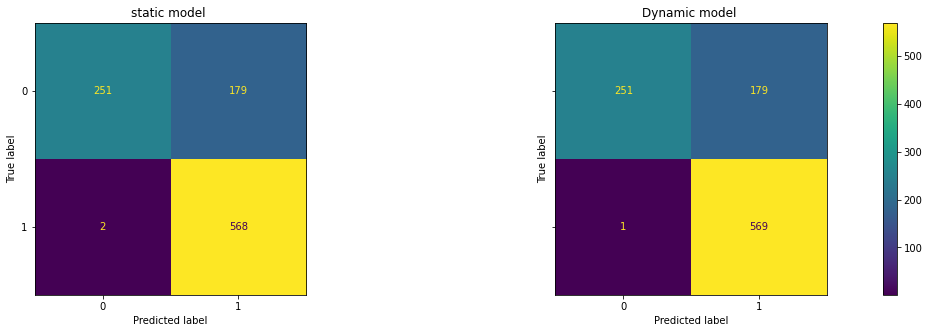

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 242
After getting the data from the window : the f1-score of the static  model= 0.8377 
After getting the data from the window : the f1-score of the Dynamic model= 0.8377 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       488
           1       0.72      1.00      0.84       512

    accuracy                           0.80      1000
   macro avg       0.86      0.80      0.79      1000
weighted avg       0.86      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       488
           1       0.72      1.00      0.84       512

    accuracy                           0.80      1000
   macro avg       0.86     

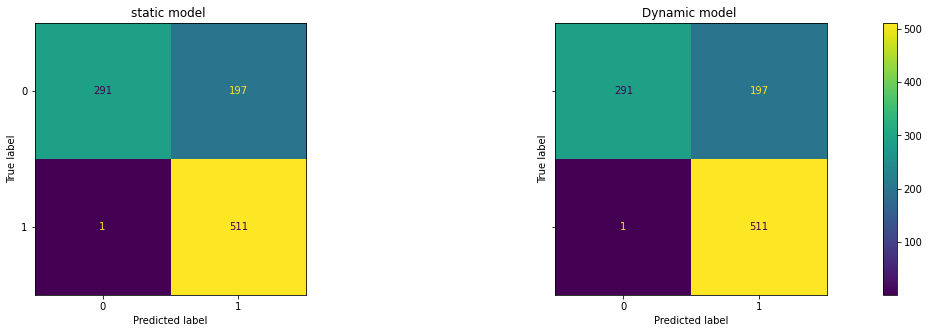

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8377
window : 243
After getting the data from the window : the f1-score of the static  model= 0.8584 
After getting the data from the window : the f1-score of the Dynamic model= 0.8584 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       435
           1       0.75      1.00      0.86       565

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       435
           1       0.75      1.00      0.86       56

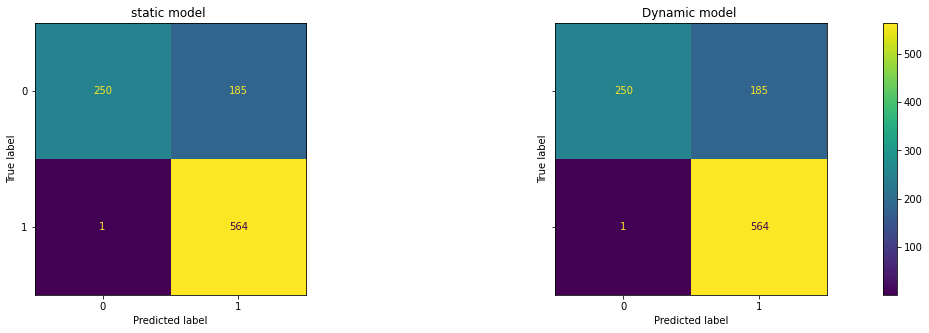

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 244
After getting the data from the window : the f1-score of the static  model= 0.8600 
After getting the data from the window : the f1-score of the Dynamic model= 0.8600 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       447
           1       0.75      1.00      0.86       553

    accuracy                           0.82      1000
   macro avg       0.88      0.80      0.80      1000
weighted avg       0.86      0.82      0.81      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       447
           1       0.75      1.00      0.86       553

    accuracy                           0.82      1000
   macro avg       0.88     

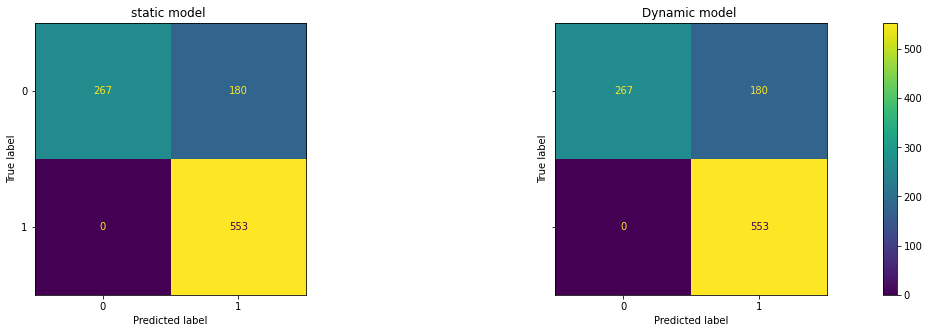

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 245
After getting the data from the window : the f1-score of the static  model= 0.8669 
After getting the data from the window : the f1-score of the Dynamic model= 0.8669 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       440
           1       0.77      1.00      0.87       560

    accuracy                           0.83      1000
   macro avg       0.88      0.80      0.81      1000
weighted avg       0.87      0.83      0.82      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       440
           1       0.77      1.00      0.87       560

    accuracy                           0.83      1000
   macro avg       0.88     

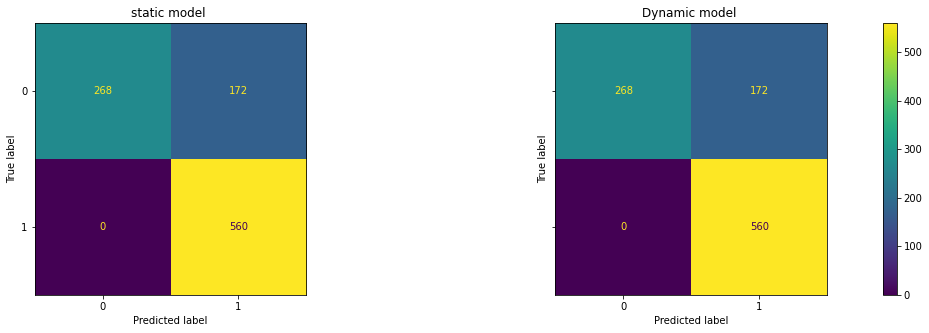

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 246
After getting the data from the window : the f1-score of the static  model= 0.8595 
After getting the data from the window : the f1-score of the Dynamic model= 0.8595 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       434
           1       0.75      1.00      0.86       566

    accuracy                           0.81      1000
   macro avg       0.88      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       434
           1       0.75      1.00      0.86       566

    accuracy                           0.81      1000
   macro avg       0.88     

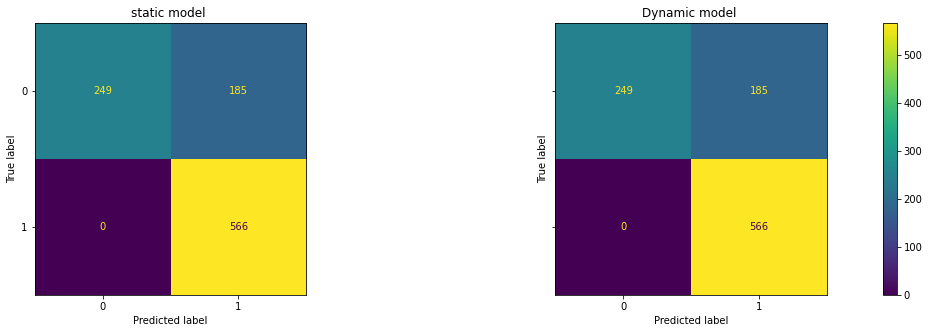

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 247
After getting the data from the window : the f1-score of the static  model= 0.8369 
After getting the data from the window : the f1-score of the Dynamic model= 0.8379 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       478
           1       0.72      1.00      0.84       522

    accuracy                           0.80      1000
   macro avg       0.86      0.79      0.78      1000
weighted avg       0.85      0.80      0.79      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       478
           1       0.72      1.00      0.84       522

    accuracy                           0.80      1000
   macro avg       0.86     

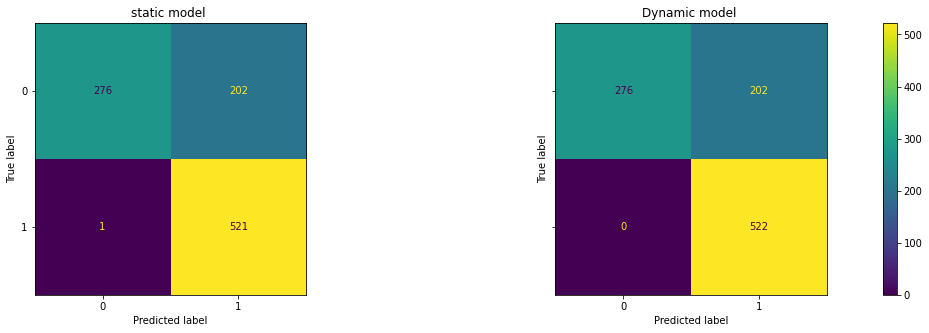

 The f1-score value of the Dynamic model under the threshold , then retrain it 
After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = 0.8379
window : 248
After getting the data from the window : the f1-score of the static  model= 0.8494 
After getting the data from the window : the f1-score of the Dynamic model= 0.8503 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.60      0.75       468
           1       0.74      1.00      0.85       532

    accuracy                           0.81      1000
   macro avg       0.87      0.80      0.80      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       468
           1       0.74      1.00      0.85       53

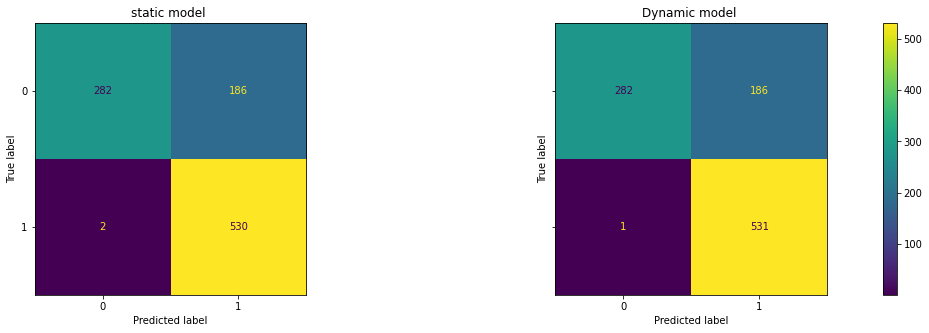

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is
window : 249
After getting the data from the window : the f1-score of the static  model= 0.8527 
After getting the data from the window : the f1-score of the Dynamic model= 0.8552 
the performance evaluation of the static and Dynamic models
 
classification Report for the static  model
              precision    recall  f1-score   support

           0       0.99      0.58      0.73       445
           1       0.75      1.00      0.85       555

    accuracy                           0.81      1000
   macro avg       0.87      0.79      0.79      1000
weighted avg       0.86      0.81      0.80      1000

 
classification Report for the Dynamic model
              precision    recall  f1-score   support

           0       1.00      0.58      0.73       445
           1       0.75      1.00      0.86       555

    accuracy                           0.81      1000
   macro avg       0.87     

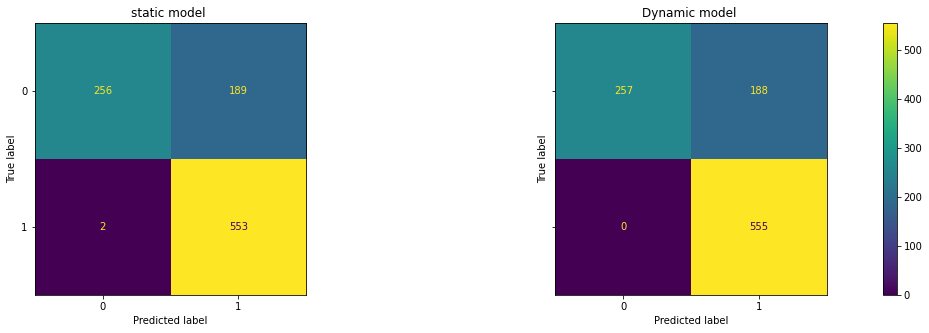

 The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is


In [15]:
# create two lists to save the data from the two models , static and dynamic 
lst_of_Static_model_f1_scores  =[]
lst_of_Dynmaic_model_f1_scores =[]


for i in range(1,250):
    
    # get a dataset which contains 1000 records from the window
    window_dataset = build_1000_row_window(i)
    
    # put the data in the shape of the original dataframe (row data => dataframe)
    prepared_dataset = prepare_dataFrame(window_dataset)
    
    # drop null values , deal with "longest_word" and "sld" columns , drop the "timestamp" 
    cleaned_dataset =  data_cleaning(prepared_dataset)
    
    
    # create x and y then normalize x and return the normalized_X and y
    preprocessed_dynamic_x,dynamic_y = preprocess_Dataset(cleaned_dataset,selected_features_names,"Target Attack")    
    
    # get the prediction of the static model 
    # apply predict function on X_test and calculate f1-score 
    static_f1_value  = pred(static_model,preprocessed_dynamic_x,dynamic_y )
    
    # get the prediction of the Dynamic model
    # apply predict function on X_test and calculate f1-score 
    dynamic_f1_value = pred(Dynamic_model,preprocessed_dynamic_x,dynamic_y )
    
    # print the results 
    print(f"After getting the data from the window : the f1-score of the static  model= {static_f1_value:.4f} ")
    print(f"After getting the data from the window : the f1-score of the Dynamic model= {dynamic_f1_value:.4f} ")
    
    evaluate_2_model_performance(static_model,Dynamic_model,preprocessed_dynamic_x,dynamic_y)
    
    # append the results 
    lst_of_Static_model_f1_scores.append(static_f1_value)
    


    threshold = 0.85
    
    # if the model under the threshold , then retrain 
    if dynamic_f1_value < threshold :

        print(" The f1-score value of the Dynamic model under the threshold , then retrain it ")
        
        # retrain the model with the dataset the have the static dataset without first 1000 rows 
        new_Dynamic_model   = retrain_model(static_dataset) 
        
        # get the prediction of the new dynamic model after retrain .
        new_dynamic_f1_value     = pred(new_Dynamic_model,preprocessed_dynamic_x,dynamic_y)
        
        print(f"After Retrain with the (static_dataset + window data) : the f1-score of the Dynamic model = {new_dynamic_f1_value:.4f}")
        
        lst_of_Dynmaic_model_f1_scores.append(new_dynamic_f1_value)
        Dynamic_model = new_Dynamic_model
        
    else:
        print(" The F1-score of the Dynamic model above the threshold , then Keep the Dynamic model as it is")
        lst_of_Dynmaic_model_f1_scores.append(dynamic_f1_value)
        
    # append the data of this window to the static dataset to be used later if we need it.
    #skip the first 1000 record from the static dataset

    sliced  = static_dataset.iloc[1000: , :]

    static_dataset = sliced

    static_dataset = static_dataset.append(prepared_dataset)
        
    print("================================================================================================")


<h3 style="color:rgb(92, 11, 10)">11. Describe your results and make a conclusion of whether the dynamic
implementation is better or not, compared to the traditional static model. </h3>

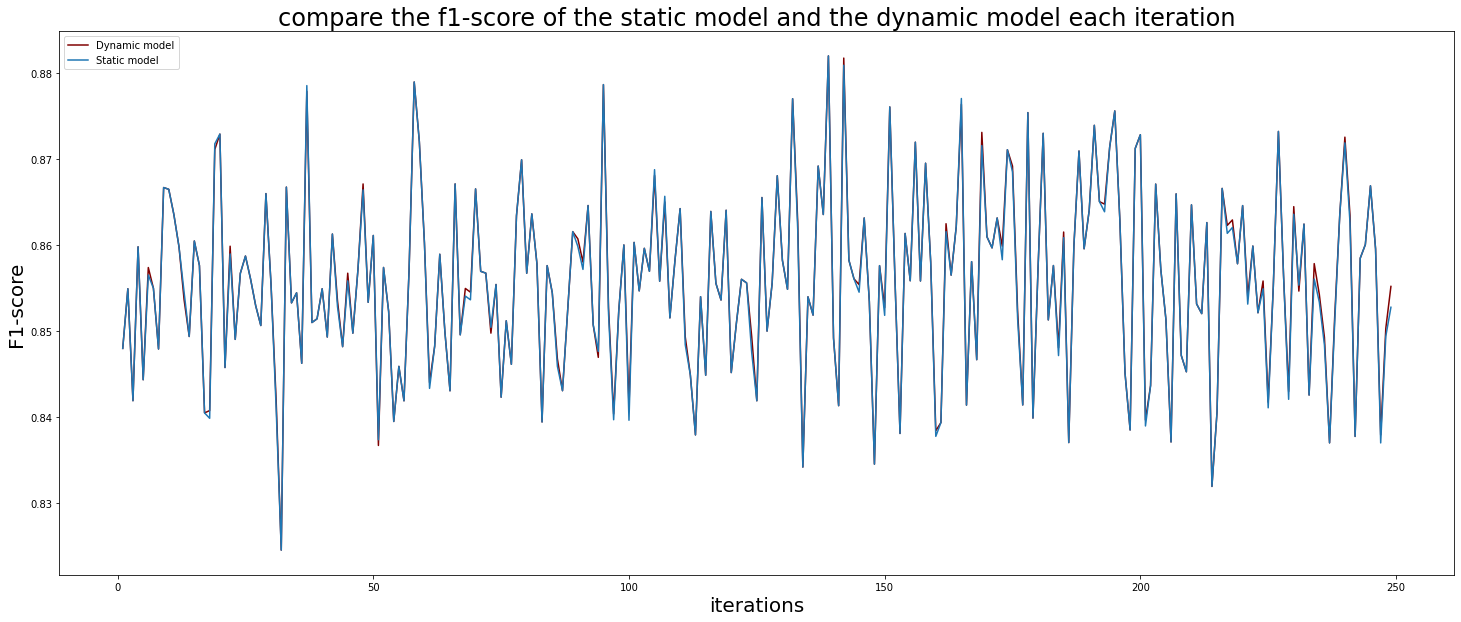

In [16]:
plt.figure(figsize=(25,10))
plt.plot(range(1, 250), lst_of_Dynmaic_model_f1_scores, label=f'Dynamic model',color="maroon")
plt.plot(range(1, 250),lst_of_Static_model_f1_scores, label=f'Static model')
plt.title("compare the f1-score of the static model and the dynamic model each iteration",fontsize=24)
plt.xlabel('iterations',fontsize=20)
plt.ylabel("F1-score",fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
compare_two_models(lst_of_Static_model_f1_scores,lst_of_Dynmaic_model_f1_scores)

Summary of the performance of the static and Dynamic models over 249 loop:
The static  was performing better than the Dynamic model 10 times 
The Dynamic was performing better than the static  model 48 times 
Both the static and the Dynamic models have the same performance 191 times


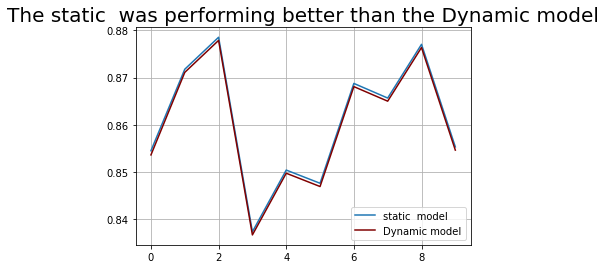

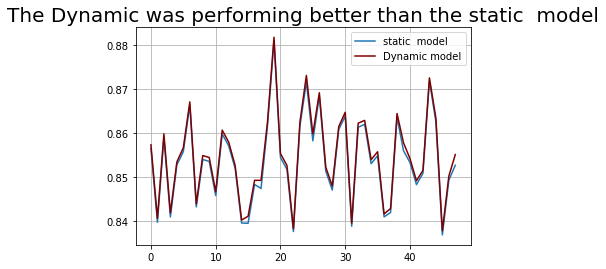

In [36]:
analyse_cases(lst_of_Static_model_f1_scores,lst_of_Dynmaic_model_f1_scores)